# TimeSeries Data Science Case Study
#### *_Contributor : Ashutosh Kumar_* 
#### *_Contact Details : ashutoshind2017@outlook.com_* 


  
_Python version : Python 3.7.1, IDE = Anaconda Jupyter ,conda version conda 4.8.3_
  

## Objective:
Forecasting unit movement for next 3 months by each class w.r.t each channel


## Data:
I have attached weekly Units of Each class of products by each channel (ideally we have to predict this at Store/Week/SKU level).


## Looking forward to have:

·   EDA and Insights of Seasonality , Cyclical behavior and additionally whatever you can bring to the table.  
·   Model the unit movement, based on this data. Keep 1 month of gap between training and forecasting and then forecast for 3 months by each channel/week/Class ID level.


## Expected Output:

·   Ipynb with all descriptive and insights along with modelling  
.   CSV File with the actual VS predicted results at the granularity mentioned 


In [189]:
# import the required libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly as py
from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.express as px

import itertools
from datetime import datetime
from functools import reduce

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax,boxcox

from sklearn.metrics import r2_score, median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from math import log
from math import exp
from itertools import product

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import fcluster, ward, dendrogram, linkage, cut_tree
from sklearn.cluster import AgglomerativeClustering

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

#from sklearn.decomposition import PCA
from tqdm import tqdm_notebook

# from paretochart import pareto

import statsmodels.graphics.tsaplots as tsa
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

#from linearmodels import PanelOLS
#from linearmodels import RandomEffects

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# Saving the model :
from sklearn.externals import joblib

# Suppressing Warnings:
import warnings
warnings.filterwarnings('ignore')

## Step1 : Exploratory Data Analysis :

### *1.1 Data Understanding :*

In [2]:
# read data from the zip file:
data_units=pd.read_csv('data_class_channel_week_units.zip')

# First look of the data :
data_units.head()

trans_year  trans_week  class_id store_type  num_units
0        2011           6       NaN    OUTLETS     125469
1        2011          31       NaN     RETAIL     805609
2        2011          25       NaN     RETAIL    1097691
3        2011          33       NaN     RETAIL     829735
4        2011          48       NaN     RETAIL    1073527

In [3]:
# Examining the dataset imported:

#Examining the data frame for the shape:
print(data_units.shape)

(130324, 5)


#### So, there are 130324 rows/records and 5 columns/features in the dataset

In [4]:
# Checking datatypes, NUlls etc:
print(data_units.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trans_year  130324 non-null  int64  
 1   trans_week  130324 non-null  int64  
 2   class_id    128980 non-null  float64
 3   store_type  130324 non-null  object 
 4   num_units   130324 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 5.0+ MB
None


In [5]:
# So, we have 1 categorical variable and 4 numerical variable here.

#### So, only one column "store_type" has the non-numeric data-type

In [6]:
# Identify the missing data:
# creating a function to identify the missing data in dataset:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

### *1.2 Missing Value Analysis and Treatment :*

In [7]:
missing_data(data_units).head()

Total   Percent
class_id     1344  1.031276
num_units       0  0.000000
store_type      0  0.000000
trans_week      0  0.000000
trans_year      0  0.000000

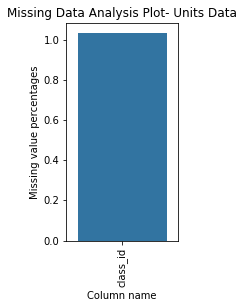

In [8]:
missing_data_df = (data_units.isnull().sum() / len(data_units)) * 100
missing_data_df = missing_data_df.drop(missing_data_df[missing_data_df == 0].index).sort_values(ascending=False)

plt.figure(figsize=(2,4))
plt.xticks(rotation="90")
plt.title('Missing Data Analysis Plot- Units Data')
plt.xlabel("Column name")
plt.ylabel("Missing value percentages")
sns.barplot(x=missing_data_df.index, y=missing_data_df)
plt.show()

#### So, only column class_id is having 1.03% (1344 units) of missing values in the dataset.

In [9]:
# Lets create functions to deal with null values and do feature exploration:
# Looking at categorical values
def feature_exploration(column):
    return data_units[column].value_counts()

# Imputing the missing values
def feature_imputation(column, value):
    data_units.loc[data_units[column].isnull(),column] = value

In [10]:
# class_id may refer to the category to which the SKU belongs to and its important feature, so doing missing value treatment :
# We are replacing all the missing class_id with default class value of 499 :
feature_imputation('class_id', 499)

In [11]:
# Confirming if the missing value exists or no now :
missing_data(data_units).head()

Total  Percent
num_units       0      0.0
store_type      0      0.0
class_id        0      0.0
trans_week      0      0.0
trans_year      0      0.0

#### So, we have dealt with the missing value treatment now, and there are no missing values anymore 

### *1.3 Initial Correlation in the dataset :*

In [12]:
# Finding the initial full correlation in the dataset:
# correlation matrix
cor = data_units.corr()
cor

trans_year  trans_week  class_id  num_units
trans_year    1.000000   -0.202376  0.012725  -0.068619
trans_week   -0.202376    1.000000 -0.000118  -0.003718
class_id      0.012725   -0.000118  1.000000  -0.071103
num_units    -0.068619   -0.003718 -0.071103   1.000000

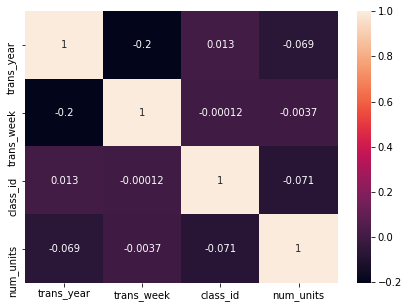

In [13]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(7,5))
# heatmap
sns.heatmap(cor, annot=True)
plt.show()

#### So, there is very very weak or no correlation in the dataset as per initial observation between variables

### *1.4 Feature Exploration, Outlier Analysis and Treatment :*

In [14]:
# Traditional descriptive statistics of the columns:
data_units.describe()

trans_year     trans_week       class_id     num_units
count  130324.000000  130324.000000  130324.000000  1.303240e+05
mean     2015.606197      26.069780     623.456424  4.156732e+03
std         2.015561      15.413193      74.794957  2.655951e+04
min      2011.000000       0.000000     499.000000 -4.000000e+00
25%      2014.000000      13.000000     570.000000  2.180000e+02
50%      2016.000000      26.000000     621.000000  8.910000e+02
75%      2017.000000      40.000000     699.000000  3.153250e+03
max      2019.000000      53.000000     748.000000  1.553843e+06

#### There is a red flag here num_units are negative as well 

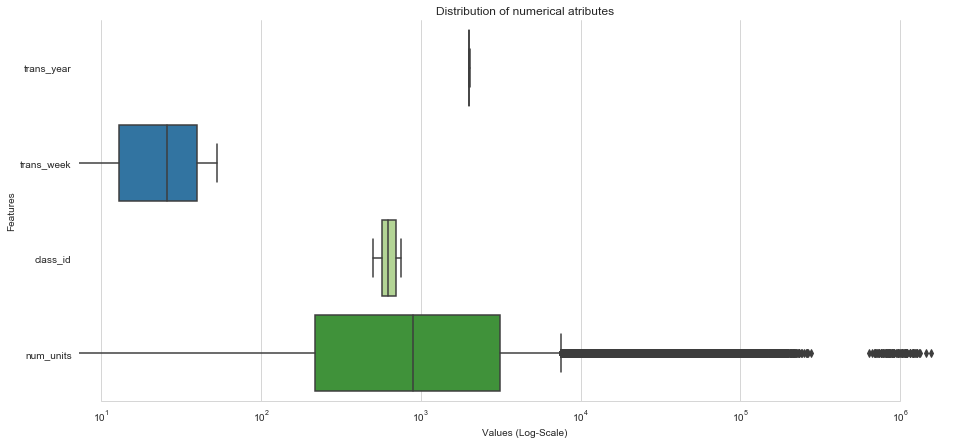

In [15]:
# Another look at the distribution of numerical attribute:

# Creating a list of dataframe columns which are numeric:
num_features = data_units.select_dtypes(include=[np.number]).columns.tolist()
li_plot_num_feats = [c for c in list(num_features)]


# Boxplot for the numerical features against the target num_units variable:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(16, 7))
# Using log scale:
ax.set_xscale("log")
ax = sns.boxplot(data=data_units[li_plot_num_feats] , orient="h", palette="Paired")
ax.set(ylabel="Features")
ax.set(xlabel="Values (Log-Scale)")
ax.set(title="Distribution of numerical atributes")
sns.despine(trim=True, left=True)

In [945]:
# There are clearly numerical outliers for the num_units. Also 1 outlier in class_id which is imputed by us (499).

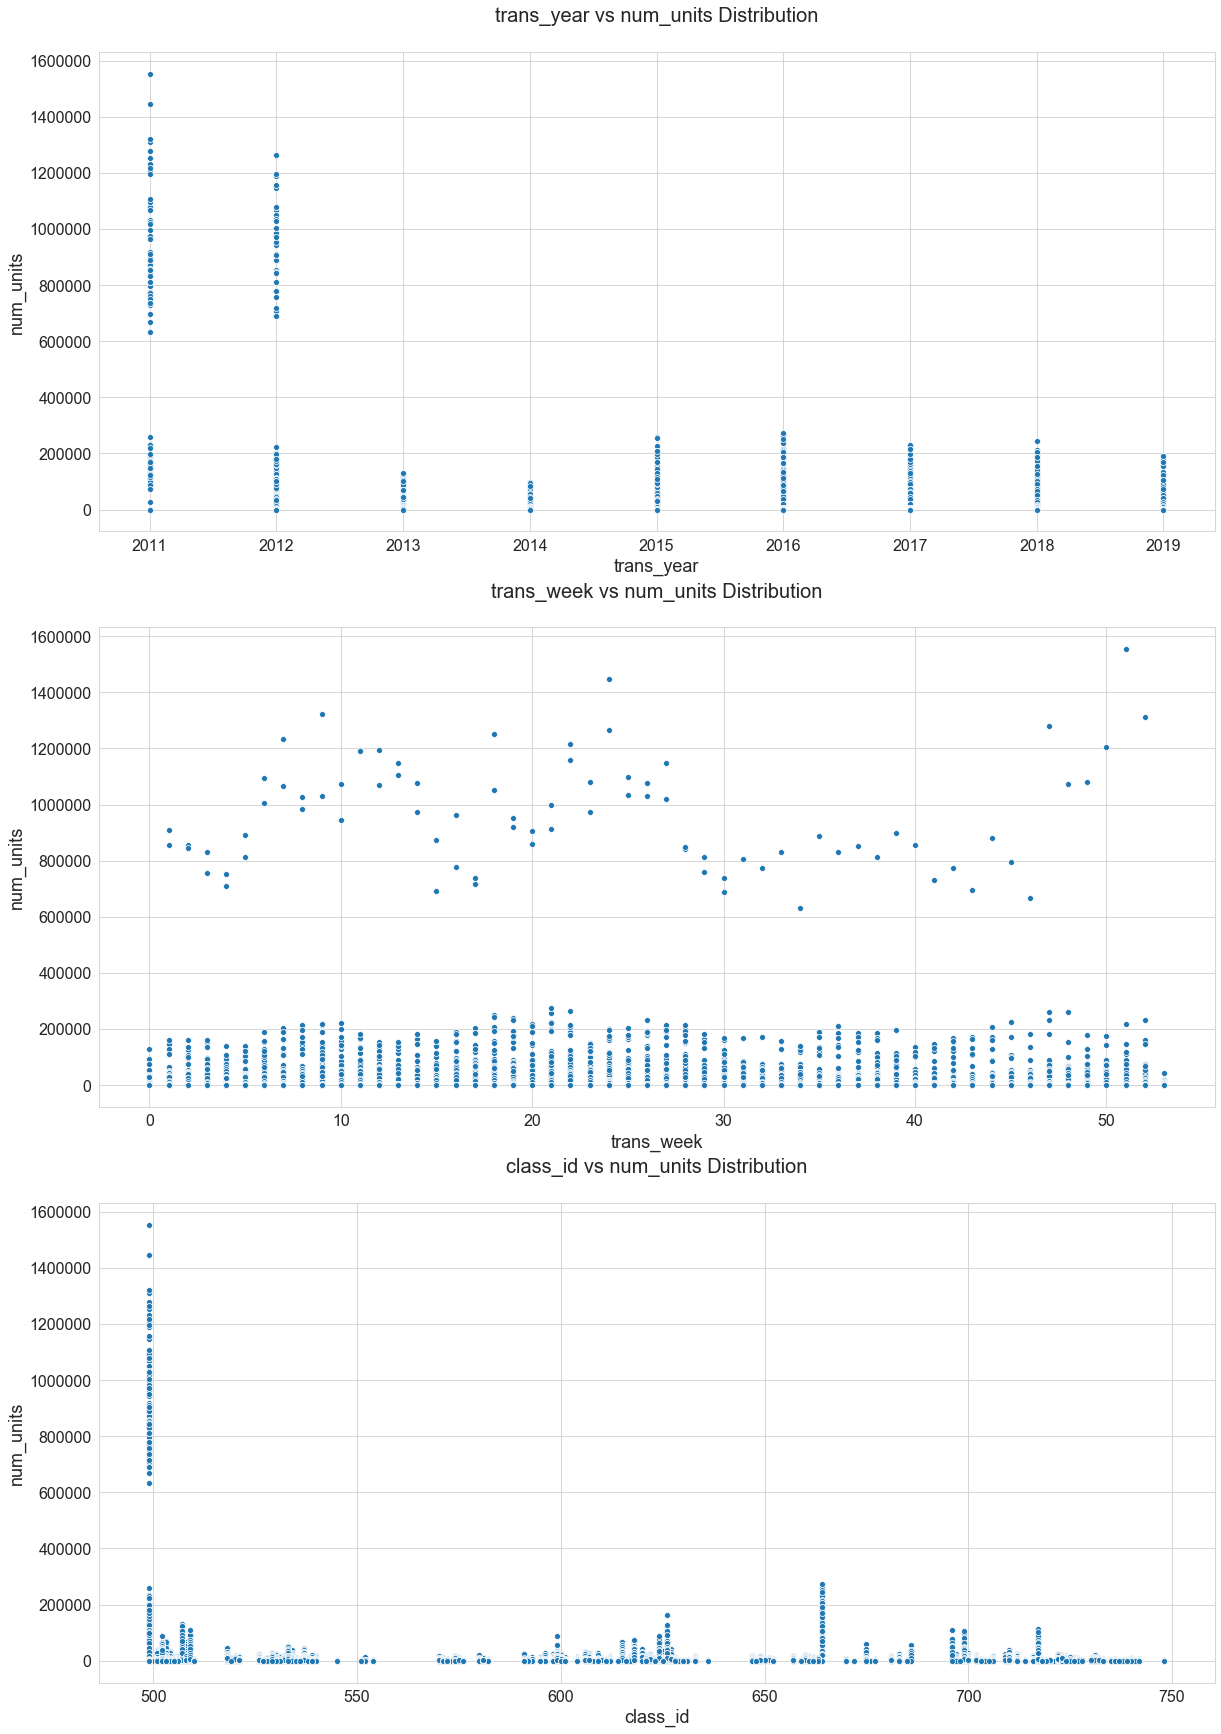

In [16]:
# Bivariate Analysis wrt to target variable  :
fig = plt.figure(figsize=(20, 30))
cmap = sns.color_palette('Set2')

# PLot the relation between the variables:
plt.subplot(3,1,1)
sns.scatterplot(x=data_units['trans_year'], y='num_units', palette='Blues_d', data=data_units)
plt.xlabel('trans_year', size=18)
plt.ylabel('num_units', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('trans_year vs num_units Distribution', size=20, y=1.05)

plt.subplot(3,1,2)
sns.scatterplot(x=data_units['trans_week'], y='num_units', palette='Blues_d', data=data_units)
plt.xlabel('trans_week', size=18)
plt.ylabel('num_units', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('trans_week vs num_units Distribution', size=20, y=1.05)

plt.subplot(3,1,3)
sns.scatterplot(x=data_units['class_id'], y='num_units', palette='Blues_d', data=data_units)
plt.xlabel('class_id', size=18)
plt.ylabel('num_units', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('class_id vs num_units Distribution', size=20, y=1.05)

plt.show()

In [17]:
# There are multiple importany observations here:
# 1. The higher value of num_units seems to be high across all the weeks , though considerably higher at week >50 i.e towards
#    the end of the year
# 2. The highest value of the num_units belongs to the class of imputed missing class of 499
# 3. The num_units movement was considerably higher in the initial years of 2011 and 2012.

In [17]:
# store_type: Represents the channel in which the unit movement was recorded , categorical attribute:
feature_exploration('store_type')

RETAIL     45002
ECOM       42973
OUTLETS    42349
Name: store_type, dtype: int64

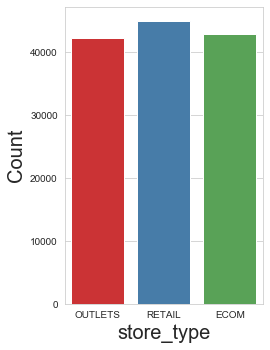

In [18]:
# Plot of the categorical features distribution:
units_cat_var_list = data_units.select_dtypes(exclude=[np.number]).columns.tolist()

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(2,3))
plt.subplots_adjust(right=1.5, top=1.5)

for i, feature in enumerate(units_cat_var_list, 1):    
    sns.set(font_scale = 1.1)
    sns.countplot(x=feature, data=data_units, palette='Set1')
        
    plt.xlabel('{}'.format(feature), size=20)
    plt.ylabel('Count', size=20)
            
plt.show()

In [950]:
# So, the highest number of transactions are recorded for retail stores with count as 45002 and least is through outlet channel.

In [19]:
# Converting the store_type into the numerical variable:
data_units['store_type'] = data_units['store_type'].map({'ECOM':0, 'OUTLETS':1, 'RETAIL':2})

In [20]:
data_units.head()

trans_year  trans_week  class_id  store_type  num_units
0        2011           6     499.0           1     125469
1        2011          31     499.0           2     805609
2        2011          25     499.0           2    1097691
3        2011          33     499.0           2     829735
4        2011          48     499.0           2    1073527

In [21]:
# Covert the float class_id back to int :
data_units['class_id'] = data_units['class_id'].apply(np.int64)
data_units.head()

trans_year  trans_week  class_id  store_type  num_units
0        2011           6       499           1     125469
1        2011          31       499           2     805609
2        2011          25       499           2    1097691
3        2011          33       499           2     829735
4        2011          48       499           2    1073527

#### *Understanding the target variable "num_units":*

In [22]:
# num_units : This variable signifies the number of units movement happened for a transaction record in dataset.

# num_units  across the data
def num_units_dist(data):
    unit_df = data.copy(deep=True)
    unit_df['units_bin'] = pd.cut(unit_df.num_units, [0, 100, 500, 1000, 10000, 100000])
    print('Max units value:', unit_df.num_units.max())
    print('Min units value:', unit_df.num_units.min())
    print('Avg units value:', unit_df.num_units.mean())
    print()
    return unit_df

unit_df = num_units_dist(data_units)

# Total number of data points
total_points = pd.value_counts(unit_df.units_bin).sum()
print('Units bucket v/s Total percentage:')
display(pd.value_counts(unit_df.units_bin).apply(lambda s: (s/total_points)*100))

Max units value: 1553843
Min units value: -4
Avg units value: 4156.731699456738

Units bucket v/s Total percentage:


(1000, 10000]      39.983377
(100, 500]         21.212261
(0, 100]           17.241937
(500, 1000]        14.114315
(10000, 100000]     7.448110
Name: units_bin, dtype: float64

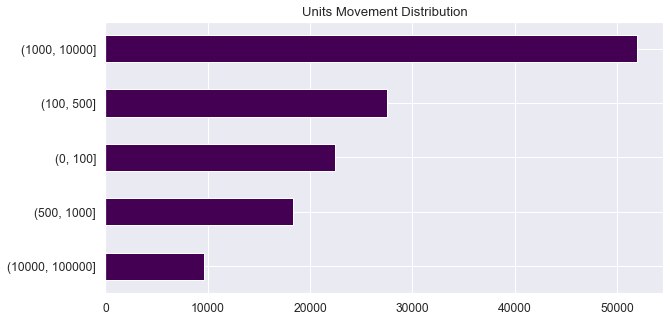

In [23]:
# Let us visualize the same
plt.figure(figsize=(10,5))
units_count = pd.value_counts(unit_df.units_bin)
units_count.sort_values(ascending=True).plot(kind='barh', title='Units Movement Distribution',colormap='viridis')

#plt.xlabel='Units absolute value'
#plt.ylabel='Bin Range'
plt.show()

In [956]:
# So the highest number of unit moevemnt has occured in the range of 1000 to 10000 units as per the data,

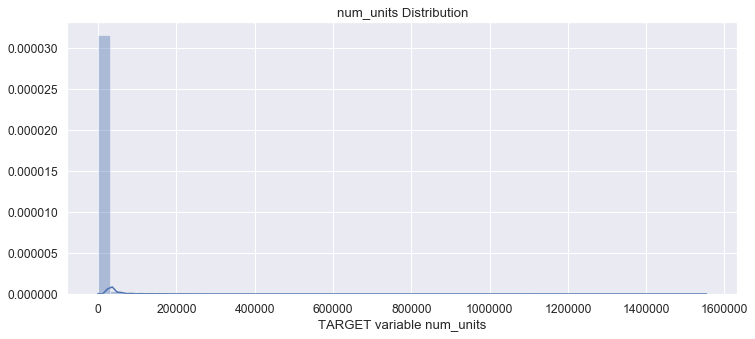

In [25]:
plt.figure(figsize=(12, 5))

plt.title('num_units Distribution')
#data_units['num_units'].astype(int).plot.hist();
sns.distplot(data_units['num_units'], hist=True)
plt.xlabel("TARGET variable num_units")
plt.show()

In [26]:
# As evident from the boxplot, distribution plot and correlation matrix there are negative value as well for the num_units:
data_units.loc[data_units.num_units<0]

trans_year  trans_week  class_id  store_type  num_units
17756        2013          22       648           0         -1
28293        2014          37       675           0         -1
30288        2014           1       697           0         -1
30291        2014          26       675           0         -2
32005        2014          19       675           0         -1
39535        2014          27       675           0         -4
39591        2014           2       675           0         -2

In [27]:
# So, number of unit movement can not be negative practically, its only possible in case of the Returns but returns will be 
# created from ecom to DC and not to ECOMM channel as such.
# Also, the absolute value of num_units is less than 5 (very less)

# Updating these transactions with num_units as 0 :
data_units['num_units'] = data_units['num_units'].apply(lambda x : 0 if x < 0 else x)

In [28]:
# Verifying for negative values for the num_units in the dataset :
data_units.loc[data_units.num_units<0]

Empty DataFrame
Columns: [trans_year, trans_week, class_id, store_type, num_units]
Index: []

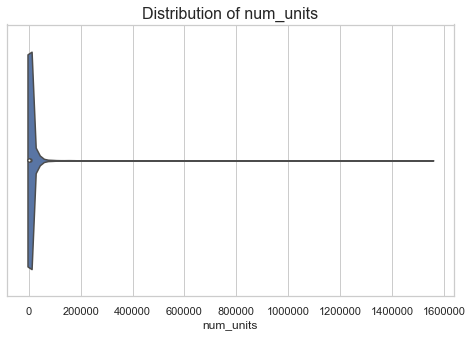

In [29]:
# Again, visualising the target variable with the violin plot :
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize =(8, 5)) 
sns.violinplot(y = data_units["num_units"] ,orient='h') 
ax.set_title('Distribution of num_units', fontsize=16);

In [36]:
# There are clearly statistical outlier with values >1000000 unit movements,  but we will not perform outlier treatment as of 
# now, as they might be legitimate as well for one 1 week and having more than 1000 stires or so.

# We will revsit the same later if needed.

In [30]:
# Let's relook the data :
data_units.head()

trans_year  trans_week  class_id  store_type  num_units
0        2011           6       499           1     125469
1        2011          31       499           2     805609
2        2011          25       499           2    1097691
3        2011          33       499           2     829735
4        2011          48       499           2    1073527

In [31]:
# As, we can clearly see that the trans_week is not in order for the given year, so we need to re-arrange the data by grouping 
# by order, sorting by the week ascending and then order by trans_year overall.

# This is the requirement of performing the time-series analysis that the data should be in the order of time:
data_units = data_units.sort_values(['trans_year', 'trans_week'], ascending=[True, True]).reset_index(drop=True)
data_units.head(10)

trans_year  trans_week  class_id  store_type  num_units
0        2011           0       499           2     130329
1        2011           0       499           0          5
2        2011           0       499           1      26152
3        2011           0       616           2         28
4        2011           0       615           2          1
5        2011           1       499           1     112144
6        2011           1       615           2          6
7        2011           1       616           0        106
8        2011           1       616           2        209
9        2011           1       499           0     116142

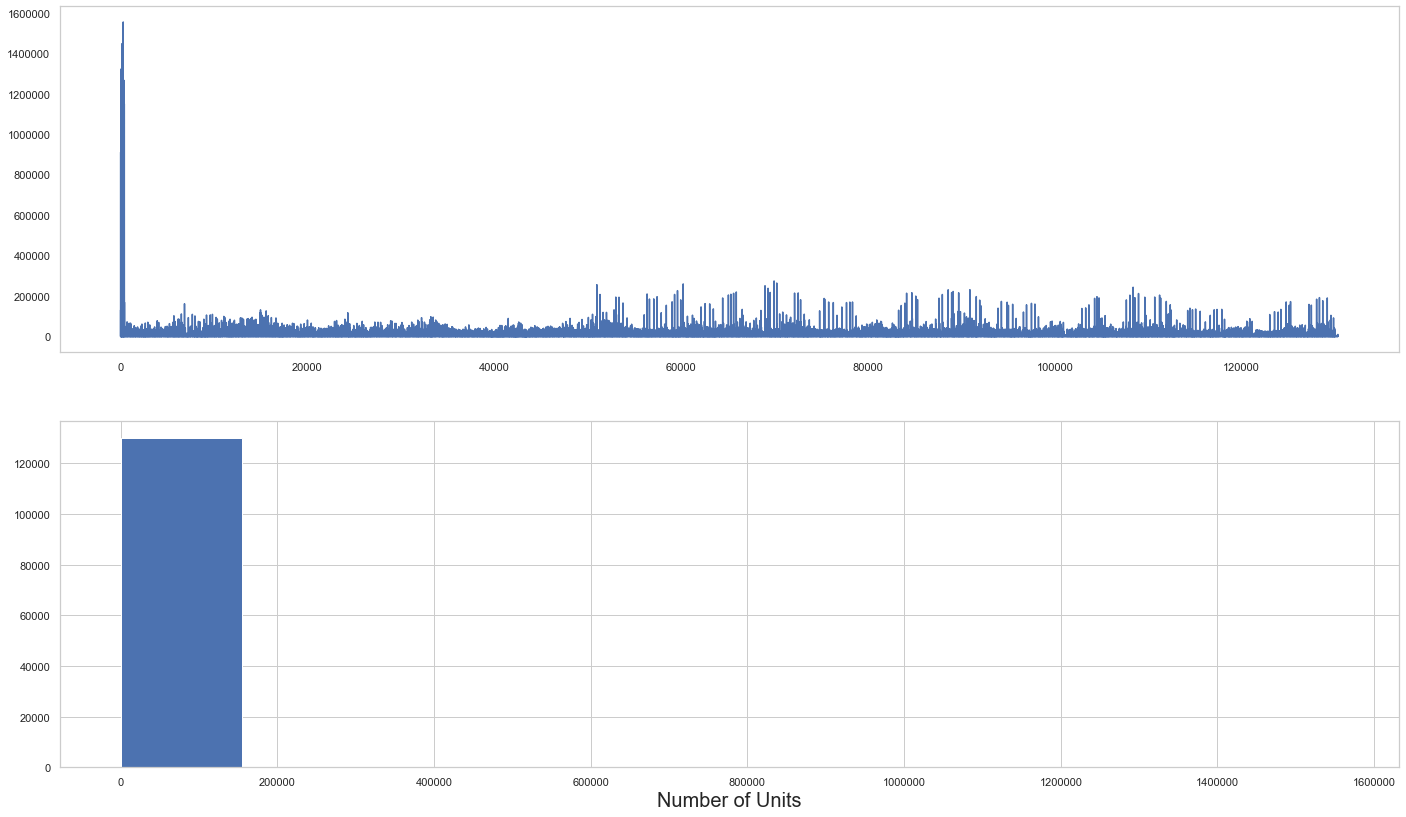

In [32]:
# Plotting the raw time series that we have in hand:
plt.figure(figsize=(24, 14))

plt.title('Visualisation of Number of Units')

plt.figure(1)
# line plot
plt.subplot(211)
plt.grid(False)
plt.plot(data_units['num_units'])

# histogram
plt.subplot(212)
plt.hist(data_units['num_units'])
plt.xlabel('Number of Units',fontsize=20)
plt.show()

In [33]:
# We can find that the week numbers are not consistent across the years. For some years it is from 0 to 52, while for rest
# of the year it is 1 to 53.

# Let's find that information :

In [34]:
# Years which have weeks from 0 to 52:
df1 = data_units[data_units['trans_week'] ==  0] 
df1 = df1[df1.duplicated(['trans_year'], keep=False)]
print (df1.trans_year.unique())

[2011 2013 2014 2015 2016 2018 2019]


In [35]:
# Years which have weeks from 1 to 53:
df2 = data_units[data_units['trans_week'] ==  53] 
df2 = df2[df2.duplicated(['trans_year'], keep=False)]
print (df2.trans_year.unique())

[2012 2017]


In [36]:
# Let's make the weeks consistent across the years , incrementing the values by 1 for 0 to 52 weeks years :
years_to_update =[2011,2013,2014,2015,2016,2018,2019]
data_units.loc[data_units['trans_year'].isin(years_to_update),['trans_week']]+=1

In [37]:
# Validating that the weeks are updated correctly:
df3 = data_units[data_units['trans_year'] ==  2015] 
df3 = df3[df3.duplicated(['trans_week'], keep=False)]
print (df3.trans_week.unique())

# Years which had weeks from 0 to 52:
df1 = data_units[data_units['trans_week'] ==  53] 
df1 = df1[df1.duplicated(['trans_year'], keep=False)]
print (df1.trans_year.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53]
[2011 2012 2013 2014 2015 2016 2017 2018]


In [38]:
# As we see that the number of weeks, num_weeks is single digits. This will create issue while sorting based on number of 
# years and week :

# Add leading zero to make all weeks 2 digits:
data_units["trans_week"] = data_units.trans_week.map("{:02}".format)
data_units.head()

trans_year trans_week  class_id  store_type  num_units
0        2011         01       499           2     130329
1        2011         01       499           0          5
2        2011         01       499           1      26152
3        2011         01       616           2         28
4        2011         01       615           2          1

In [48]:
# So, the weeks have been updated to the common scale for each year now.
# Please note that year 2019 is not coming in above valoidation because for year 2019 data is not available till week 53

In [39]:
# Now lets do another feature engineering to create a derived column which will reppresent uniquely as the year,week as 
# timeperiod for data :
data_units['week_period'] = data_units[['trans_year', 'trans_week']].apply(lambda x: ''.join(x.map(str)), axis=1)
data_units.tail()

trans_year trans_week  class_id  store_type  num_units week_period
130319        2019         24       502           0          4      201924
130320        2019         24       572           0          3      201924
130321        2019         24       659           1          1      201924
130322        2019         24       712           0          5      201924
130323        2019         24       625           1          1      201924

In [40]:
# Verifying unique timeperiods in 10 years data :

print (data_units.week_period.unique())

['201101' '201102' '201103' '201104' '201105' '201106' '201107' '201108'
 '201109' '201110' '201111' '201112' '201113' '201114' '201115' '201116'
 '201117' '201118' '201119' '201120' '201121' '201122' '201123' '201124'
 '201125' '201126' '201127' '201128' '201129' '201130' '201131' '201132'
 '201133' '201134' '201135' '201136' '201137' '201138' '201139' '201140'
 '201141' '201142' '201143' '201144' '201145' '201146' '201147' '201148'
 '201149' '201150' '201151' '201152' '201153' '201201' '201202' '201203'
 '201204' '201205' '201206' '201207' '201208' '201209' '201210' '201211'
 '201212' '201213' '201214' '201215' '201216' '201217' '201218' '201219'
 '201220' '201221' '201222' '201223' '201224' '201225' '201226' '201227'
 '201228' '201229' '201230' '201231' '201232' '201233' '201234' '201235'
 '201236' '201237' '201238' '201239' '201240' '201241' '201242' '201243'
 '201244' '201245' '201246' '201247' '201248' '201249' '201250' '201251'
 '201252' '201253' '201301' '201302' '201303' '2013

In [41]:
data_units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   trans_year   130324 non-null  int64 
 1   trans_week   130324 non-null  object
 2   class_id     130324 non-null  int64 
 3   store_type   130324 non-null  int64 
 4   num_units    130324 non-null  int64 
 5   week_period  130324 non-null  object
dtypes: int64(4), object(2)
memory usage: 6.0+ MB


In [42]:
# Converting the object into int datatype for week_period derived feature:
data_units['week_period'] = pd.to_numeric(data_units['week_period'])
data_units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   trans_year   130324 non-null  int64 
 1   trans_week   130324 non-null  object
 2   class_id     130324 non-null  int64 
 3   store_type   130324 non-null  int64 
 4   num_units    130324 non-null  int64 
 5   week_period  130324 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 6.0+ MB


In [43]:
# Sorting the date in main dataframe based on date and creating copy of the dataframe :
data_units = data_units.sort_values('week_period', ascending=True)

# backup of the main dataframe:
data_units_bkp = data_units.copy()
data_units.head()

trans_year trans_week  class_id  store_type  num_units  week_period
0        2011         01       499           2     130329       201101
1        2011         01       499           0          5       201101
2        2011         01       499           1      26152       201101
3        2011         01       616           2         28       201101
4        2011         01       615           2          1       201101

In [44]:
# Now let's group the data for every week and observe the net units movement for every week:
# Sorting the df by the week_period so that we are following the time series data :

# Creating grouped data frame for the data for each week  :
grouped_week = data_units.groupby('week_period', as_index=False).agg({"num_units": "sum"})
grouped_week = grouped_week.sort_values('week_period', ascending=True)
grouped_week.head()

week_period  num_units
0       201101     156515
1       201102    1139193
2       201103    1078632
3       201104    1083395
4       201105     926647

In [45]:
grouped_week.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448 entries, 0 to 447
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   week_period  448 non-null    int64
 1   num_units    448 non-null    int64
dtypes: int64(2)
memory usage: 10.5 KB


## Step2 : Model Building, Forecasting and Model Evaluation :

### We will be building multiple forecasting models for the given problem in hand in terms of below granularity :
1. Weekly Total Forecast and prediction of Units Movement.
2. Weekly total Units Movement prediction and forecast at the Channel Level.
3. Weekly total Units Movement prediction and forecast at the Product Class Level.

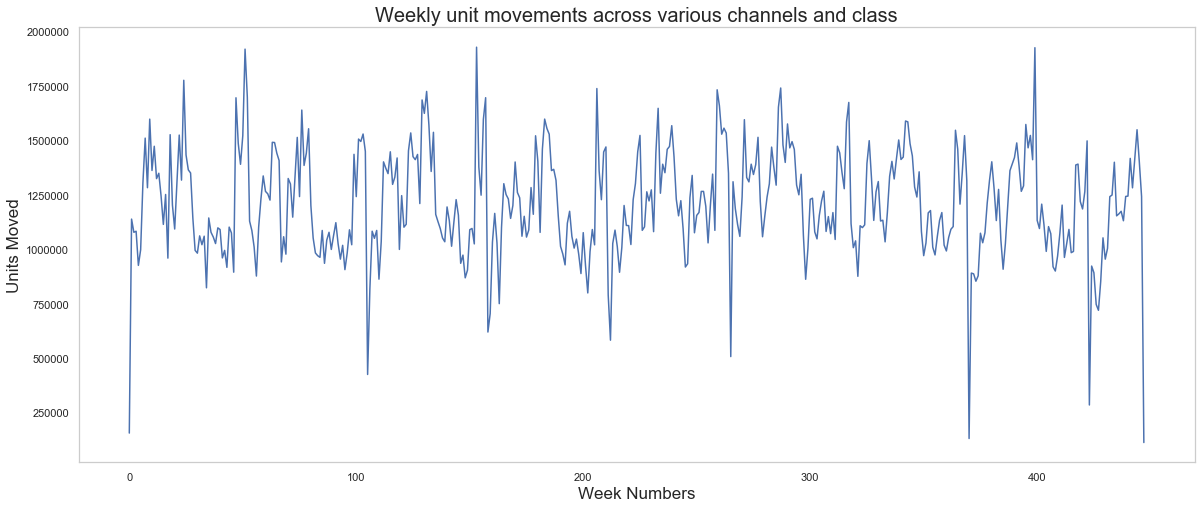

In [46]:
# Plot unit movement :

plt.figure(figsize=(20, 8))
plt.plot(grouped_week.num_units)
plt.title('Weekly unit movements across various channels and class', size =20)
plt.ylabel('Units Moved',size =17)
plt.xlabel('Week Numbers',size =17)
plt.grid(False)
plt.show()

In [47]:
# After seeing the plot above, it can be concluded that the units movement is not showing specific global upward or downward 
# trend, but indicates the presence of the seasonality and noise. 
# Let's explore more. 

In [48]:
# Smoothing is the process of making the curve smoother by 'averaging' out the noise to make the trend and seasonality more 
# apparent. Let's try this :

## 2.1 Weekly Total Unit Movement Forecasting :

#### Moving average smoothening :

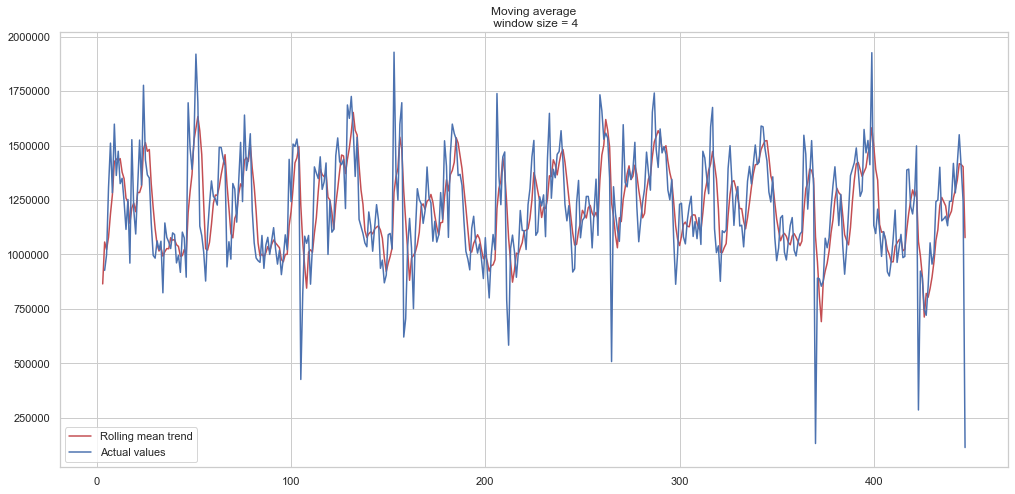

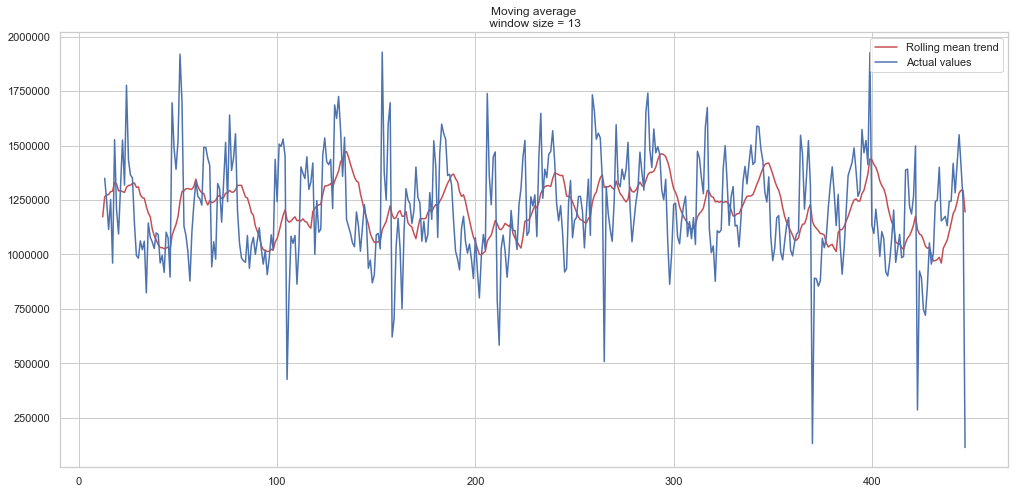

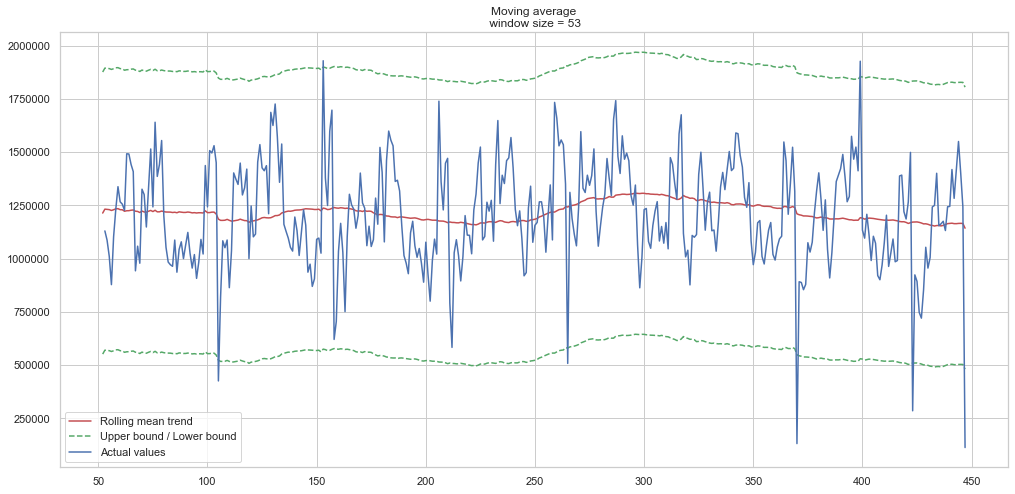

In [51]:
# Let’s use the moving average smoothening to smooth our time series. For that, we will use a helper function that will run the 
# moving average model on a specified time window and it will plot the result smoothed curve:

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'r', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'g--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'g--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
 #data_units['num_units']   
    
#Smooth by the previous 4 weeks ( previous month):
plot_moving_average(grouped_week.num_units, 4)

#Smooth by previous quarter (90 days), 3 months, 13 weeks :
plot_moving_average(grouped_week.num_units, 13)

# Smooth by previous year, 53 weeks :
plot_moving_average(grouped_week.num_units, 53, plot_intervals=True)

In [989]:
# Trends are easier to spot now. Notice how the quarterly and yearly trend show a downward curve at the end which should go up 
# in the following weeks.

#### Exponential Smoothening :

The other common way to carry out smoothing is what is known as exponential smoothing. In this scheme the current value is replaced by a weighted sum of the current value and the previous smoothed value.

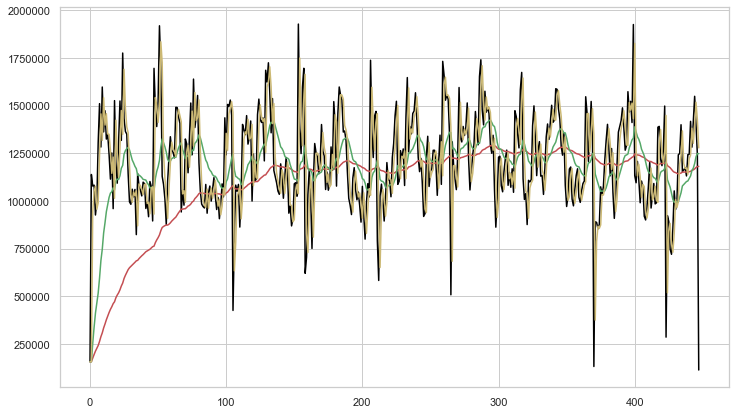

In [52]:
# Now, let’s use exponential smoothing to see if it can pick up a better trend:
y = pd.Series(grouped_week['num_units'])

fit1 = ExponentialSmoothing(y).fit(smoothing_level=0.02,optimized=False)
fit2 = ExponentialSmoothing(y).fit(smoothing_level=0.1,optimized=False)
fit3 = ExponentialSmoothing(y).fit(smoothing_level=0.8,optimized=False)
plt.figure(figsize = [12,7])
plt.plot(y, color = 'black')
fit1.fittedvalues.plot(color = 'r')
fit2.fittedvalues.plot(color = 'g')
fit3.fittedvalues.plot(color = 'y')

# Small values of smoothing levels result in higher levels of smoothing (may result in 'distorting' the original time series) 
# and large values (close to 1) will not result in any smoothing at all.

In [991]:
# The smoothening level of 0.1 seems to be correct for exponential smoothening.

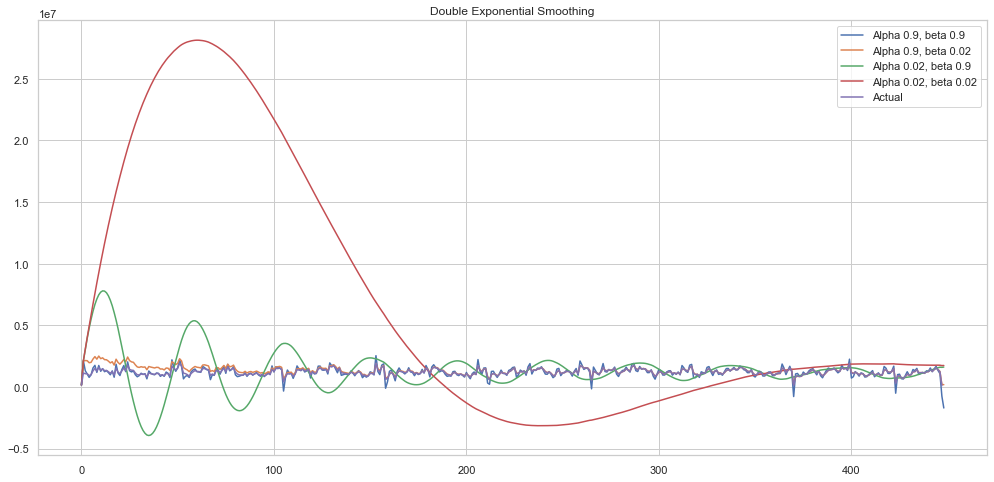

In [53]:
# Double exponential smoothing:

def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(grouped_week.num_units, alphas=[0.9, 0.02], betas=[0.9, 0.02])


In [54]:
# The alpha value of 0.02 and beta of 0.9 seems to be correct here.

In [55]:
# As outlined previously, we must turn our series into a stationary process in order to model it. Therefore, let’s apply the
# tests to see if it is a stationary process:

#### Stationary Tests :

Informally a stationary time series is one whose statistical properties such as mean, covariances between values at different times, etc. are all constant over time. A stationary time series therefore can be extended (forecasting) by simply assuming
the statistical properties observed in the historical part of the series, continue to hold in future as well.  
When dataset is non-stationary, meaning that the mean and the variance of the observations change over time. This makes it difficult to model by both classical statistical methods, like ARIMA, and more sophisticated machine learning methods, like neural networks.

#### KPSS and Augmented Dickey-Fuller Tests for stationarity :

In [56]:
# Let's do some stationary tests to confirm the same :

# Augmented Dickey-Fuller test
X = pd.Series(grouped_week.iloc[:,1])
adf_test = ts.adfuller(X, autolag='AIC')
print('Null Hypothesis: Not Stationary')
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

Null Hypothesis: Not Stationary
ADF Statistic: -8.906895
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [996]:
# p value is less than critical value of 0.05 and hence we can not reject null hypothesis of series being not stationary.

In [57]:
#KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test:

kpss_test = ts.kpss(X, regression='c', lags=4, store=False)
print('Null Hypothesis: Stationary')
print('KPSS Statistic: %f' % kpss_test[0])
print('p-value: %f' % kpss_test[1])
print('Critical Values:')
for key, value in kpss_test[3].items():
    print('\t%s: %.3f' % (key, value))

Null Hypothesis: Stationary
KPSS Statistic: 0.095189
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [998]:
# p value is more than critical value of 0.05 and hence we have to accept the Null Hypothesis of series being stationary.

In [999]:
# The above tests suggests that the data is already stationary. Let's verify further :

#### Identifying Stationary Time Series - ACF and PACF

These tests are necessary because visually, a stationary time series does not really look very different from white noise.

One of the most important tests to check if a time series is stationary is the ACF Test. It helps us to identify whether a 
series has any autoregressive nature in it or not. Autocorrelation and Autocovariance are important measures of stationarity of a time series. This is analysed through these two tests.

<Figure size 720x288 with 0 Axes>

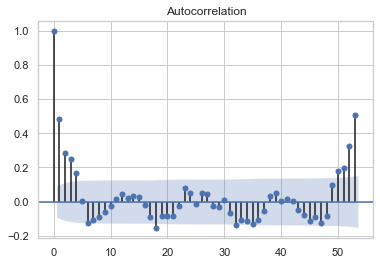

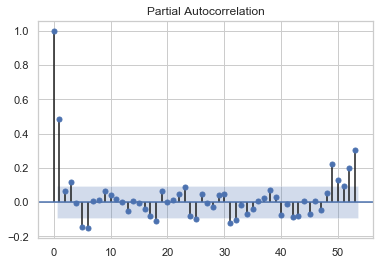

In [58]:
# Let's plot ACF and PACF grapgs to check auto correlation lagged values:

X = pd.Series(grouped_week.iloc[:,1])
plt.figure(figsize=(10,4))

# Compute and plot the ACF for the time series
tsa.plot_acf(X, lags=53, alpha=0.05)
tsa.plot_pacf(X, lags=53, alpha=0.05)
plt.show()

So for white noise, the autocorrelation function (ACF) is zero for all non-zero lags. In other words, past values are not 
correlated with present values at all, making the series a sequence of independent, uncorrelated values.

However, in reality, the value of correlation will not exactly be equal to zero. Hence, using hypothesis testing,we can check 
if it is significantly different from zero with 95 % confidence intervals.

## Time Series Forecasting with SARIMA

SARIMA is used for non-stationary series, that is, where the data do not fluctuate around the same mean, variance and co-variance. This model can identify trend and seasonality, which makes it so important. 

### *Strategy for splitting the data into train and test :*

In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model.  
**These methods cannot be directly used with time series data.**  

This is because they assume that there is no relationship between the observations, that each observation is independent.  
This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed. 

As per the problem statement **"Keep 1 month of gap between training and forecasting and then forecast for 3 months by each channel/week/Class ID level"** , so we will be following the same.


In [59]:
# Let's divide the data into the train and test :
total_timeser = grouped_week.num_units
series = grouped_week.num_units

n_records = len(series)
i = 430

# Creating train and test split and keeping 4 weeks(1 month) gap between both :
# Predicting for next 3 months (13 weeks)
train, test = series[0:i], series[i+4:i+17]

In [60]:
train.tail()

425     892779
426     747353
427     720369
428     853684
429    1053101
Name: num_units, dtype: int64

Total Observations in weeks: 448
Training Observations in weeks: 430
Testing Observations in weeks: 13


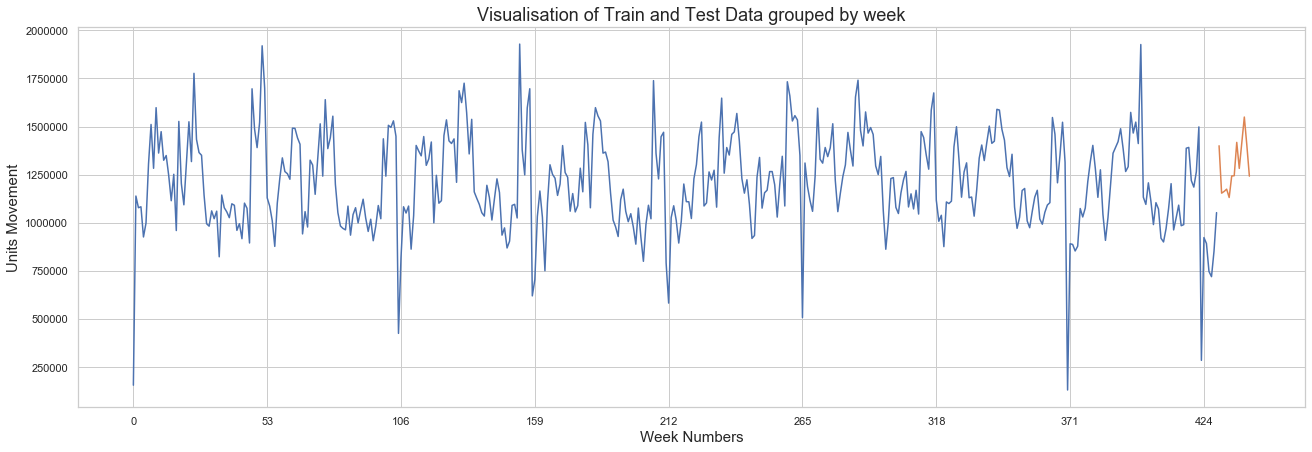

In [61]:
print('Total Observations in weeks: %d' % (len(series)))
print('Training Observations in weeks: %d' % (len(train)))
print('Testing Observations in weeks: %d' % (len(test)))
plt.figure(figsize=(22,7))
plt.title('Visualisation of Train and Test Data grouped by week',  size=18)

# Creating custom tick for x-axis week number :
tick_spacing = 53
x_ticks = np.arange(0, 448,tick_spacing)
plt.xticks(x_ticks)

#plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Week Numbers",  size=15)
plt.ylabel("Units Movement",  size=15)
plt.plot(train, label = 'train')

plt.plot([None for i in train] + [x for x in test], label = 'test')
plt.show()

**_Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as unit movements per week are always shoot up during the end of current and start of new year. Also, apart from this, here always 2-3 spikes can be observed within any single year with a couple of low months in the mid of the year._**  
  
_The higher unit movement suggests that these dates are important for multi-channel retailers for their inventory planning, 
logistics arrangement, promotion setup and marketting to get the best out of these important dates.  
For an instance the spike towards the end of year suggests important dates like Halloween, Black Friday, Cyber Monday, Christmas Day, Boxing Day etc. in last 3 quarter of the every year._

In [62]:
# An additive model is linear where changes over time are consistently made by the same amount.

# This looks more like additive a time series and not muktiplicative.
# A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles), below is the component of 
# a typical additive model:

# y(t) = Level + Trend + Seasonality + Noise

#### Decomposition as a Tool

Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem.  
It provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.  

Each of these components are something you may need to think about and address during data preparation, model selection, and model tuning. You may address it explicitly in terms of modeling the trend and subtracting it from your data, or implicitly by providing enough history for an algorithm to model a trend if it may exist.

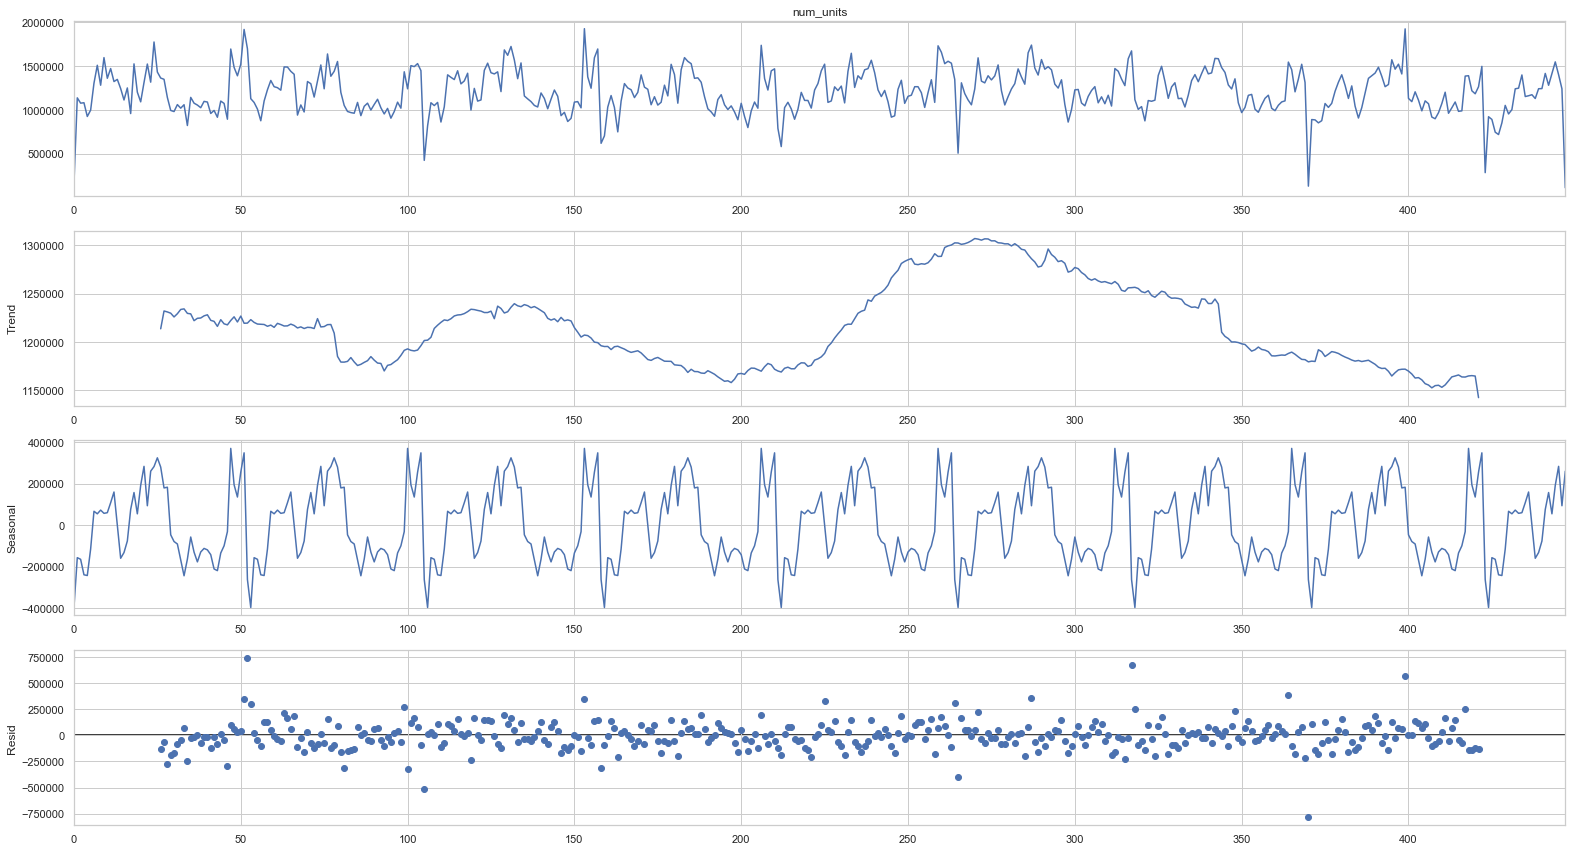

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 22, 12

# Decomposition at the annual level :
decomposition = seasonal_decompose(X, model='additive',freq=53)
fig = decomposition.plot()
#plt.figure(figsize=(20,14))

plt.show()

We can see that the trend and seasonality information extracted from the series does seem reasonable.  
  
**_There is no linear trend as such, also the residual seems to be present across the time frame.  
Also, the seasonal component is very evident and its repeating every year clearly._**



### Time series forecasting with ARIMA and SARIMAX:

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.  
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.  
SARIMAX tool in Python helps us to estimate a series by incorporating the seasonal and trend effects together in a model.

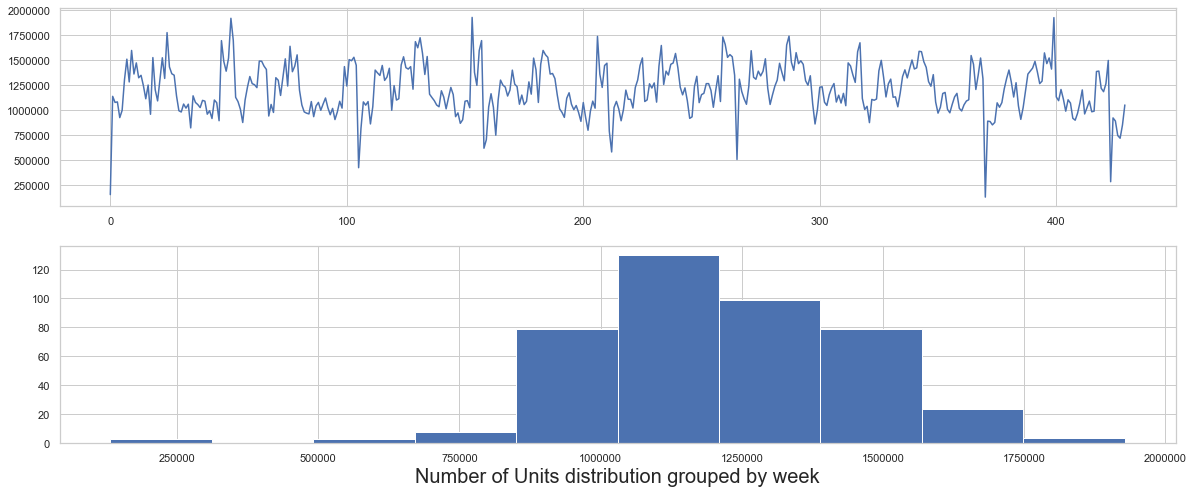

In [64]:
plt.figure(figsize=(20, 8))

plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(train)
# histogram
plt.subplot(212)
plt.hist(train)
plt.xlabel('Number of Units distribution grouped by week',fontsize=20)
plt.show()

In [65]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 13) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 13)
SARIMAX: (0, 0, 1) x (0, 1, 0, 13)
SARIMAX: (0, 1, 0) x (0, 1, 1, 13)
SARIMAX: (0, 1, 0) x (1, 0, 0, 13)


In [66]:
#iteration over all the combinations of (p,d,q)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}13 - AIC:{} - BIC:{}'.format(param, param_seasonal, round(results.aic,4), round(results.bic,4)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 13)13 - AIC:13255.1699 - BIC:13259.2314
ARIMA(0, 0, 0)x(0, 0, 1, 13)13 - AIC:12609.6335 - BIC:12617.6949
ARIMA(0, 0, 0)x(0, 1, 0, 13)13 - AIC:11754.4879 - BIC:11758.5185
ARIMA(0, 0, 0)x(0, 1, 1, 13)13 - AIC:11223.4872 - BIC:11231.485
ARIMA(0, 0, 0)x(1, 0, 0, 13)13 - AIC:11787.5008 - BIC:11795.567
ARIMA(0, 0, 0)x(1, 0, 1, 13)13 - AIC:11658.3208 - BIC:11670.4128
ARIMA(0, 0, 0)x(1, 1, 0, 13)13 - AIC:11306.8774 - BIC:11314.8802
ARIMA(0, 0, 0)x(1, 1, 1, 13)13 - AIC:11211.834 - BIC:11223.8308
ARIMA(0, 0, 1)x(0, 0, 0, 13)13 - AIC:12934.2371 - BIC:12942.3553
ARIMA(0, 0, 1)x(0, 0, 1, 13)13 - AIC:12478.7599 - BIC:12490.8447
ARIMA(0, 0, 1)x(0, 1, 0, 13)13 - AIC:11629.6431 - BIC:11637.6997
ARIMA(0, 0, 1)x(0, 1, 1, 13)13 - AIC:11134.4269 - BIC:11146.4162
ARIMA(0, 0, 1)x(1, 0, 0, 13)13 - AIC:12489.8632 - BIC:12501.9625
ARIMA(0, 0, 1)x(1, 0, 1, 13)13 - AIC:12426.18 - BIC:12442.2932
ARIMA(0, 0, 1)x(1, 1, 0, 13)13 - AIC:11227.0246 - BIC:11239.0288
ARIMA(0, 0, 1)x(1, 1, 1, 13)13

In [68]:
# According to Peterson, T. (2014) the AIC (Akaike information criterion) is an estimator of the relative quality of statistical 
# models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, 
# relative to each of the other models. The lower AIC value the better. 
# Our output suggests that SARIMAX(1, 1, 1)x(0, 1, 1, 13)
# with AIC value of 11065.2435 is the best combination, so we should consider this to be optimal option.

In [69]:
# by using best P D Q values for order and seasonal order, building the final forecast model
arima_model_train = sm.tsa.statespace.SARIMAX(train,
                                             order=(1, 1, 1),
                                             seasonal_order= (0, 1, 1, 13),
                                              enforce_stationarity= False,
                                         enforce_invertibility=False)
results_arima_train= arima_model_train.fit()

print(results_arima_train.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          num_units   No. Observations:                  430
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 13)   Log Likelihood               -5528.622
Date:                            Tue, 02 Jun 2020   AIC                          11065.244
Time:                                    12:26:47   BIC                          11081.219
Sample:                                         0   HQIC                         11071.570
                                            - 430                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3945      0.144      2.746      0.006       0.113       0.676
ma.L1         -0.8279      0.100   

In [70]:
# The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus
# our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each
# one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a 
# p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

# When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure
# that none of the assumptions made by the model have been violated. 

# The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

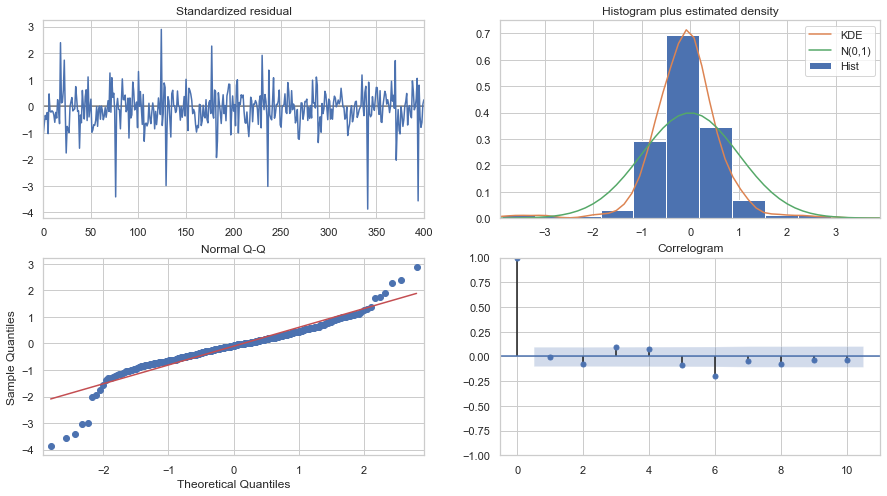

In [71]:
# plotting the predicted diagnostics
results_arima_train.plot_diagnostics(figsize=(15,8))
plt.show()

### Interepretation of the plot_diagnostics :  
  
**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance. 
If we see the top left graph, we cannot find any distinguished pattern for seasonality. It appears as white noise and since, the ACF plot has all the values under the confidence interval, it can be established that the values do not have any relationship with the past values.   
The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise.  
  
**Top Right:** The density plot suggest normal distribution with mean almost equal to zero.  
In the top right plot, we can see that the red line follows the green line which is the normal distribution with mean 0 and standard deviation of 1 but not in a close fashion.
    
**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.  
As it can be seen in the plot above, the QQ plot for 'noise' closely follows the path of line y=x upto much extent. Based on this, you can say that the series 'noise' follows a normal distribution.    
  
**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model.   
With the diagnostic above we can visualize important information as the distribution and the Auto correlation function ACF (correlogram). Values upward the “0” has some correlation over the time series data. Values near to “1” demonstrates strongest correlation.  
This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself. 95% of correlations for lag greater than one should not be significant. 
  
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values. However, one can always find some scope of improvement in the model obtained.    

Overall, it seems to be a good fit. Let’s forecast.  


In [72]:
# Predicted values based on ARIMA model:

# Train data prediction 
pred_arima_train = results_arima_train.get_prediction(dynamic=False)
pred_arima_train_ci = pred_arima_train.conf_int()

nforecast = 12
# Test Data Prediction :
pred_arima_test = results_arima_train.get_prediction(start=434,end=434 + nforecast, dynamic=False)
pred_arima_test_ci = pred_arima_test.conf_int()

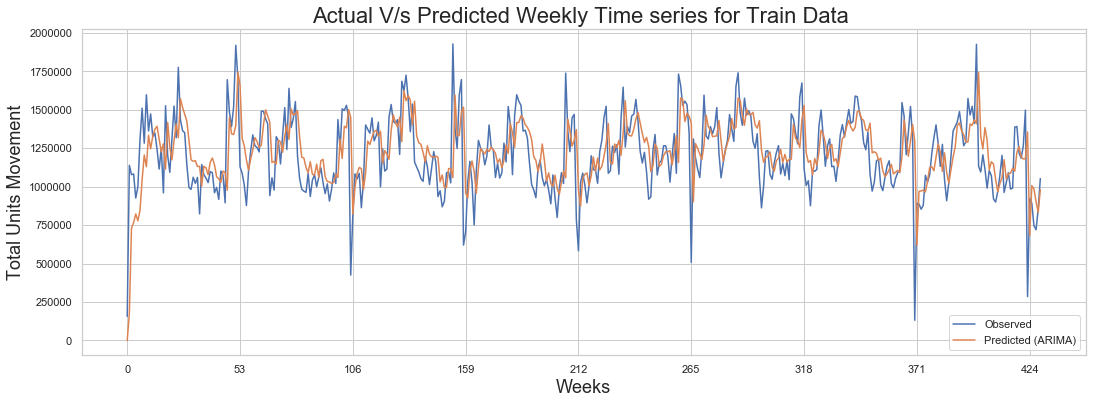

In [73]:
#Plotting the predicted and actual data together

plt.figure(figsize = (18,6))

tick_spacing = 53
x_ticks = np.arange(0, 448,tick_spacing)
plt.xticks(x_ticks)

plot1 = train.plot(label='Observed')
pred_arima_train.predicted_mean.plot(ax=plot1, label='Predicted (ARIMA)')

plt.title("Actual V/s Predicted Weekly Time series for Train Data ", size = 22)
plt.xlabel('Weeks', size = 18)
plt.ylabel('Total Units Movement', size = 18)
plt.legend(loc = 'best')
plt.show()

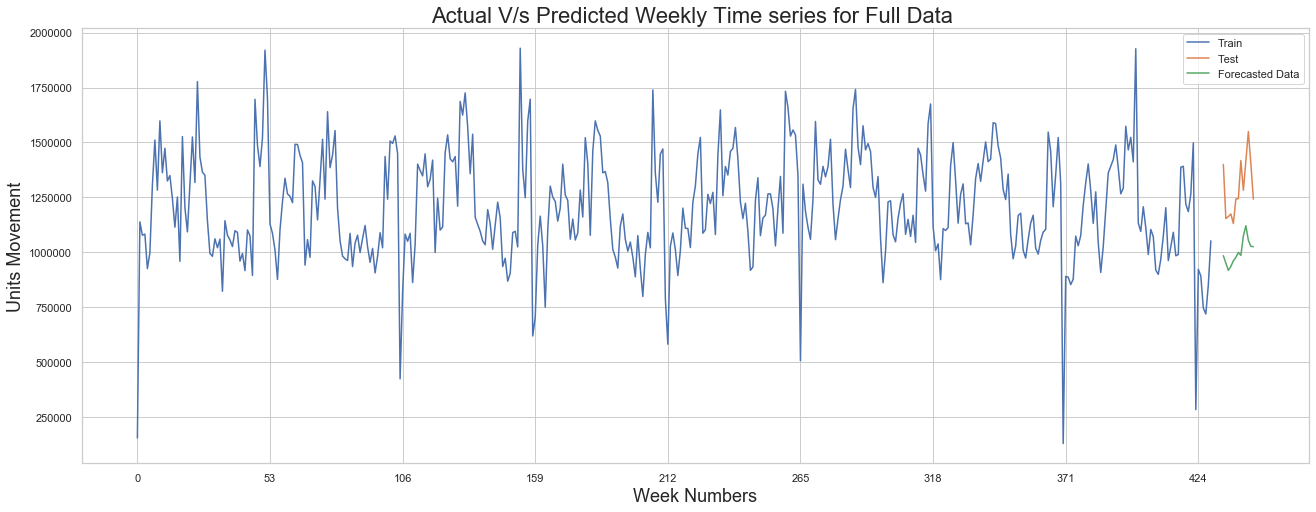

In [74]:
# Predicting the test part of the time series to see how effective our prediction is:
plt.figure(figsize = (22,8))

# Creating custom tick for x-axis week number so that we have data by each year :
tick_spacing = 53
x_ticks = np.arange(0, 448,tick_spacing)
plt.xticks(x_ticks)

plt.title("Actual V/s Predicted Weekly Time series for Full Data ", size = 22)

plt.xlabel("Week Numbers",  size=18)
plt.ylabel("Units Movement",  size=18)

# Train plot :
plt.plot(train, label = 'Train')

# Test and Forecast Plot:
plot2 = test.plot(label='Test')
pred_arima_test.predicted_mean.plot(ax=plot2, label='Forecasted Data')

plt.legend(loc = 'best')
plt.show()

The line plot is showing the observed values in validation timesapce compared to the forecast predictions. Overall, our 
forecasts align with the true values very well, and captured the seasonality as well.

In [75]:
#Comparing the predicted values with the actual values:
index = np.arange(13)
classical_compare = pd.DataFrame(columns = ['Actual', 'Predicted'], index = index)
for i in range(len(test)):
    classical_compare['Actual'][i] = test.iloc[i]
    classical_compare['Predicted'][i] = round((pred_arima_test.predicted_mean.iloc[i]),0)

# Forcing panda to use the non-scientific notation :
classical_compare['Predicted'] = classical_compare['Predicted'].astype('int64')    
print(classical_compare)

     Actual  Predicted
0   1400415     985447
1   1154174     951614
2   1163143     918676
3   1174990     936547
4   1131622     962135
5   1243246     977935
6   1244912     999956
7   1418013     986736
8   1282810    1075008
9   1416651    1121674
10  1549655    1055050
11  1402784    1027856
12  1242558    1026453


In [76]:
# create copy of data frame :
classical_compare_save = classical_compare

# Create list of the index from test data :
index_list = test.index.values.tolist()

# Change the index to denote week numbers:
classical_compare_save.index = index_list
classical_compare_save

Actual  Predicted
434  1400415     985447
435  1154174     951614
436  1163143     918676
437  1174990     936547
438  1131622     962135
439  1243246     977935
440  1244912     999956
441  1418013     986736
442  1282810    1075008
443  1416651    1121674
444  1549655    1055050
445  1402784    1027856
446  1242558    1026453

**_Submission of results from model:_**

In [77]:
# Saving the data to the csv file : 
classical_compare_save.to_csv("weekly_forecast_sarima.csv", encoding='utf-8', index=True, index_label='Week_Number')

### Model Evaluation using MAPE:  
Mean absolute percentage error (MAPE) loss is a metric that can be used to evaluate the SARIMA model. For each predicted data point, the absolute difference from the corresponding test point was calculated, and then divided by the test point. The average percentage gives the MAPE.  

In [78]:
# Calculating MAPE on test:

arima_pred_test = pred_arima_test.predicted_mean[:]

n = len(arima_pred_test)
total = 0
for i in range(n):
    total = total + np.absolute((100*(test.iloc[i] - arima_pred_test.iloc[i])/test.iloc[i]))

MAPE = total/n
print("MAPE Value: {}".format(round(MAPE,4)))

MAPE Value: 22.1507


**The MAPE value comes out to be 22.1507%  which signifies that it is just decent fit for the model.**  
This means that this model can forecast correctly with an average of 78 % for the given time period.

In [79]:
# Save the model as a pickle in a file 
joblib.dump(pred_arima_train, 'Time_Series_Model_Weekly_Forecast.pkl')

['Time_Series_Model_Weekly_Forecast.pkl']

## Time Series Forecasting with FBprophet:  

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.  
  
It provides intuitive parameters which are easy to tune. Even someone who lacks deep expertise in time-series forecasting models can use this to generate meaningful predictions for a variety of problems in business scenarios.

**Prophet requires the variable names in the time series to be:**  
y – Target  
ds – Datetime  


So, the next step is to convert the dataframe according to the above specifications  

In [81]:
# Take the back up of the original dataframe :
grouped_week_prophet = grouped_week.copy()
grouped_week_prophet.head()

week_period  num_units
0       201101     156515
1       201102    1139193
2       201103    1078632
3       201104    1083395
4       201105     926647

In [82]:
grouped_week_prophet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448 entries, 0 to 447
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   week_period  448 non-null    int64
 1   num_units    448 non-null    int64
dtypes: int64(2)
memory usage: 10.5 KB


In [83]:
# grouped_week_prophet = pd.to_datetime(grouped_week_prophet.ds.add('-0'), format='%Y-%W-%w')

# First find week and year number from the dataframe :
grouped_week_prophet.week_period = grouped_week_prophet.week_period.astype(str)
grouped_week_prophet['Year'] = grouped_week_prophet['week_period'].str.slice(0,4)
grouped_week_prophet['Week'] = grouped_week_prophet['week_period'].str.slice(4,6)

grouped_week_prophet.head()

week_period  num_units  Year Week
0      201101     156515  2011   01
1      201102    1139193  2011   02
2      201103    1078632  2011   03
3      201104    1083395  2011   04
4      201105     926647  2011   05

In [86]:
# Info of dataframe :
grouped_week_prophet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448 entries, 0 to 447
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   week_period  448 non-null    object
 1   num_units    448 non-null    int64 
 2   Year         448 non-null    object
 3   Week         448 non-null    object
dtypes: int64(1), object(3)
memory usage: 17.5+ KB


In [87]:
# Now inorder to use the prophet the ds should be of data-type timestamp , converting the same :
grouped_week_prophet['ds'] = pd.to_datetime(grouped_week_prophet.Week.astype(str)+
                           grouped_week_prophet.Year.astype(str).add('-1') ,format='%V%G-%u')

grouped_week_prophet.head()

week_period  num_units  Year Week         ds
0      201101     156515  2011   01 2011-01-03
1      201102    1139193  2011   02 2011-01-10
2      201103    1078632  2011   03 2011-01-17
3      201104    1083395  2011   04 2011-01-24
4      201105     926647  2011   05 2011-01-31

In [1026]:
# We need only 2 columns for the prophet :
grouped_week_prophet = grouped_week_prophet.drop(grouped_week_prophet.columns[[0, 2, 3]], axis=1)  # df.columns is zero-based pd.Index
grouped_week_prophet.head()

num_units         ds
0     156515 2011-01-03
1    1139193 2011-01-10
2    1078632 2011-01-17
3    1083395 2011-01-24
4     926647 2011-01-31

In [88]:
# rearranging columns order for prophet :
grouped_week_prophet = grouped_week_prophet[['ds','num_units']]

grouped_week_prophet.head()

ds  num_units
0 2011-01-03     156515
1 2011-01-10    1139193
2 2011-01-17    1078632
3 2011-01-24    1083395
4 2011-01-31     926647

In [92]:
# Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into 
# the model.

# Format data for prophet model using ds and y
grouped_week_prophet.rename(columns={'num_units':'y'},inplace=True)

In [93]:
# Finally, we have the data in required format for fb prophet :
grouped_week_prophet.head()

ds        y
0 2011-01-03   156515
1 2011-01-10  1139193
2 2011-01-17  1078632
3 2011-01-24  1083395
4 2011-01-31   926647

In [94]:
# Dividing the data into train and test :
# Let's divide the data into the train and test :

#total_timeser = grouped_week_prophet.y
#series = grouped_week_prophet.y
series = grouped_week_prophet
n_records = len(grouped_week_prophet)
i = 430

# Creating train and test split and keeping 4 weeks(1 month) gap between both :
# Predicting for next 3 months (13 weeks)
train, test = series[0:i], series[i+4:i+17]

In [99]:
# Prophet Model 1 :

# Prediction using the deafult prophet model :

# ‘interval_width=0.90’, this sets the uncertainty interval to produce a confidence interval around the forecast.
prophet_basic = Prophet(interval_width=0.90) # default value is 0.80
prophet_basic.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [100]:
future= prophet_basic.make_future_dataframe(periods=18)
future.tail(2)

ds
446 2019-02-21
447 2019-02-22

In [101]:
forecast=prophet_basic.predict(future)

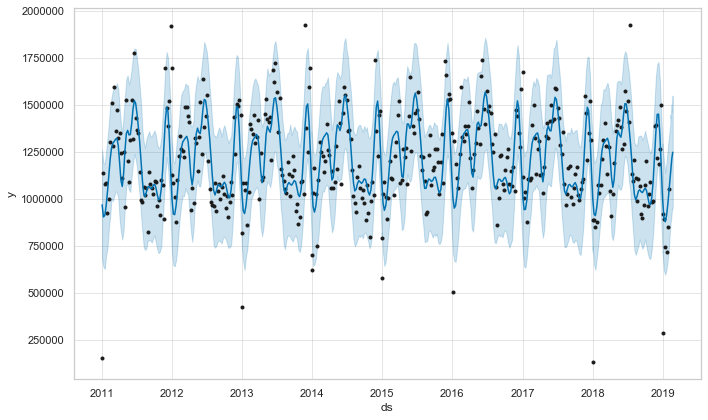

In [102]:
# Plotting the predicted data using base model:
fig1 =prophet_basic.plot(forecast)

It’s always nice to check how does the model perform on historical data. (Deep blue line is forecasting spend numbers, black dots are actually spend numbers. The light blue shade is 90% confidence interval around the forecast.) From the plot, thought the model tries to fit all data point smoothly but it fails to catch the seasonality. The first model is not doing a good job on fitting the data just by applying Prophet itself.  
For second model, let’s apply some business insights to tweak the first model. Just asking some business questions such as seasonality trends and holiday event affects, it’s easy to input those information into Prophet.

### Plotting the forecasted components
We can plot the trend and seasonality, components of the forecast.

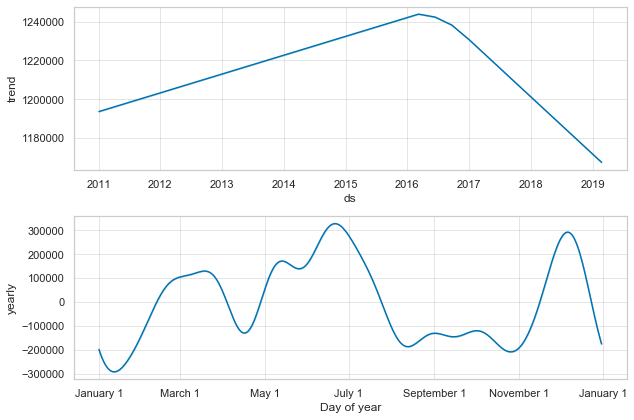

In [103]:
fig1 = prophet_basic.plot_components(forecast)

### Adding ChangePoints to Prophet
Changepoints are the datetime points where the time series have abrupt changes in the trajectory.
If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible.
Let’s plot the vertical lines where the potential changepoints occurred

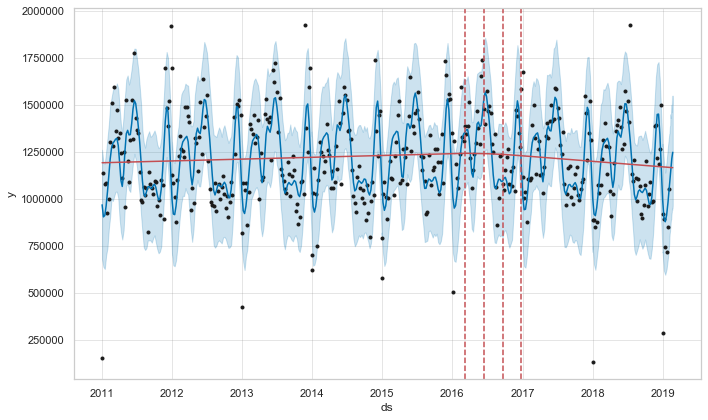

In [104]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [105]:
# Finding the change points :
prophet_basic.changepoints

14    2011-04-11
27    2011-07-11
41    2011-10-17
55    2012-01-16
69    2012-04-23
82    2012-07-23
96    2012-10-29
110   2013-01-28
123   2013-04-29
137   2013-08-05
151   2013-11-11
165   2014-02-10
178   2014-05-12
192   2014-08-18
206   2014-11-24
220   2015-02-23
233   2015-05-25
247   2015-08-31
261   2015-12-07
274   2016-03-07
288   2016-06-13
302   2016-09-19
316   2016-12-26
329   2017-03-20
343   2017-06-26
Name: ds, dtype: datetime64[ns]

In [106]:
# The number of changepoints can be set by using the n_changepoints parameter when initializing prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


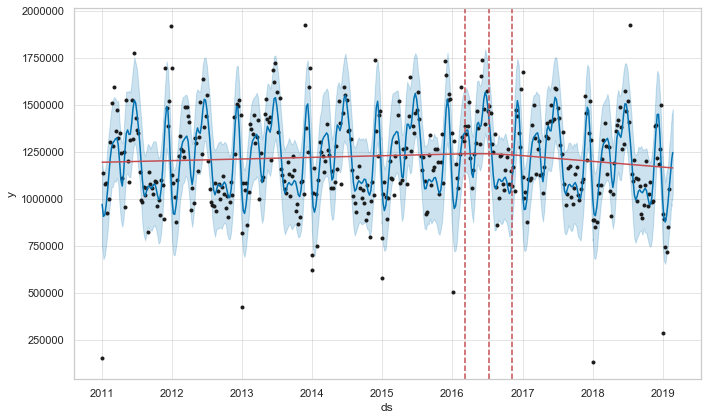

In [1039]:
# Prophet Model 2: 
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True)

forecast = pro_change.fit(train).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

### Adjusting Trend
Prophet allow you to adjust the trend in case there is an overfit or underfit. changepoint_prior_scale helps adjust the strength of the trend.
Default value for changepoint_prior_scale is 0.05. Decrease the value to make the trend less flexible. Increase the value of changepoint_prior_scale to make the trend more flexible.
Increasing the changepoint_prior_scale to 0.08 to make the trend flexible

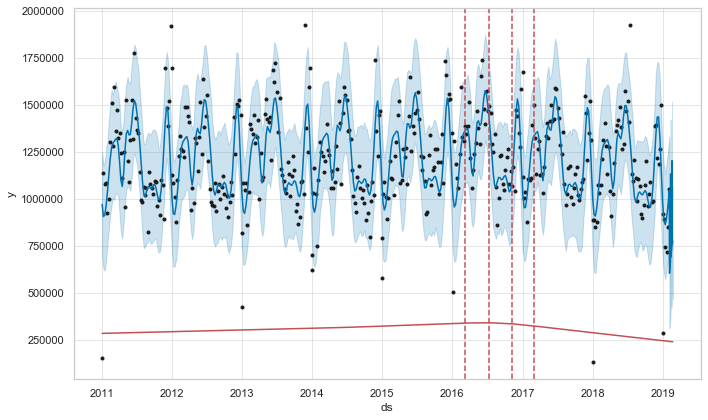

In [107]:
# Prophet Model 3 :

pro_change= Prophet(interval_width=0.90, n_changepoints=20, yearly_seasonality=True, weekly_seasonality=True ,
                     daily_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

### Adding Holidays effect in timeseries:

Holidays and events can cause changes to a time series. 
We can create our custom holiday list in dataframe or use the existing built-in holiday function for many countries or use pandas holiday calendar.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


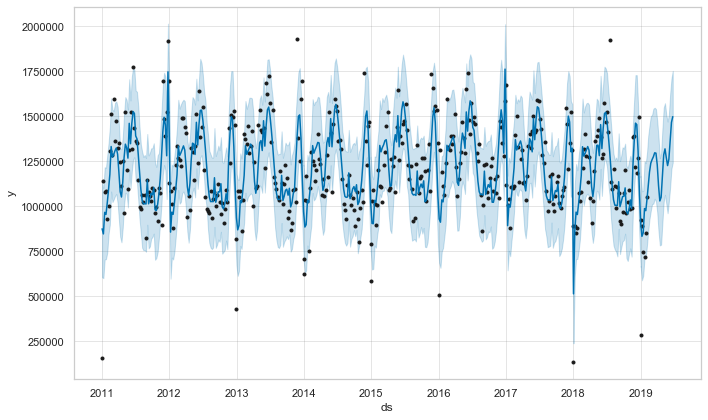

In [108]:
# Prophet Model 4  :
# Using the built in prophet US holiday list :
pro_holiday= Prophet(interval_width=0.90, n_changepoints=20, yearly_seasonality=True,changepoint_prior_scale=0.08)

pro_holiday.add_country_holidays(country_name='US')
pro_holiday.fit(train)

#  We've instantiated the model, now we need to build some future dates to forecast into.
# Predicting for next 20 weeks 
future_data = pro_holiday.make_future_dataframe(periods=20, freq = 'w')
 
# forecast the data for future data, To forecast this future data, we need to run it through Prophet's model:
forecast_data = pro_holiday.predict(future_data)
pro_holiday.plot(forecast_data);

From the plot, it seems that the second model is able to catch the seasonality and fit historical data very well.
(Deep blue line is forecasting spend numbers, black dots are actually spend numbers. 
 The light blue shade is 90% confidence interval around the forecast.)

In [109]:
future_data.tail(2)

ds
448 2019-06-16
449 2019-06-23

In [110]:
# listing down the holidays added in model :
pro_holiday.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

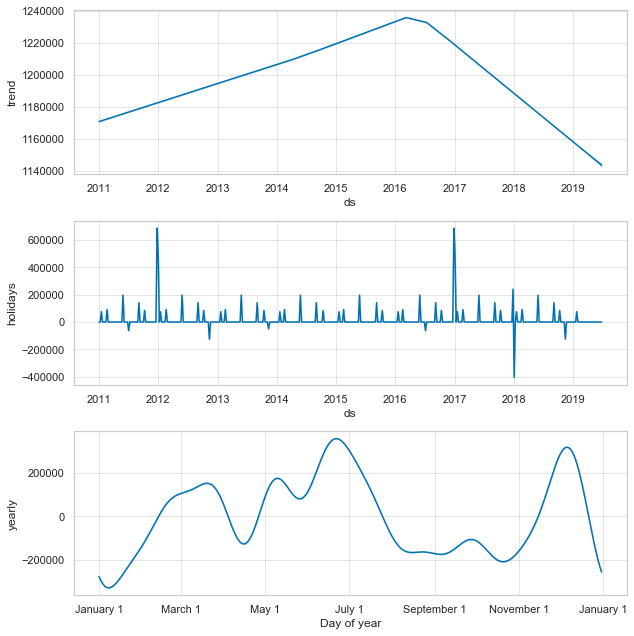

In [111]:
# Check the trends and seasonality components:
fig1 = pro_holiday.plot_components(forecast_data)

### Inference from Prophet predictions:   

If we see **overall trend** this is non-linear trend of unit movement. The units movement increase from 2011 and reached its peak in the year 2016-17 and there is continuous downward trend in the same from post this till the year 2019. This was confirmed by the changepoint plot as well.
  
From the **yearly trend or seasonality**, unit movement more or less resonates the US public holidays and ecommerce events as below:    
  
*_Valentine's Day – February    
St. Patrick's Day - March  
Easter - April  
Mother's Day - May  
Memorial Day - May  
Father's Day - June  
Back to school (August 1 through Labour Day)  
Halloween - October  
Veteran's Day - Novemeber  
Thanksgiving Day - Novemeber  
Black Friday - November  
Cyber Monday - November  
Christmas- December  
Boxing Day - December_*  
  
The unit movement is highest from Nov and early Jan every year, similarly around June ; this is flat and low across the month from August to October.    

Also, the effect of the **holiday** was highest for the year 2012 and 2017, on the otherhand 2018 saw steep decline in the unit movement due to holidays. This suggest that the anticipated effect of holiday on the unit movement was not achieved in the year 2018.  
  

### Evaluating the Prophet Model :

Last but not least, we can evaluate the forecast using Prophet’s cross validation procedure.  
1. Use the cross_validation() function on the model and specify the forecast horizon with the horizon parameter.  
2. Next, call performance_metrics() to get a table with various prediction performance metrics.  


In [112]:
forecast_data.tail(2)

ds         trend    yhat_lower    yhat_upper   trend_lower  \
448 2019-06-16  1.144049e+06  1.208950e+06  1.710075e+06  1.143162e+06   
449 2019-06-23  1.143466e+06  1.242311e+06  1.753128e+06  1.142461e+06   

      trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
448  1.145098e+06            0.0                  0.0                  0.0   
449  1.144597e+06            0.0                  0.0                  0.0   

     Christmas Day (Observed)  ...  holidays  holidays_lower  holidays_upper  \
448                       0.0  ...       0.0             0.0             0.0   
449                       0.0  ...       0.0             0.0             0.0   

            yearly   yearly_lower   yearly_upper  multiplicative_terms  \
448  322242.853453  322242.853453  322242.853453                   0.0   
449  354716.392852  354716.392852  354716.392852                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
448                         0.0                         0.0  1.466292e+06  
449                         0.0                         0.0  1.498183e+06  

[2 rows x 61 columns]

### Evaluation using the Naive Method :

In [114]:
# Let's start with the naive method first. 

def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [115]:
# To do this, we need to build a combined dataframe with yhat from the forecasts and the original 'y' values from the data.
# Let's apply this function to our last forecast:

cmp_df = make_comparison_dataframe(grouped_week_prophet, forecast_data)
cmp_df.tail(n=5)

yhat    yhat_lower    yhat_upper   y
ds                                                      
2019-05-26  1.226168e+06  9.608579e+05  1.471035e+06 NaN
2019-06-02  1.261222e+06  1.025244e+06  1.509833e+06 NaN
2019-06-09  1.366354e+06  1.106719e+06  1.625333e+06 NaN
2019-06-16  1.466292e+06  1.208950e+06  1.710075e+06 NaN
2019-06-23  1.498183e+06  1.242311e+06  1.753128e+06 NaN

In [116]:
# You can see from the above, that the last part of the dataframe has "NaN" for 'y'...that's fine because we are only concerend
# about checking the forecast values versus the actual values so we can drop these "NaN" values.
cmp_df.dropna(inplace=True)

In [117]:
cmp_df.tail(5)

yhat     yhat_lower    yhat_upper          y
ds                                                              
2019-01-07  8.324407e+05  587894.846843  1.083084e+06   892779.0
2019-01-14  8.522667e+05  613625.136896  1.085419e+06   747353.0
2019-01-21  9.871876e+05  710586.475131  1.251423e+06   720369.0
2019-01-28  9.753306e+05  718374.620327  1.239183e+06   853684.0
2019-02-04  1.044209e+06  789187.903141  1.303533e+06  1053101.0

In [118]:
# Accuracy metrics used :
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mpe = np.mean((forecast - actual)/actual)   # MPE

    return({'MAPE':mape, 
            'MPE': mpe})

forecast_accuracy(cmp_df.yhat, cmp_df.y)

{'MAPE': 0.13659045278388404, 'MPE': 0.05221784100251159}

#### As a result, the relative error of our forecast (MAPE) is about 13.65%.

### Model Evaluation using the fbprophet cross_validation and performance_metrics:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


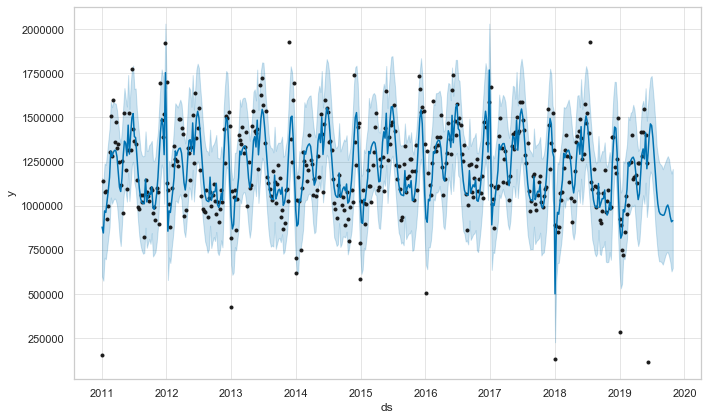

In [119]:
# Using the built in prophet US holiday list :
pro_holiday_full= Prophet(interval_width=0.90, n_changepoints=20, yearly_seasonality=True,changepoint_prior_scale=0.08)

pro_holiday_full.add_country_holidays(country_name='US')
pro_holiday_full.fit(grouped_week_prophet)

#  We've instantiated the model, now we need to build some future dates to forecast into.
# Predicting for next 20 weeks 
future_data_full = pro_holiday_full.make_future_dataframe(periods=20, freq = 'w')
 
# forecast the data for future data, To forecast this future data, we need to run it through Prophet's model:
forecast_data_full = pro_holiday_full.predict(future_data_full)
pro_holiday_full.plot(forecast_data_full);

In [120]:
# Using the built-in cross_validation() of fbprophet :
cv_results = cross_validation(pro_holiday_full, initial = pd.to_timedelta(420,unit="w"),period=pd.to_timedelta(53,unit="w"),
                             horizon = pd.to_timedelta(17,unit="w"))

cv_results.tail()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-11 00:00:00 and 2019-02-11 00:00:00


ds          yhat    yhat_lower    yhat_upper        y     cutoff
12 2019-05-13  1.311578e+06  1.064464e+06  1.559155e+06  1416651 2019-02-11
13 2019-05-20  1.259019e+06  9.951854e+05  1.507811e+06  1549655 2019-02-11
14 2019-05-27  1.411907e+06  1.142990e+06  1.669917e+06  1402784 2019-02-11
15 2019-06-03  1.269711e+06  1.003908e+06  1.500130e+06  1242558 2019-02-11
16 2019-06-10  1.378270e+06  1.134419e+06  1.631003e+06   113026 2019-02-11

In [121]:
# performance_metrics:
performance_metrics_results = performance_metrics(cv_results)
print(performance_metrics_results)

    horizon           mse          rmse           mae       mape      mdape  \
0    7 days  7.721025e+10  2.778673e+05  2.778673e+05   0.276505   0.276505   
1   14 days  4.949277e+07  7.035110e+03  7.035110e+03   0.005662   0.005662   
2   21 days  6.756766e+07  8.219955e+03  8.219955e+03   0.006578   0.006578   
3   28 days  1.557891e+10  1.248155e+05  1.248155e+05   0.089128   0.089128   
4   35 days  1.980543e+10  1.407318e+05  1.407318e+05   0.121933   0.121933   
5   42 days  1.458468e+10  1.207671e+05  1.207671e+05   0.103828   0.103828   
6   49 days  1.167853e+09  3.417387e+04  3.417387e+04   0.029084   0.029084   
7   56 days  1.402905e+09  3.745537e+04  3.745537e+04   0.033099   0.033099   
8   63 days  4.931901e+10  2.220788e+05  2.220788e+05   0.178628   0.178628   
9   70 days  3.524309e+10  1.877314e+05  1.877314e+05   0.150799   0.150799   
10  77 days  5.672641e+10  2.381731e+05  2.381731e+05   0.167963   0.167963   
11  84 days  6.607223e+07  8.128482e+03  8.128482e+0

In [122]:
# Let's check the average MAPE found using the fbprophet evaluation metrics for the next 3 months(90 days horizon) :
mape_result = performance_metrics_results.iloc[0:13,4]
MAPE = mape_result.mean()
print("\nMAPE for next 91 days is :",MAPE )
#performance_metrics_results["mape"].mean(axis=0)


MAPE for next 91 days is : 0.09567023993470691


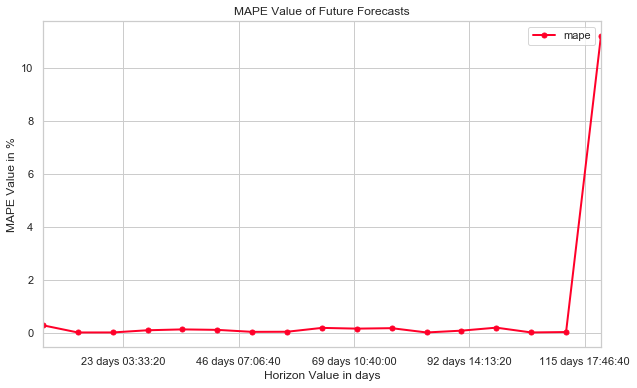

In [1056]:
# Plotting the MAPE of the forecasted time period :
ax = performance_metrics_results.plot(figsize=(10,6),lw=2, colormap='gist_rainbow', marker='.', markersize=10, 
                                      title='MAPE Value of Future Forecasts',x ='horizon', y='mape')
ax.set_xlabel("Horizon Value in days")
ax.set_ylabel("MAPE Value")


plt.show()

#### So, our model is able to forecast with good MAPE of 9.56 % for around 3 months (91 days) which is impressive.
This means that model can forecast correctly with error of <10 % for 3 months.

In [124]:
# Joining the test and predicted data on the timestamp ds:
joined_df = make_comparison_dataframe(test,cv_results)

# Also, we want to save result between week number 2019-03-11 and 2019-06-03 only , for 3 months as per requirement:
joined_df = joined_df.iloc[3:16,:]
joined_df.head(20)

yhat    yhat_lower    yhat_upper          y
ds                                                             
2019-03-11  1.275599e+06  1.023466e+06  1.523856e+06  1400415.0
2019-03-18  1.294906e+06  1.044440e+06  1.548954e+06  1154174.0
2019-03-25  1.283910e+06  1.014014e+06  1.538864e+06  1163143.0
2019-04-01  1.209164e+06  9.347090e+05  1.462740e+06  1174990.0
2019-04-08  1.094167e+06  8.246550e+05  1.353565e+06  1131622.0
2019-04-15  1.021167e+06  7.780529e+05  1.298938e+06  1243246.0
2019-04-22  1.057181e+06  7.926745e+05  1.307867e+06  1244912.0
2019-04-29  1.179840e+06  9.147780e+05  1.442985e+06  1418013.0
2019-05-06  1.290938e+06  1.035067e+06  1.571223e+06  1282810.0
2019-05-13  1.311578e+06  1.064464e+06  1.559155e+06  1416651.0
2019-05-20  1.259019e+06  9.951854e+05  1.507811e+06  1549655.0
2019-05-27  1.411907e+06  1.142990e+06  1.669917e+06  1402784.0
2019-06-03  1.269711e+06  1.003908e+06  1.500130e+06  1242558.0

In [125]:
# Forcing panda to use the non-scientific notation :
joined_df['yhat'] = joined_df['yhat'].astype('int64')  

# Renaming :
joined_df.rename(columns={'yhat':'Predicted', 'y':'Actual'},inplace=True)

# Drop columns not needed :
joined_df = joined_df.drop(joined_df.columns[[1, 2]], axis=1) 
joined_df.head()

Predicted     Actual
ds                              
2019-03-11    1275599  1400415.0
2019-03-18    1294905  1154174.0
2019-03-25    1283910  1163143.0
2019-04-01    1209163  1174990.0
2019-04-08    1094166  1131622.0

**_Submission of results from model:_**

In [126]:
# Saving the data to the csv file : 
joined_df.to_csv("weekly_forecast_fbprophet.csv", encoding='utf-8', index=True, index_label='Date_Week')

In [127]:
# Saving the model :
joblib.dump(pro_holiday_full, 'Time_Series_Model_Weekly_Forecast_FbProphet.pkl')

['Time_Series_Model_Weekly_Forecast_FbProphet.pkl']

**So the performance of the Fbprophet is better than the traditional SARIMA in terms of the MAPE evaluation.  
This bring us to the end of the forecasting at the week level for next 3 months**

## ----------------------------------------------------------------------------------------------------------------------------- ##

## 2.2 Weekly Total Unit Movement Forecasting at the Channel Level :

### EDA and Data preparation:
Please note that we have already accomplished the EDA at the beginning , so we will have another glance here.

In [128]:
# We have 3 different channels identified by the class_id :
feature_exploration('store_type')

2    45002
0    42973
1    42349
Name: store_type, dtype: int64

In [129]:
# Here 'ECOM':0, 'OUTLETS':1, 'RETAIL':2 according to the original data set.

In [130]:
# Checking the data:
data_units.head(2)

trans_year trans_week  class_id  store_type  num_units  week_period
0        2011         01       499           2     130329       201101
1        2011         01       499           0          5       201101

In [131]:
data_units.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130324 entries, 0 to 130323
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   trans_year   130324 non-null  int64 
 1   trans_week   130324 non-null  object
 2   class_id     130324 non-null  int64 
 3   store_type   130324 non-null  int64 
 4   num_units    130324 non-null  int64 
 5   week_period  130324 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 7.0+ MB


In [132]:
data_units_channel = data_units

In [133]:
# Creating a time stamp datatype :

# First find week and year number from the dataframe :
data_units_channel.week_period = data_units_channel.week_period.astype(str)
data_units_channel['Year'] = data_units_channel['week_period'].str.slice(0,4)
data_units_channel['Week'] = data_units_channel['week_period'].str.slice(4,6)

data_units_channel['ds'] = pd.to_datetime(data_units_channel.Week.astype(str)+
                           data_units_channel.Year.astype(str).add('-1') ,format='%V%G-%u')

data_units_channel.head()

trans_year trans_week  class_id  store_type  num_units week_period  Year  \
0        2011         01       499           2     130329      201101  2011   
1        2011         01       499           0          5      201101  2011   
2        2011         01       499           1      26152      201101  2011   
3        2011         01       616           2         28      201101  2011   
4        2011         01       615           2          1      201101  2011   

  Week         ds  
0   01 2011-01-03  
1   01 2011-01-03  
2   01 2011-01-03  
3   01 2011-01-03  
4   01 2011-01-03

In [134]:
# Dropping columns which are not needed :
data_units_channel = data_units_channel.drop(data_units_channel.columns[[0, 1, 2,5,6,7]], axis=1)  # df.columns is zero-based pd.Index
data_units_channel.head()

store_type  num_units         ds
0           2     130329 2011-01-03
1           0          5 2011-01-03
2           1      26152 2011-01-03
3           2         28 2011-01-03
4           2          1 2011-01-03

In [135]:
# rearranging columns  :
data_units_channel = data_units_channel[['ds','store_type','num_units']]
data_units_channel.head(2)

ds  store_type  num_units
0 2011-01-03           2     130329
1 2011-01-03           0          5

In [136]:
# Finding the count of unit movement :
df = data_units_channel.fillna('NA').groupby(['ds','store_type'])['num_units'].sum() \
                          .groupby(['ds','store_type']).max().sort_values() \
                          .groupby(['store_type']).sum().sort_values(ascending = False)

dfinfo = pd.DataFrame(df).head()
dfinfo

num_units
store_type           
2           389975026
0            90385603
1            61361285

In [137]:
# Type 2 i.e. Retail Stores is having the maximum units movement in the dataset given.

In [138]:
# Let's do quick visualisation :
fig = px.bar(dfinfo, x=dfinfo.index, y='num_units', labels={'x':'store_type'},
             color="num_units", color_continuous_scale=px.colors.sequential.Brwnyl)
fig.update_layout(title_text='Total Units Movement across the channels')
fig.show()

**Retail stores has maximum no of the units movement across the time and its more than twice the unit movement of the ecom and 
outlet channel combined.**

In [139]:
# Create aggregated dataframe based on sum of unit movement for time/week and the channel type :
channel_grouped=data_units_channel.groupby(['ds','store_type']).agg('sum').reset_index()
channel_grouped.tail(5)

ds  store_type  num_units
1318 2019-06-03           1     122807
1319 2019-06-03           2     789156
1320 2019-06-10           0        650
1321 2019-06-10           1      19083
1322 2019-06-10           2      93293

In [141]:
# Info of the dataframe :
channel_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          1323 non-null   datetime64[ns]
 1   store_type  1323 non-null   int64         
 2   num_units   1323 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 31.1 KB


In [142]:
# Let's visualise the time evaluation of each of these channels:

# Created function to plot the timeseries of each channel:
def pltChannel_units(num_units,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        channel=channel_grouped.loc[(channel_grouped['store_type']==a)]
        plt.plot(channel['ds'],channel['num_units'],linewidth=3,color='cyan')
        plt.xticks(rotation=40)
        plt.xlabel("Time in Years")
        plt.ylabel("Units Moved")
        plt.legend(labels)
        ax.set(title='Timeseries of the Channel' )

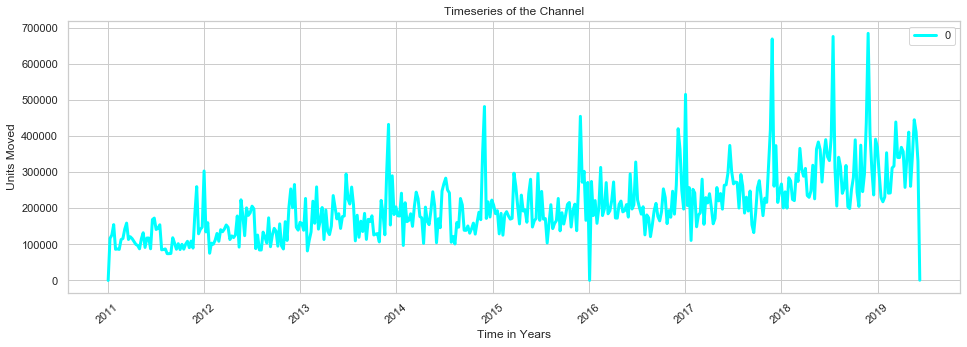

In [143]:
# Timeseries of the Channel 0 which is for the Ecommerce :
pltChannel_units('num_units',0)

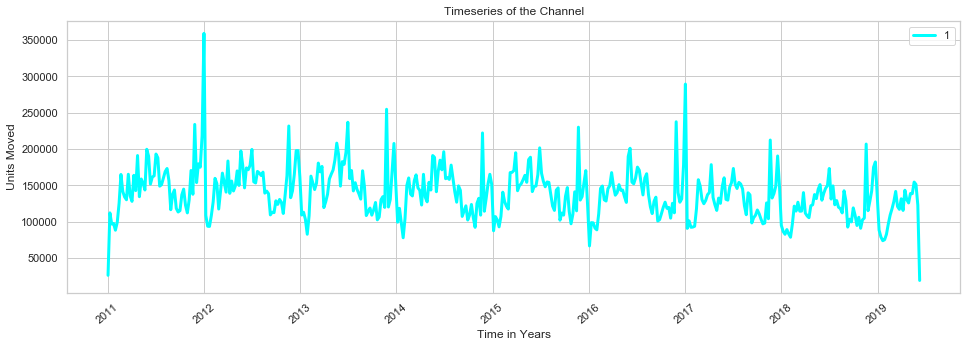

In [144]:
# Timeseries of the Channel 1 which is for the Outlet Channel :
pltChannel_units('num_units',1)

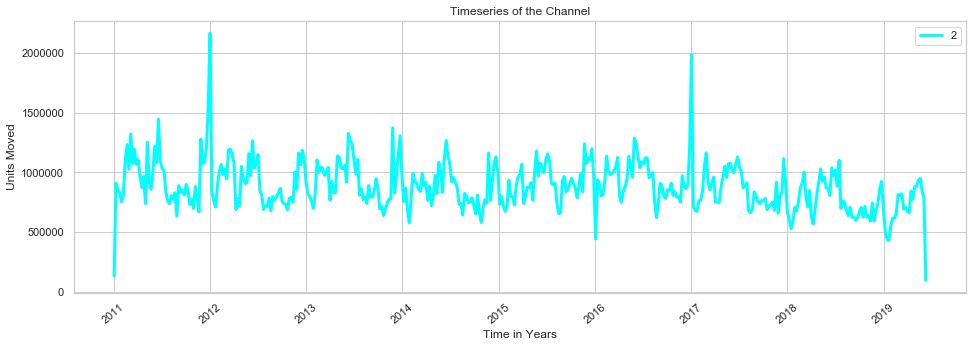

In [145]:
# Timeseries of the Channel 2 which is for the Retail Channel :
pltChannel_units('num_units',2)

**This clearly shows that the there has been a downward trend in the units movement for the stores belonging to the retail and outlet channels.   
On the other hand, there is upward trend in the same for the ecommerce channel across the multiple years.**

## ARIMA Model   

Unit Movement Distribution with Rolling mean and standard deviation

### Seasonal Decomposition :

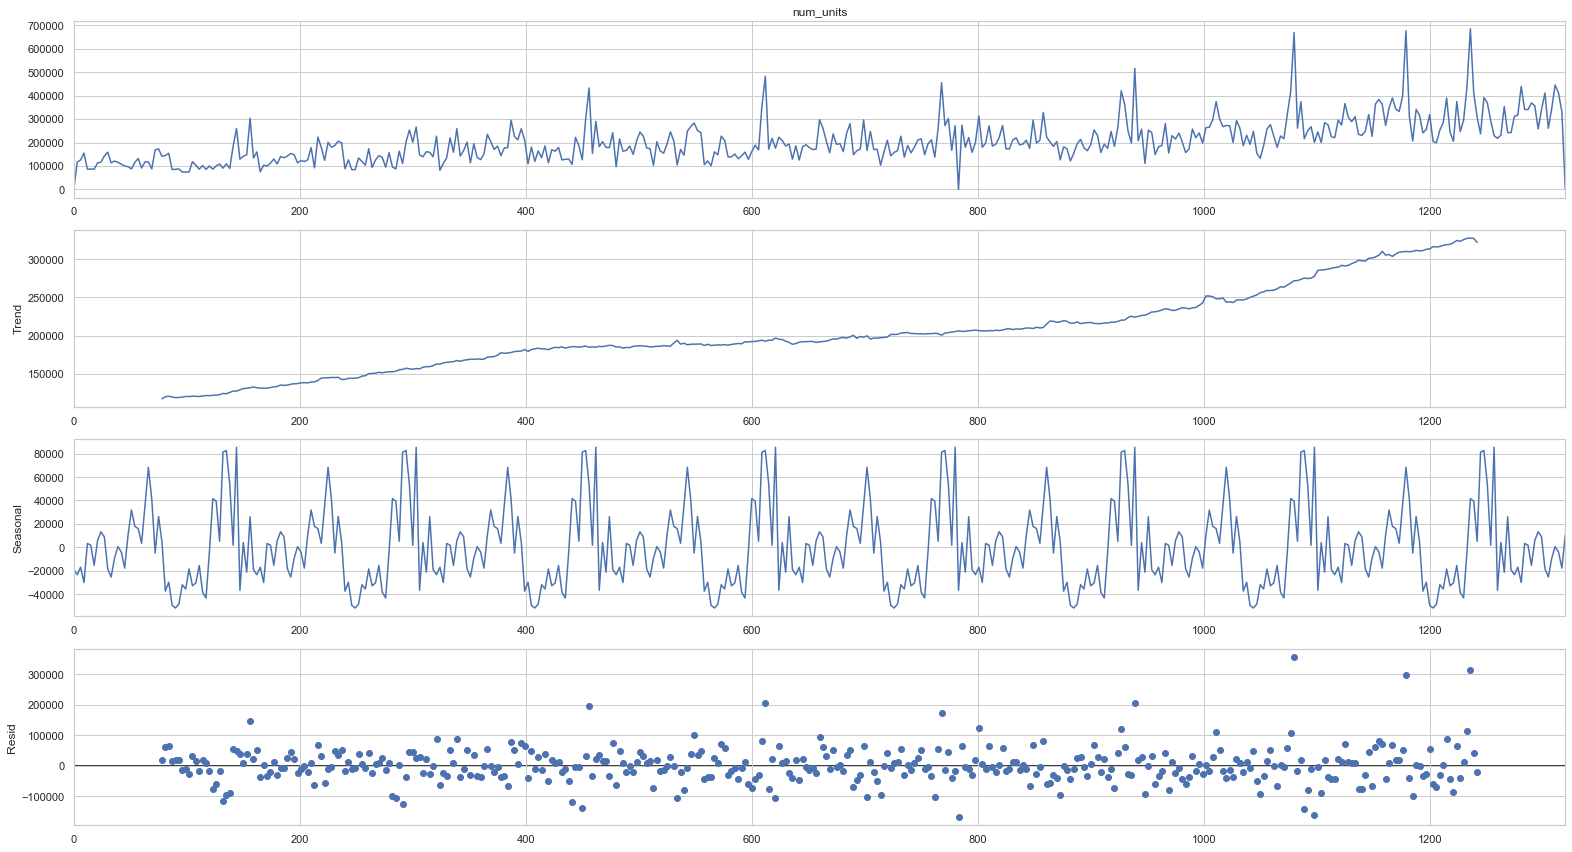

In [146]:
from pylab import rcParams
rcParams['figure.figsize'] = 22, 12

channel_mask0 = channel_grouped.loc[channel_grouped['store_type'] == 0].num_units

# Decomposition at the annual level for the channel 0:
decomposition = seasonal_decompose(channel_mask0, model='additive',freq=53)
fig = decomposition.plot()
#plt.figure(figsize=(20,14))

plt.show()

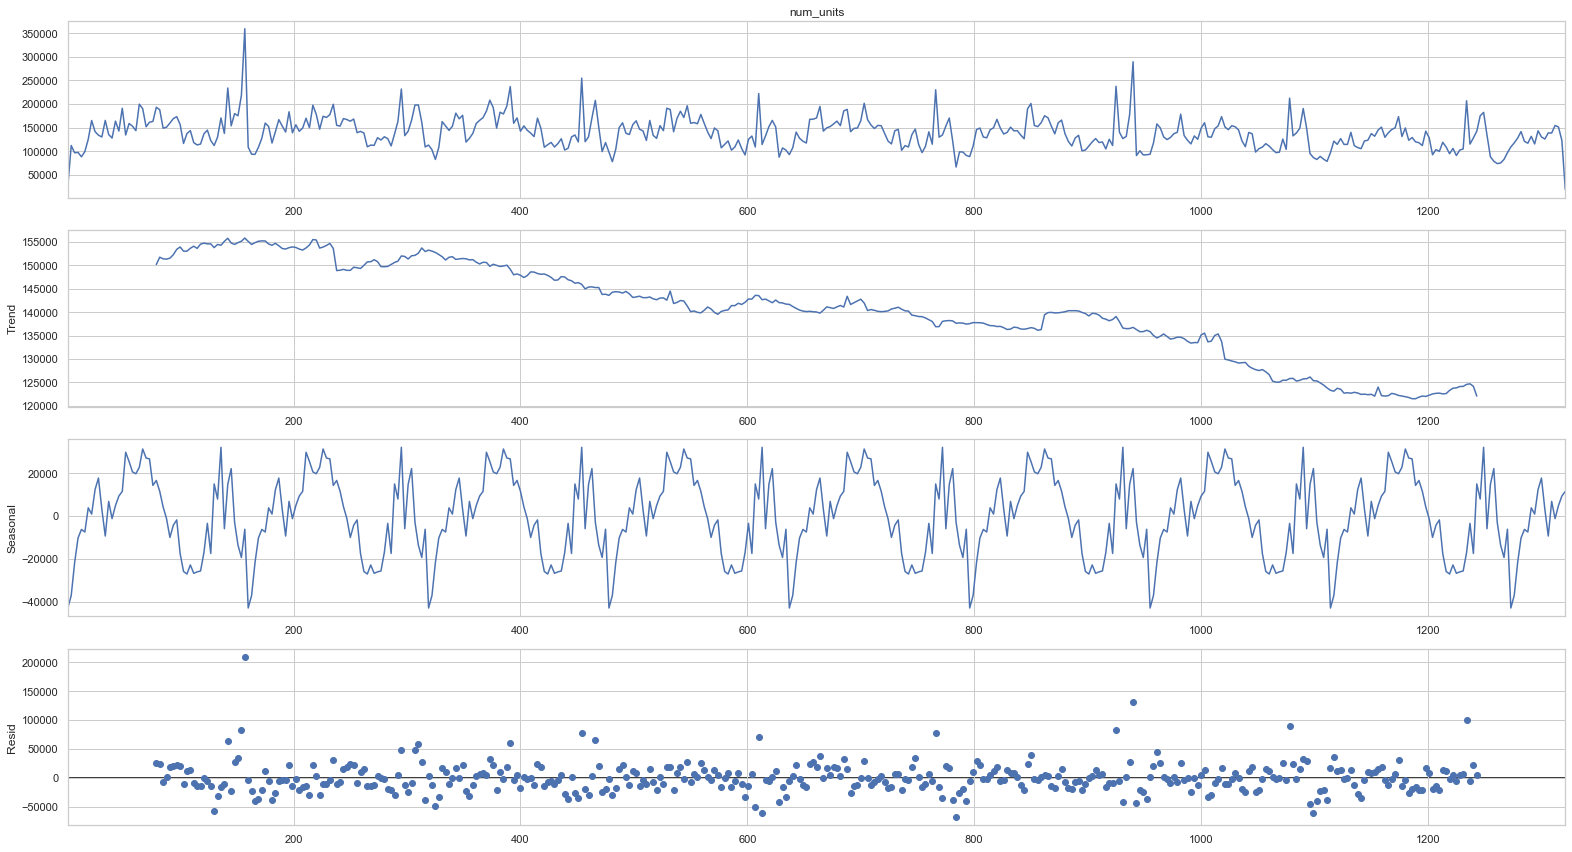

In [147]:
rcParams['figure.figsize'] = 22, 12

channel_mask1 = channel_grouped.loc[channel_grouped['store_type'] == 1].num_units

# Decomposition at the annual level for the channel 1:
decomposition = seasonal_decompose(channel_mask1, model='additive',freq=53)
fig = decomposition.plot()

plt.show()

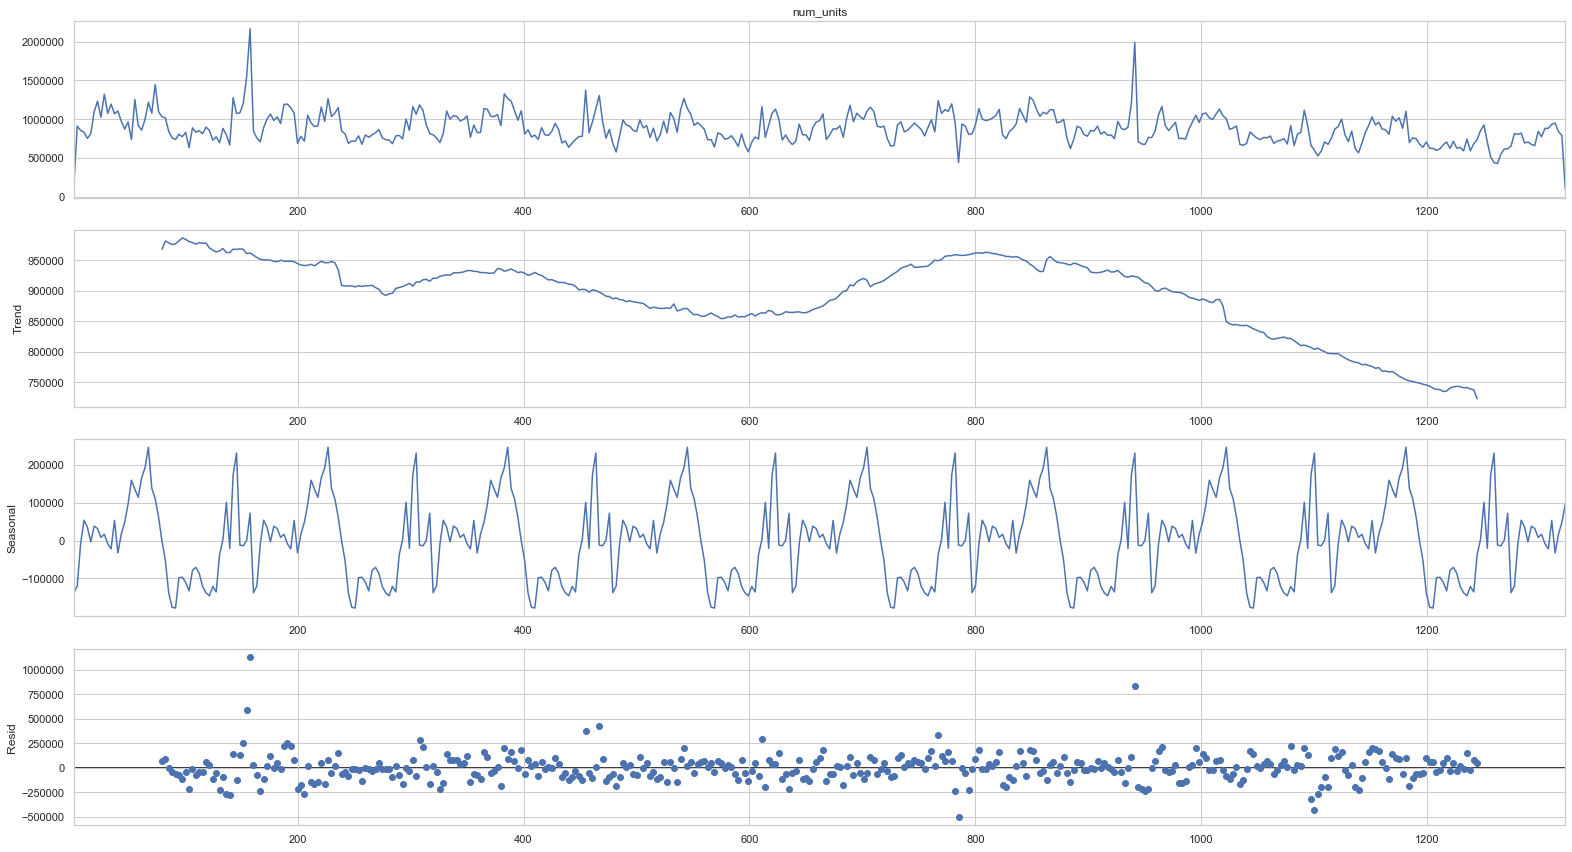

In [148]:
rcParams['figure.figsize'] = 22, 12

channel_mask2 = channel_grouped.loc[channel_grouped['store_type'] == 2].num_units

# Decomposition at the annual level for the channel 2:
decomposition = seasonal_decompose(channel_mask2, model='additive',freq=53)
fig = decomposition.plot()

plt.show()

From the above graph we analysed timeseries of Ecommerce, Outlet and Retail : Trend , Seasonal , Residual of Units Movements are analysed.  
There is clear trend and seasonality components for all the store types.   
The Ecommerce shows increasing trend of units movement and the Brick and Mortar stores types i.e. Retail and Outlet shows the declining trend in the unit movement across the years.

### Data Stationarity Checks:

In [149]:
#Function to check the stationarity of the time serie using Dickey fuller test:
def stationarity(series):
    print('Results of Dickey-Fuller Test:')
    print('Null Hypothesis: Not Stationary')
    test = ts.adfuller(series, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

#For Ecommerce channel :
ts0=channel_mask0
stationarity(ts0)

Results of Dickey-Fuller Test:
Null Hypothesis: Not Stationary
Test Statistic                  -1.544572
p-value                          0.511358
#Lags Used                      18.000000
Number of Observations Used    422.000000
Critical Value (1%)             -3.445941
Critical Value (5%)             -2.868413
Critical Value (10%)            -2.570431
dtype: float64


In [150]:
# For Outlet Stores  :
ts1=channel_mask1
stationarity(ts1)

Results of Dickey-Fuller Test:
Null Hypothesis: Not Stationary
Test Statistic                -6.587085e+00
p-value                        7.269062e-09
#Lags Used                     7.000000e+00
Number of Observations Used    4.330000e+02
Critical Value (1%)           -3.445543e+00
Critical Value (5%)           -2.868238e+00
Critical Value (10%)          -2.570338e+00
dtype: float64


In [151]:
# For Retail Stores  :
ts2=channel_mask2
stationarity(ts2)

Results of Dickey-Fuller Test:
Null Hypothesis: Not Stationary
Test Statistic                -8.449270e+00
p-value                        1.679552e-13
#Lags Used                     1.000000e+00
Number of Observations Used    4.390000e+02
Critical Value (1%)           -3.445334e+00
Critical Value (5%)           -2.868146e+00
Critical Value (10%)          -2.570289e+00
dtype: float64


Here the p-value helps us to reject the null hypothesis of the non-stationarity of the data with confidence, but that 
assumption is sometimes not enough, we should also consider the time series might not be an AR(auto-regression).  
Having said that we are sure all these timeseries are stationary now from above test.

### Checking AutoCorrelation of timeseries :

In [173]:
def autoCorr(ts):
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    tsa.plot_acf(ts,lags=53,title="ACF",alpha=0.05, ax=ax[0])
    tsa.plot_pacf(ts,lags=53,title="PACF",alpha=0.0, ax=ax[1])
    plt.show()
   # tsa.plot_acf(ts,lags=53,title="ACF",alpha=0.05)
   # tsa.plot_pacf(ts,lags=53,title="PACF",alpha=0.05)
    

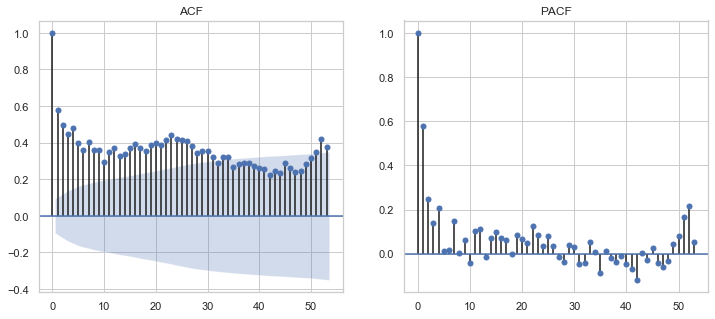

In [174]:
#For Ecommerce :
autoCorr(ts0)

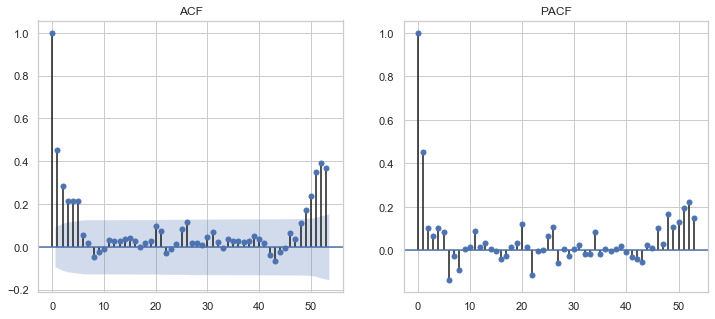

In [175]:
#For Outlet :
autoCorr(ts1)

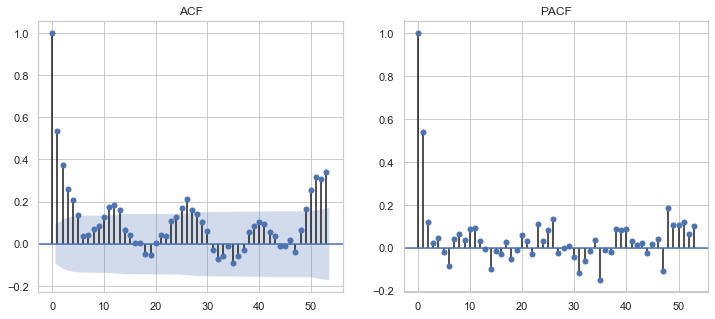

In [176]:
#For Retail :
autoCorr(ts2)

### Train Test Split:

In [177]:
# According to the requirement 3 month(13 weeks) should be the test period and 1 month(4 weeks) gap between train and test 
# Creating train and test split and keeping 4 weeks(1 month) gap between both :
# Predicting for next 3 months (13 weeks)

# Creating the function :
def split(ts):
    n_records = int(len(ts))
    train, test = ts[0:-17], ts[-13:]
    return(train,test)

In [178]:
# Arima modeling for timeseries :
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    
    #Printing the error metrics
    print(result.summary())    
     
    # Call forecast_accuracy for MAPE model eval
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

                             ARIMA Model Results                              
Dep. Variable:           D2.num_units   No. Observations:                  422
Model:                 ARIMA(1, 2, 4)   Log Likelihood               -5286.174
Method:                       css-mle   S.D. of innovations          65402.449
Date:                Tue, 02 Jun 2020   AIC                          10586.348
Time:                        13:06:19   BIC                          10614.663
Sample:                             2   HQIC                         10597.537
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.7103      5.365      0.319      0.750      -8.804      12.225
ar.L1.D2.num_units    -0.5245        nan        nan        nan         nan         nan
ma.L1.D2.num_units  

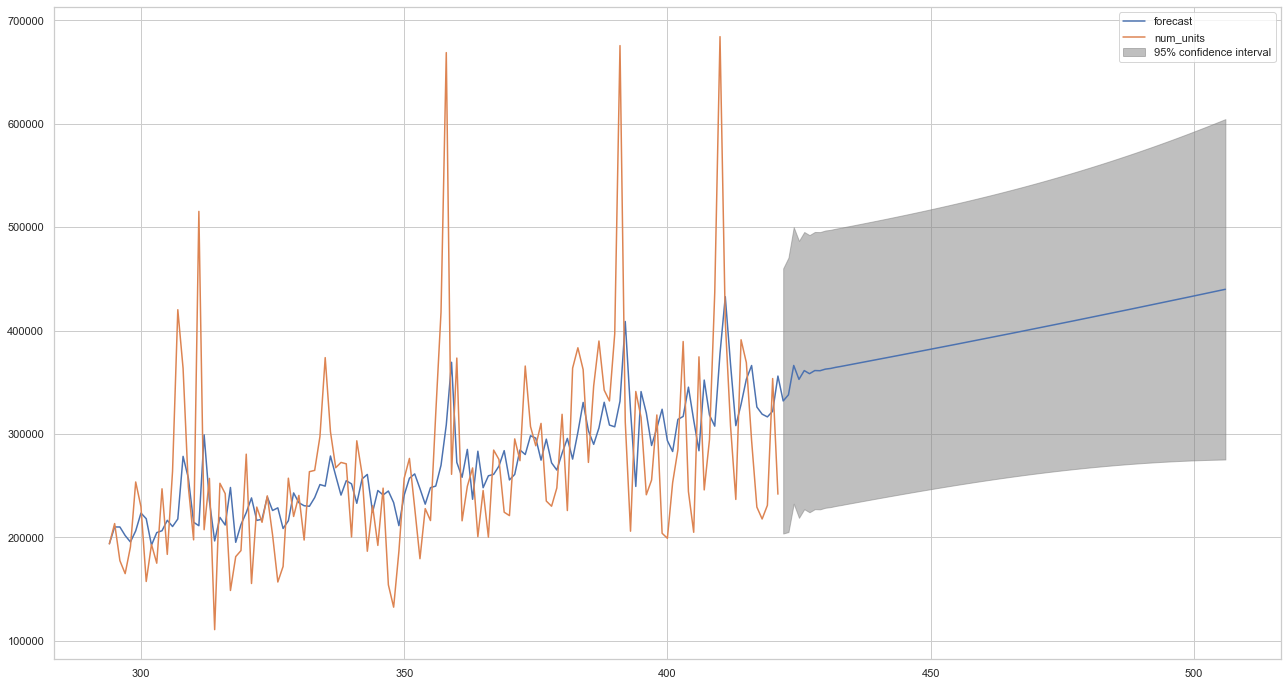

In [179]:
# Validating model for the Ecommerce : 
train,test=split(ts0)
pred=arima(train,test)

                             ARIMA Model Results                              
Dep. Variable:            D.num_units   No. Observations:                  423
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -4949.499
Method:                       css-mle   S.D. of innovations          29026.065
Date:                Tue, 02 Jun 2020   AIC                           9922.998
Time:                        13:07:35   BIC                           9971.566
Sample:                             1   HQIC                          9942.189
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -67.4666     26.406     -2.555      0.011    -119.222     -15.711
ar.L1.D.num_units     0.0899      0.190      0.472      0.637      -0.283       0.463
ar.L2.D.num_units     0.

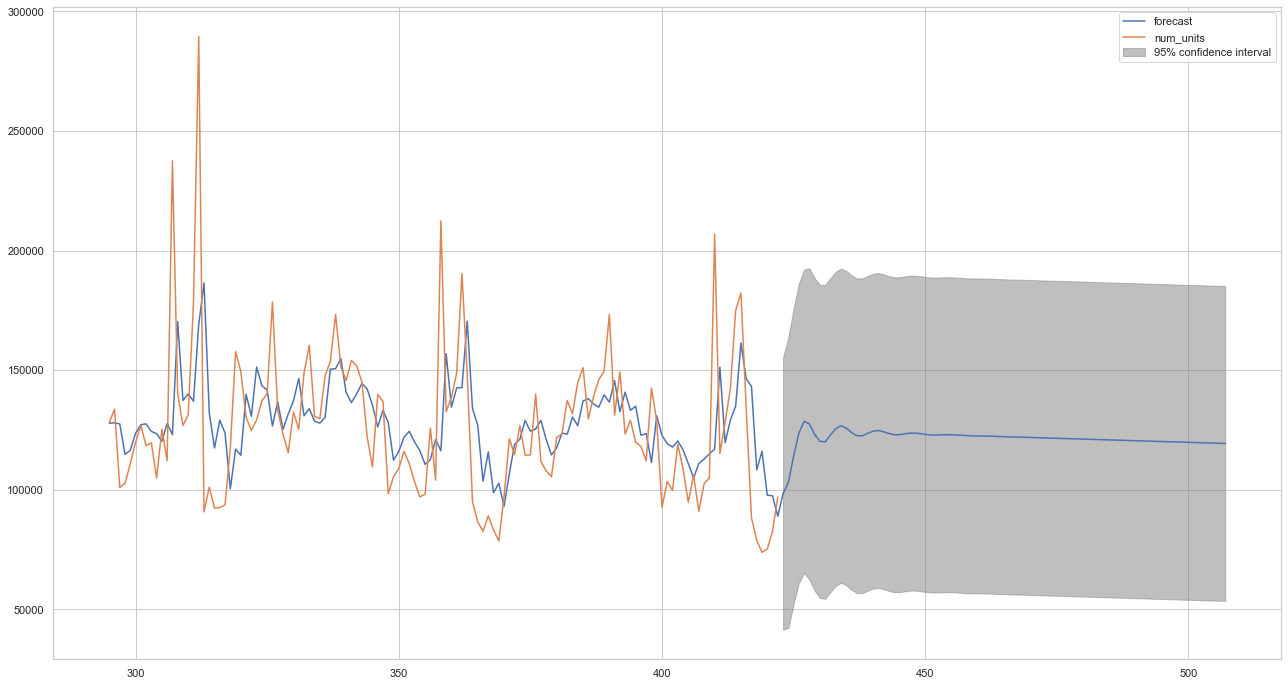

In [180]:
# Validating model for the Outlet : 
train,test=split(ts1)
pred=arima(train,test)

                             ARIMA Model Results                              
Dep. Variable:           D2.num_units   No. Observations:                  422
Model:                 ARIMA(0, 2, 5)   Log Likelihood               -5674.873
Method:                       css-mle   S.D. of innovations         164848.239
Date:                Tue, 02 Jun 2020   AIC                          11363.745
Time:                        13:08:28   BIC                          11392.060
Sample:                             2   HQIC                         11374.935
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.5542      4.516     -1.451      0.147     -15.405       2.297
ma.L1.D2.num_units    -1.4957        nan        nan        nan         nan         nan
ma.L2.D2.num_units  

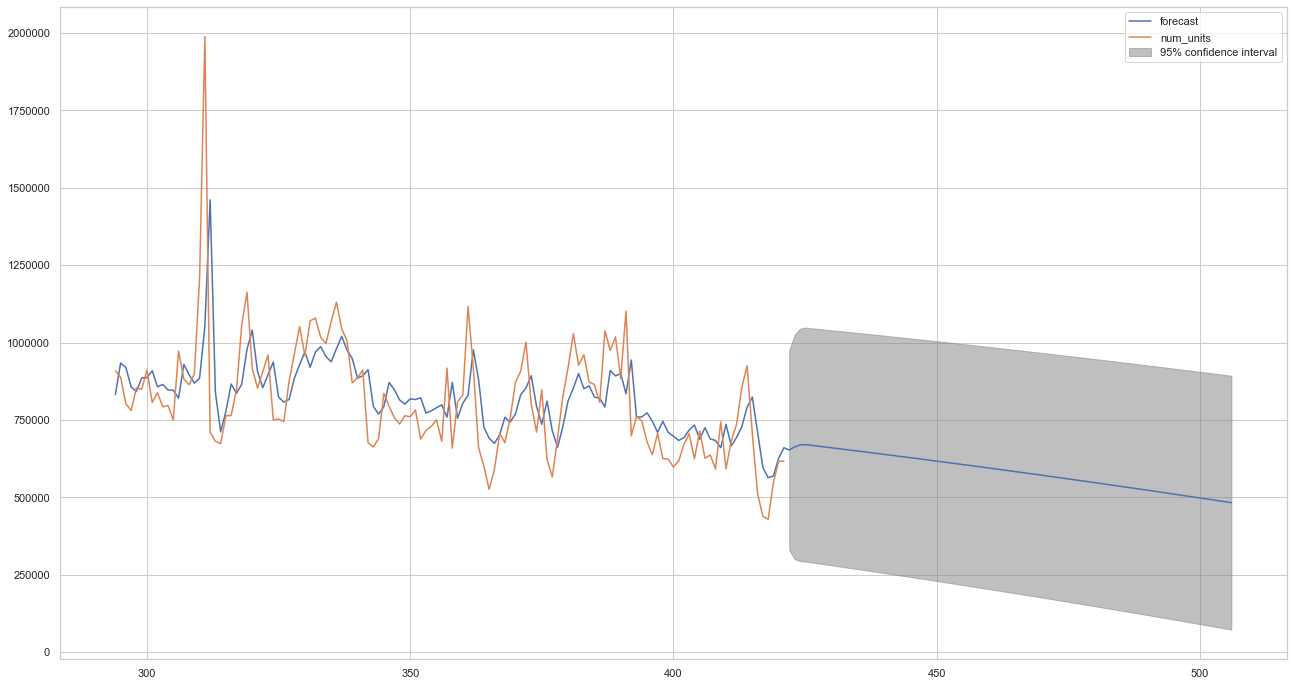

In [181]:
# Validating model for the Retail : 
train,test=split(ts2)
pred=arima(train,test)

As we can see we were able to forecast the value using ARIMA, though the performance of basic ARIMA model is not decent , 
the MAPE for the ecommerce forecast is very high and is unaccepatble.  
We will look at the other model options now.  

### Using Fbprophet for modelling:

In [182]:
# Preparing the data for the prophet :
channel_grouped.head(2)

ds  store_type  num_units
0 2011-01-03           0          5
1 2011-01-03           1      26152

In [183]:
# Creating 3 different dataframe for each of the channel :
# Created function so that we can do for all 3 channels :
def fbconvert_df(dataframe,channel):
    # Apply filter
    temp = dataframe.loc[dataframe['store_type']==channel]
    # We need only 2 columns for the prophet :
    df_converted = temp.drop(temp.columns[[1]], axis=1) 
    # Renaming for prophet 
    df_converted.rename(columns={'num_units':'y'},inplace=True)
    return df_converted

In [184]:
channel_ecom_prophet = fbconvert_df(channel_grouped,0)
channel_outlet_prophet = fbconvert_df(channel_grouped,1)
channel_retail_prophet = fbconvert_df(channel_grouped,2)

# The dataset should be made for the form of y and ds :
channel_retail_prophet.tail(2)

ds       y
1319 2019-06-03  789156
1322 2019-06-10   93293

In [185]:
# Let's divide the data into the train and test :
def divide_train_test(dataset):
    series = dataset
    n_records = len(dataset)
    i = 423
    # Creating train and test split and keeping 4 weeks(1 month) gap between both :
    # Predicting for next 3 months (13 weeks)
    train, test = series[0:i], series[i+4:i+17]
    return(train,test)

In [186]:
# Store train, test for each channel type:
ecomm_train,ecomm_test = divide_train_test(channel_ecom_prophet)
outlet_train,outlet_test = divide_train_test(channel_outlet_prophet)
retail_train,retail_test = divide_train_test(channel_retail_prophet)

retail_test.tail()

ds       y
1307 2019-05-06  883315
1310 2019-05-13  933418
1313 2019-05-20  950154
1316 2019-05-27  840435
1319 2019-06-03  789156

In [187]:
# Let's create a function to be used for each channel to apply prophet :

def apply_prophet(dataframe):
    #growth='logistic', changepoint_prior_scale=16.99
    pro_channel_full= Prophet(interval_width=0.90, n_changepoints=20, yearly_seasonality=True,
                              changepoint_prior_scale=0.05)
    # Using the built in prophet US holiday list :
    pro_channel_full.add_country_holidays(country_name='US')
    pro_channel_full.fit(dataframe)

    #  We've instantiated the model, now we need to build some future dates to forecast into.
    # Predicting for next 22 weeks 
    future_data_full = pro_channel_full.make_future_dataframe(periods=20, freq = 'w')
 
    # forecast the data for future data, To forecast this future data, we need to run it through Prophet's model:
    forecast_data_full = pro_channel_full.predict(future_data_full)
    pro_channel_full.plot(forecast_data_full)
    
    # Using the cross_validation() of fbprophet :
    cv_results = cross_validation(pro_channel_full, initial = pd.to_timedelta(410,unit="w"),period=pd.to_timedelta(53,unit="w"),
                             horizon = pd.to_timedelta(17,unit="w"))

    print("\nBelow is the cross validation result for this model : \n")
    print(cv_results.tail())
    
    # Check the trends and seasonality components:
    fig1 = pro_channel_full.plot_components(forecast_data_full)
    
    # performance_metrics:
    performance_metrics_results = performance_metrics(cv_results)
    print("\nBelow is the performance metric for this model: \n")
    print(performance_metrics_results)
    
    # Let's check the average MAPE found using the fbprophet evaluation metrics :
    mape_result = performance_metrics_results.iloc[0:12,4]
    MAPE = mape_result.mean()
    print("\nMAPE for next 91 days is :",MAPE )
    
    # Let's visualise the MAPE of the model over the horizon/future dates :
    fig2 = plot_cross_validation_metric(cv_results, metric='mape')
    
    return cv_results


### Ecommerce forecasting :

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-11 00:00:00 and 2019-02-11 00:00:00



Below is the cross validation result for this model : 

           ds           yhat     yhat_lower     yhat_upper       y     cutoff
12 2019-05-13  343252.147123  257156.683308  423289.714641  344694 2019-02-11
13 2019-05-20  343142.593108  259177.166829  422757.077625  444948 2019-02-11
14 2019-05-27  363244.791252  279891.909845  450976.929317  411007 2019-02-11
15 2019-06-03  332184.071370  249254.460888  419891.566538  330595 2019-02-11
16 2019-06-10  338513.807856  254543.754899  420677.852181     650 2019-02-11

Below is the performance metric for this model: 

    horizon           mse           rmse            mae        mape  \
0    7 days  7.138865e+09   84491.802606   84491.802606    0.348687   
1   14 days  1.520986e+06    1233.282732    1233.282732    0.003958   
2   21 days  8.611445e+06    2934.526379    2934.526379    0.009261   
3   28 days  1.082409e+10  104038.895661  104038.895661    0.237106   
4   35 days  7.310927e+07    8550.395889    8550.395889    0.025107  

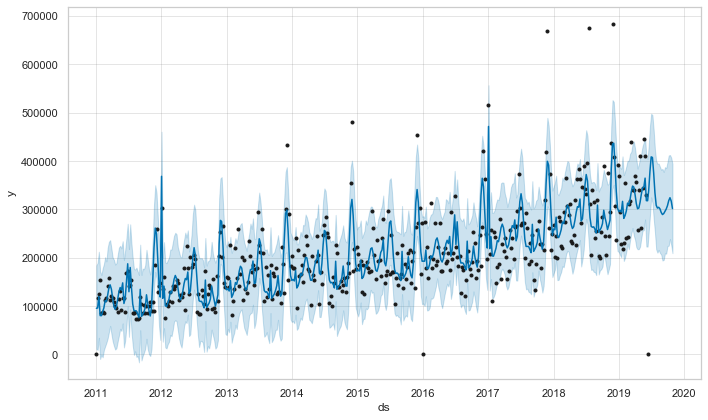

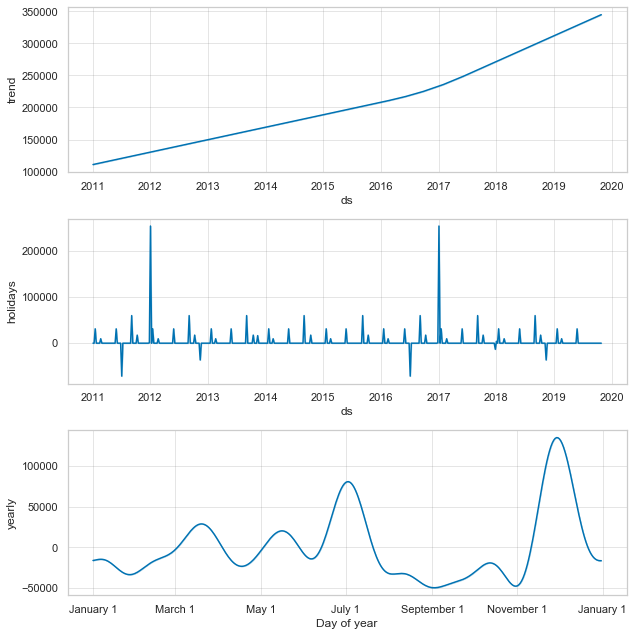

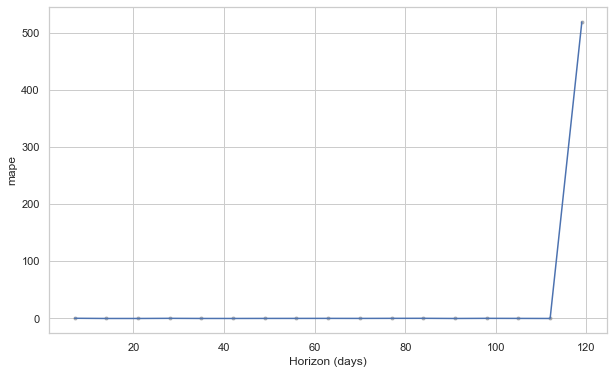

In [190]:
# Let's forecast the ecommerce data first :
cv_results_ecom = apply_prophet(channel_ecom_prophet)

#### Understanding the Ecommerce prediction results :  
The black dots are actual data points, dark blue plot is the prediction curve and the light blue hue plot is the range of prediction with 90 % confidence interval.  
The trend is very clear that the ecommerce units movement is increasing over the period of the years.  
The effect of holidays is more or less same across the years denoted by spikes except for 2 years 2012 and 2017.    
Mid November to December has highest unit movement every year followed by peak in July month every year.    
The MAPE for prediction duration is 0.13 or 13.73 % which is quite good and through this model we can predict with similar accuray for the next 140 days time period.

In [191]:
# Joining the test and predicted data on the timestamp ds 
joined_df_ecommerce = make_comparison_dataframe(ecomm_test,cv_results_ecom)

# Forcing panda to use the non-scientific notation :
joined_df_ecommerce['yhat'] = joined_df_ecommerce['yhat'].astype('int64')  

# Renaming :
joined_df_ecommerce.rename(columns={'yhat':'Predicted_Ecommerce', 'y':'Actual_Ecommerce'},inplace=True)

# Drop columns not needed :
joined_df_ecommerce = joined_df_ecommerce.drop(joined_df_ecommerce.columns[[1, 2]], axis=1) 

# Also, we want to save result between week number 2019-03-11 and 2019-06-03 only :
joined_df_ecommerce = joined_df_ecommerce.iloc[3:17,:]
joined_df_ecommerce.dropna(inplace=True)

joined_df_ecommerce = joined_df_ecommerce.astype({"Actual_Ecommerce": int})
joined_df_ecommerce

Predicted_Ecommerce  Actual_Ecommerce
ds                                               
2019-03-11               334748            438787
2019-03-18               349112            340562
2019-03-25               349835            340209
2019-04-01               333884            368654
2019-04-08               312468            356678
2019-04-15               300736            257652
2019-04-22               304923            340648
2019-04-29               319589            410721
2019-05-06               334730            260678
2019-05-13               343252            344694
2019-05-20               343142            444948
2019-05-27               363244            411007
2019-06-03               332184            330595

### Outlet Forecasting:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-11 00:00:00 and 2019-02-11 00:00:00



Below is the cross validation result for this model : 

           ds           yhat     yhat_lower     yhat_upper       y     cutoff
12 2019-05-13  137887.026881  106104.175650  169648.354491  138539 2019-02-11
13 2019-05-20  141560.892516  109795.016695  174284.771579  154553 2019-02-11
14 2019-05-27  163348.618216  133133.079962  195290.893887  151342 2019-02-11
15 2019-06-03  132471.733685   99916.004102  162518.955018  122807 2019-02-11
16 2019-06-10  134728.385081  103779.034511  165043.521349   19083 2019-02-11

Below is the performance metric for this model: 

    horizon           mse           rmse            mae      mape     mdape  \
0    7 days  4.189203e+08   20467.541841   20467.541841  0.187621  0.187621   
1   14 days  3.827531e+07    6186.704260    6186.704260  0.052570  0.052570   
2   21 days  4.154534e+07    6445.567129    6445.567129  0.050462  0.050462   
3   28 days  1.296531e+08   11386.531915   11386.531915  0.080396  0.080396   
4   35 days  1.346640e+08   1

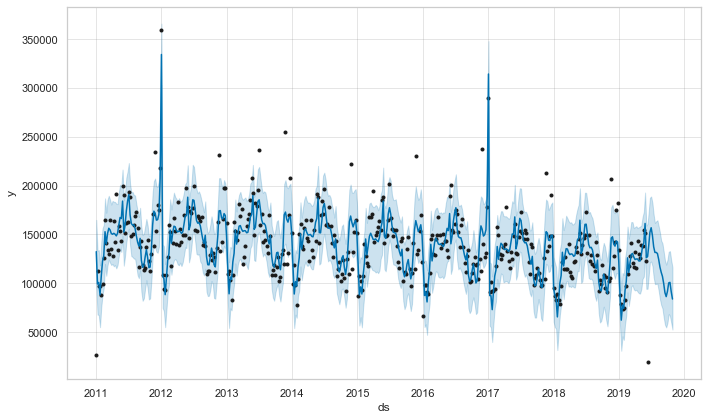

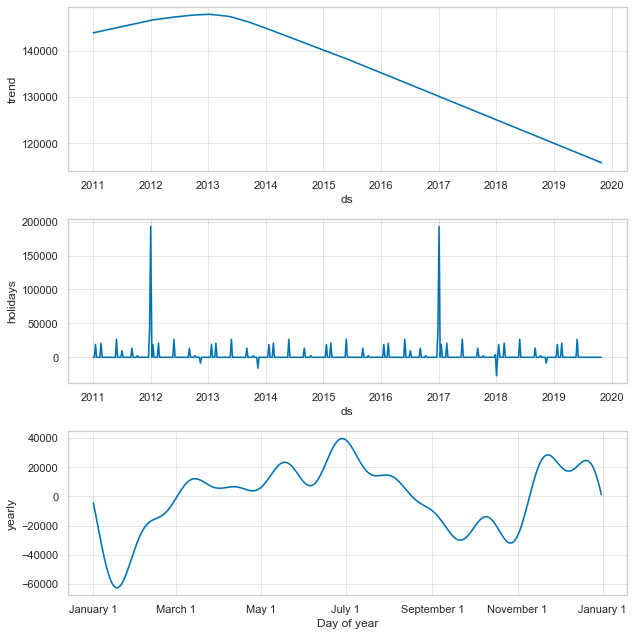

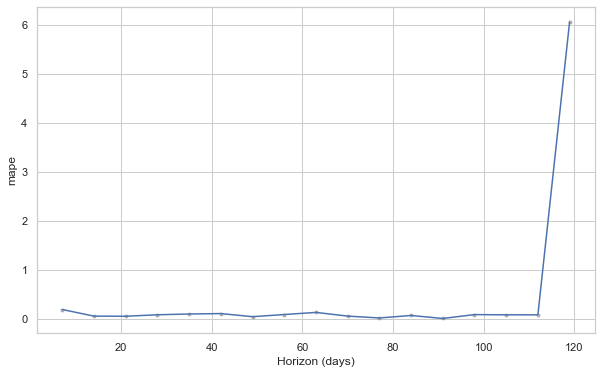

In [192]:
# Let's forecast the Outlet channel data :
cv_results_outlet = apply_prophet(channel_outlet_prophet)

#### Understanding the Outlet prediction results :  
The black dots are actual data points, dark blue plot is the prediction curve and the light blue hue plot is the range of prediction with 90 % confidence interval.  
The trend is very clear that the outlet channel units movement is decreasing over the period of the years starting from year 2013.  
The effect of holidays is more or less same across the years denoted by spikes except for 2 years 2012 and 2017.    
March to September months has highest unit movement every year followed by peak in November-December every year.    
The MAPE for prediction duration 0.08 or 8.01% which is quite good and through this model we can predict with similar accuray for the next 140 days time period.

In [193]:
# Joining the test and predicted data on the timestamp ds 
joined_df_outlet = make_comparison_dataframe(outlet_test,cv_results_outlet)

# Forcing panda to use the non-scientific notation :
joined_df_outlet['yhat'] = joined_df_outlet['yhat'].astype('int64')  

# Renaming :
joined_df_outlet.rename(columns={'yhat':'Predicted_Outlet', 'y':'Actual_Outlet'},inplace=True)

# Drop columns not needed :
joined_df_outlet = joined_df_outlet.drop(joined_df_outlet.columns[[1, 2]], axis=1) 

# Also, we want to save result between week number 2019-03-11 and 2019-06-03 only :
joined_df_outlet = joined_df_outlet.iloc[3:17,:]
joined_df_outlet.dropna(inplace=True)

joined_df_outlet = joined_df_outlet.astype({"Actual_Outlet": int})
joined_df_outlet

Predicted_Outlet  Actual_Outlet
ds                                         
2019-03-11            130243         141630
2019-03-18            132528         120924
2019-03-25            129317         117028
2019-04-01            126099         131533
2019-04-08            125330         115484
2019-04-15            124867         143277
2019-04-22            123385         130342
2019-04-29            123904         125818
2019-05-06            129632         138817
2019-05-13            137887         138539
2019-05-20            141560         154553
2019-05-27            163348         151342
2019-06-03            132471         122807

### Retail Forecasting:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-11 00:00:00 and 2019-02-11 00:00:00



Below is the cross validation result for this model : 

           ds           yhat     yhat_lower    yhat_upper       y     cutoff
12 2019-05-13  812589.042345  624490.228269  9.896783e+05  933418 2019-02-11
13 2019-05-20  772410.045402  582447.759368  9.575690e+05  950154 2019-02-11
14 2019-05-27  884413.601609  702297.797764  1.060788e+06  840435 2019-02-11
15 2019-06-03  800650.621564  612717.338975  9.862928e+05  789156 2019-02-11
16 2019-06-10  886386.448950  711149.246857  1.073404e+06   93293 2019-02-11

Below is the performance metric for this model: 

    horizon           mse           rmse            mae      mape     mdape  \
0    7 days  2.948895e+10  171723.479846  171723.479846  0.262765  0.262765   
1   14 days  8.270325e+08   28758.172767   28758.172767  0.035365  0.035365   
2   21 days  1.962159e+08   14007.708789   14007.708789  0.017399  0.017399   
3   28 days  1.119884e+08   10582.456976   10582.456976  0.012905  0.012905   
4   35 days  1.739819e+10  131902.1

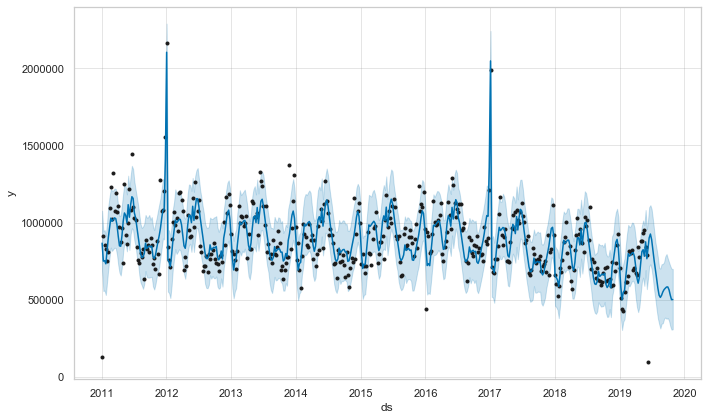

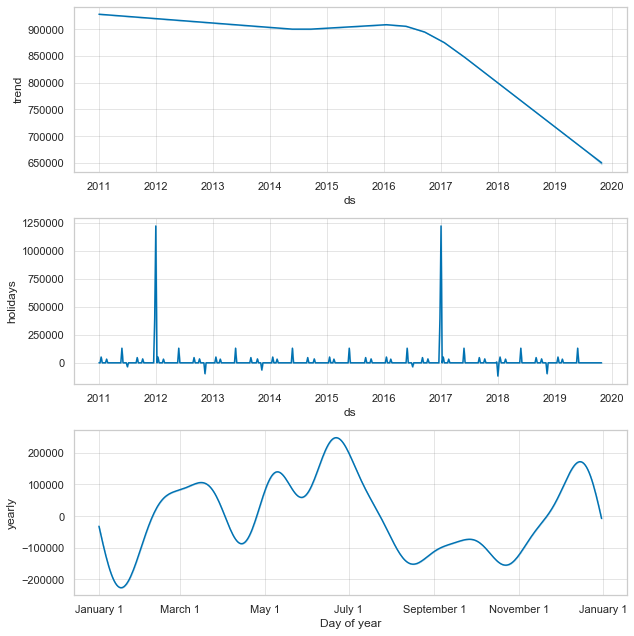

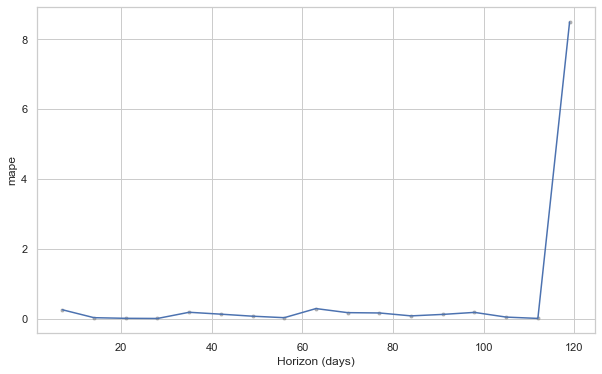

In [194]:
# Let's forecast the Retail channel data :
cv_results_retail = apply_prophet(channel_retail_prophet)

#### Understanding the Retail prediction results :
The black dots are actual data points, dark blue plot is the prediction curve and the light blue hue plot is the range of prediction with 90 % cconfidence interval.  
The trend is very clear that the outlet channel units movement is decreasing over the period of the years starting from year 2016.  
The effect of holidays is more or less same across the years denoted by spikes except for 2 years 2012 and 2017.    
May to Mid August months has highest unit movement every year followed by peak in November-December every year. There is third peak also less than these two which is between Mid Feb to April month.   
The MAPE for prediction duration is 0.12 or  12.51% which is quite good and through this model we can predict with similar accuray for the next 140 days time period.  
**Mid August to October month seems to be the duration every year where there is very less business and units movement has remained down and flat for this duration for all of 3 channels.**

In [195]:
# Joining the test and predicted data on the timestamp ds 
joined_df_retail = make_comparison_dataframe(retail_test,cv_results_retail)

# Forcing panda to use the non-scientific notation :
joined_df_retail['yhat'] = joined_df_retail['yhat'].astype('int64')  

# Renaming :
joined_df_retail.rename(columns={'yhat':'Predicted_Retail', 'y':'Actual_Retail'},inplace=True)

# Drop columns not needed :
joined_df_retail = joined_df_retail.drop(joined_df_retail.columns[[1, 2]], axis=1) 

# Also, we want to save result between week number 2019-03-11 and 2019-06-03 only :
joined_df_retail = joined_df_retail.iloc[3:17,:]
joined_df_retail.dropna(inplace=True)

joined_df_retail = joined_df_retail.astype({"Actual_Retail": int})
joined_df_retail

Predicted_Retail  Actual_Retail
ds                                         
2019-03-11            809415         819998
2019-03-18            824590         692688
2019-03-25            802041         705906
2019-04-01            727513         674803
2019-04-08            636144         659460
2019-04-15            592971         842317
2019-04-22            634926         773922
2019-04-29            730985         881474
2019-05-06            806434         883315
2019-05-13            812589         933418
2019-05-20            772410         950154
2019-05-27            884413         840435
2019-06-03            800650         789156

In [196]:
# Let's join all the channels outlet together to form single dataframe :

# List of the individual dataframes:
data_frames = [joined_df_ecommerce, joined_df_outlet, joined_df_retail]

df_merged_channel = reduce(lambda  left,right: pd.merge(left,right,on=['ds'],
                                            how='outer'), data_frames).fillna('void')

df_merged_channel.head()

Predicted_Ecommerce  Actual_Ecommerce  Predicted_Outlet  \
ds                                                                    
2019-03-11               334748            438787            130243   
2019-03-18               349112            340562            132528   
2019-03-25               349835            340209            129317   
2019-04-01               333884            368654            126099   
2019-04-08               312468            356678            125330   

            Actual_Outlet  Predicted_Retail  Actual_Retail  
ds                                                          
2019-03-11         141630            809415         819998  
2019-03-18         120924            824590         692688  
2019-03-25         117028            802041         705906  
2019-04-01         131533            727513         674803  
2019-04-08         115484            636144         659460

**_Submission of results from model:_**

In [197]:
# Saving the data to the csv file : 
df_merged_channel.to_csv("weekly_forecast_chanels.csv", encoding='utf-8', index=True, index_label='DateTime')

## -------------------------------------------------------------------------------------------------------------------------------#

## 2.3 Weekly Total Unit Movement Forecasting at Class Level :

### EDA and Data preparation:
Please note that we have already accomplished the EDA at the beginning , so we will have just quick glance here.

In [198]:
# create a copy of main dataframe :
data_units_class = data_units
data_units_class.head(2)

trans_year trans_week  class_id  store_type  num_units week_period  Year  \
0        2011         01       499           2     130329      201101  2011   
1        2011         01       499           0          5      201101  2011   

  Week         ds  
0   01 2011-01-03  
1   01 2011-01-03

In [199]:
# Info :
data_units_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130324 entries, 0 to 130323
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   trans_year   130324 non-null  int64         
 1   trans_week   130324 non-null  object        
 2   class_id     130324 non-null  int64         
 3   store_type   130324 non-null  int64         
 4   num_units    130324 non-null  int64         
 5   week_period  130324 non-null  object        
 6   Year         130324 non-null  object        
 7   Week         130324 non-null  object        
 8   ds           130324 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 9.9+ MB


In [200]:
# Creating a time stamp datatype :

# First find week and year number from the dataframe :
data_units_class.week_period = data_units_class.week_period.astype(str)
data_units_class['Year'] = data_units_class['week_period'].str.slice(0,4)
data_units_class['Week'] = data_units_class['week_period'].str.slice(4,6)

data_units_class['ds'] = pd.to_datetime(data_units_class.Week.astype(str)+
                           data_units_class.Year.astype(str).add('-1') ,format='%V%G-%u')

data_units_class.head()

trans_year trans_week  class_id  store_type  num_units week_period  Year  \
0        2011         01       499           2     130329      201101  2011   
1        2011         01       499           0          5      201101  2011   
2        2011         01       499           1      26152      201101  2011   
3        2011         01       616           2         28      201101  2011   
4        2011         01       615           2          1      201101  2011   

  Week         ds  
0   01 2011-01-03  
1   01 2011-01-03  
2   01 2011-01-03  
3   01 2011-01-03  
4   01 2011-01-03

In [201]:
# Dropping columns which are not needed :
data_units_class = data_units_class.drop(data_units_class.columns[[0,1,3,5,6,7]], axis=1)  # df.columns is zero-based pd.Index

# rearranging columns  :
data_units_class = data_units_class[['ds','class_id','num_units']]
data_units_class.head()

ds  class_id  num_units
0 2011-01-03       499     130329
1 2011-01-03       499          5
2 2011-01-03       499      26152
3 2011-01-03       616         28
4 2011-01-03       615          1

In [202]:
data_units_class.shape

(130324, 3)

In [203]:
# Print distinct classes present :
print (data_units_class.class_id.unique())

[499 616 615 710 574 623 699 741 720 733 716 731 580 531 723 702 600 706
 598 596 626 621 696 591 570 529 521 518 709 730 528 505 719 614 697 661
 649 601 509 508 724 717 622 607 606 627 625 575 617 537 533 650 705 609
 704 538 748 681 648 727 633 526 520 534 536 677 612 599 698 742 739 725
 628 722 712 657 620 651 530 595 581 593 535 611 714 675 660 503 502 683
 571 662 507 506 504 624 618 592 652 501 672 604 610 663 728 532 636 552
 631 736 629 647 540 572 732 539 664 608 700 740 500 721 676 726 527 703
 582 738 551 659 573 545 510 630 670 554 685 576 735 737 519 686 718]


In [204]:
# Finding the count of unit movement across the classes :
df = data_units_class.fillna('NA').groupby(['ds','class_id'])['num_units'].sum() \
                          .groupby(['ds','class_id']).max().sort_values() \
                          .groupby(['class_id']).sum().sort_values(ascending = False)

dfinfo = pd.DataFrame(df)
dfinfo

num_units
class_id           
499       104050028
626        24047683
664        21930405
507        21664917
509        18062731
...             ...
672             388
698             341
608             247
676               7
500               7

[143 rows x 1 columns]

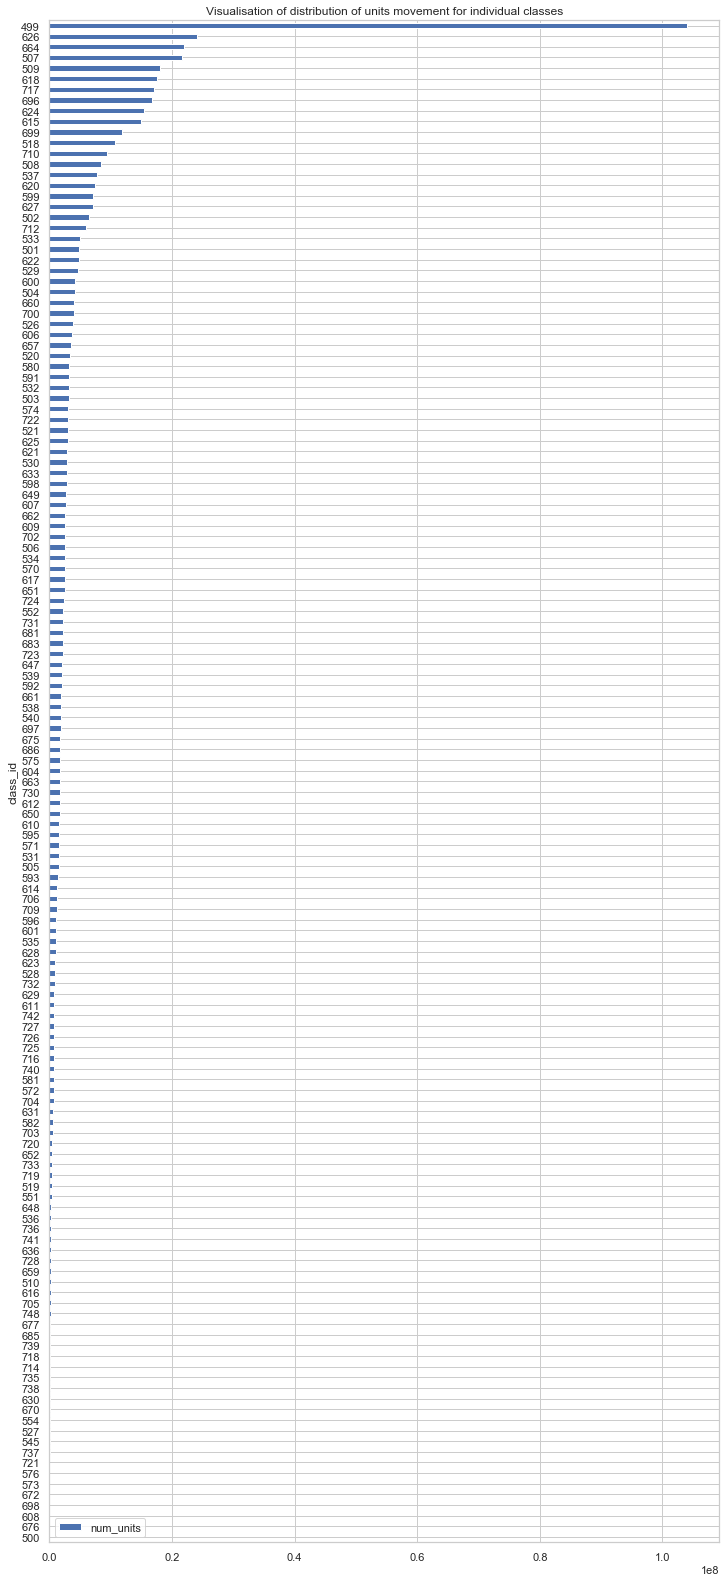

In [215]:
# Let's do quick visualisation of distribution of units movement for individual classes :
dfinfo.sort_values(by= 'num_units').tail(143).plot(kind = 'barh', figsize = (12,28), 
                                            title= "Visualisation of distribution of units movement for individual classes")

**There are 143 different classes, class 499 (imputed by us for missing values) has highest no of unit movements which is more than the combined sum of unit movements of remaining classes.**

### Pareto Chart for important classes:

Pareto charts display the values in the vector Y as bars drawn in descending order. Values in Y must be nonnegative and not
include NaNs. By default, either the tallest 10 bars or first 95% of the cumulative distribution is displayed, whichever is
smaller.

In [216]:
 # import :
from matplotlib.ticker import PercentFormatter

dfpareto = dfinfo.copy()
dfpareto["cumpercentage"] = dfpareto["num_units"].cumsum()/dfpareto["num_units"].sum()*100
dfpareto.sort_values(by=['cumpercentage'], ascending=True).head(20)

num_units  cumpercentage
class_id                          
499       104050028      19.207277
626        24047683      23.646396
664        21930405      27.694674
507        21664917      31.693943
509        18062731      35.028261
618        17475161      38.254115
717        17016764      41.395351
696        16663275      44.471334
624        15419071      47.317642
615        14990226      50.084786
699        11772440      52.257938
518        10702200      54.233527
710         9424190      55.973200
508         8331537      57.511173
537         7692801      58.931238
620         7502757      60.316221
599         7114164      61.629471
627         7038958      62.928838
502         6414947      64.113016
712         6021139      65.224497

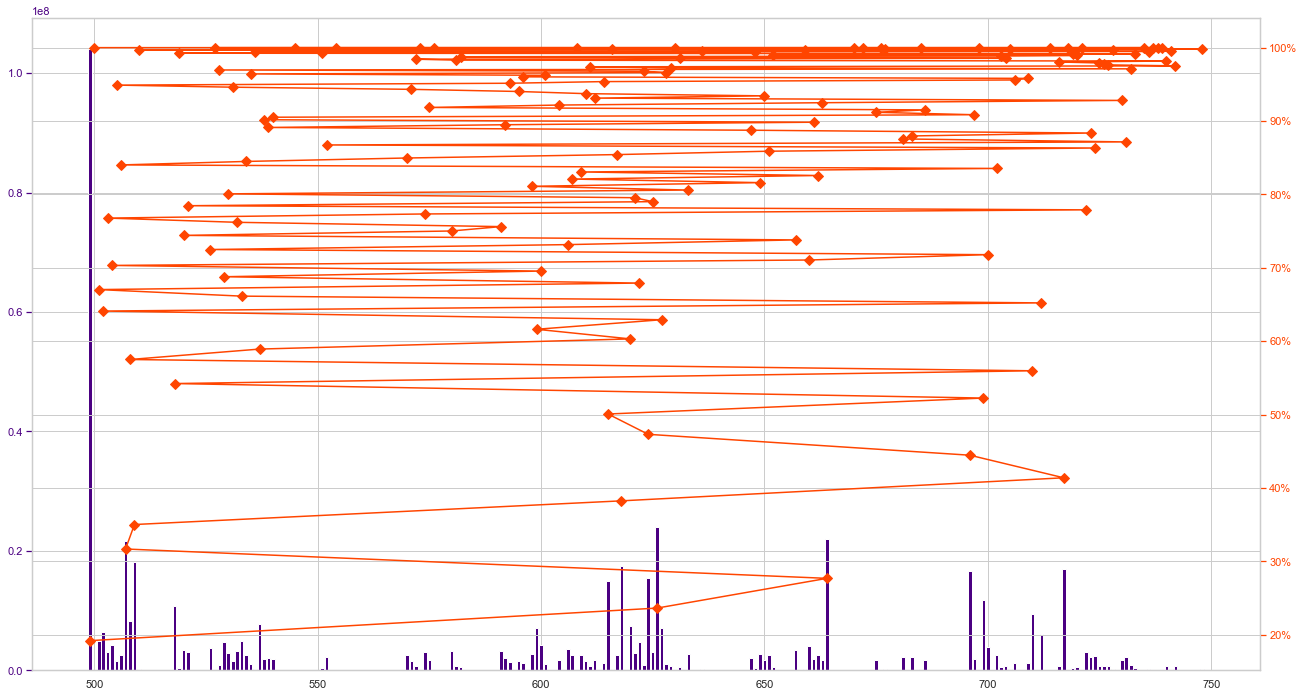

In [217]:
# Plotting :
fig, ax = plt.subplots()
ax.bar(dfpareto.index, dfpareto["num_units"], color="indigo")
ax2 = ax.twinx()
ax2.plot(dfpareto.index, dfpareto["cumpercentage"], color="orangered", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="indigo")
ax2.tick_params(axis="y", colors="orangered")
plt.show()

*This is very important information that out of the 143 classes, the products/SKU's belonging to just below 20 classes contributes to the 65 % of the total unit movements :    
499
626
664
507
509
618
717
696
624
615
699
518
710
508
537
620
599
627
502
712*   

**This is an important information for the business, so that business can focus more on the branding, procurring , selling and ofcourse inventory management of the products belonging to these 20 classes.** 

## Clustering Methods :

The idea behind cluster partitioning methods is to define clusters such that the total intra-cluster variation (known as 
total within-cluster variation or total within-cluster sum of square) is minimized.

In [218]:
# Let's prepare our data for the clustering method :
temp_df = data_units_class.pivot_table(index= ['class_id'], columns = ['ds'],values = ['num_units'],
                                       aggfunc='sum',fill_value=0 )

temp_df.head()

num_units                                                         \
ds       2011-01-03 2011-01-10 2011-01-17 2011-01-24 2011-01-31 2011-02-07   
class_id                                                                     
499          156486    1138871    1078343    1083136     926547     998591   
500               0          0          0          0          0          0   
501               0          0          0          0          0          0   
502               0          0          0          0          0          0   
503               0          0          0          0          0          0   

                                                      ...             \
ds       2011-02-14 2011-02-21 2011-02-28 2011-03-07  ... 2019-04-08   
class_id                                              ...              
499         1305816    1510951    1283208    1598172  ...       2919   
500               0          0          0          0  ...          0   
501               0          0          0          0  ...      10894   
502               0          0          0          0  ...       7032   
503               0          0          0          0  ...        628   

                                                                            \
ds       2019-04-15 2019-04-22 2019-04-29 2019-05-06 2019-05-13 2019-05-20   
class_id                                                                     
499            2900       2636       3854       8372       3961       2981   
500               0          0          0          0          0          0   
501           12864       9709      11178       7792       6525       6719   
502            8824       6347       6116       2911       2421       2612   
503             755        950        886        685        556        582   

                                           
ds       2019-05-27 2019-06-03 2019-06-10  
class_id                                   
499            2598       2847        292  
500               0          0          0  
501            6481       6621        448  
502            2390       2928        168  
503             665        714        110  

[5 rows x 441 columns]

In [219]:
temp_df.tail(2)

num_units                                                         \
ds       2011-01-03 2011-01-10 2011-01-17 2011-01-24 2011-01-31 2011-02-07   
class_id                                                                     
742               0          0          0          0          0          0   
748               0          0          0          0          0          0   

                                                      ...             \
ds       2011-02-14 2011-02-21 2011-02-28 2011-03-07  ... 2019-04-08   
class_id                                              ...              
742               0          0          0          0  ...          6   
748               0          0          0          0  ...       5761   

                                                                            \
ds       2019-04-15 2019-04-22 2019-04-29 2019-05-06 2019-05-13 2019-05-20   
class_id                                                                     
742               8          3          3          1          1          3   
748            4245       4477       5225       3464       3137       3328   

                                           
ds       2019-05-27 2019-06-03 2019-06-10  
class_id                                   
742               7          7          0  
748            4863       5011        417  

[2 rows x 441 columns]

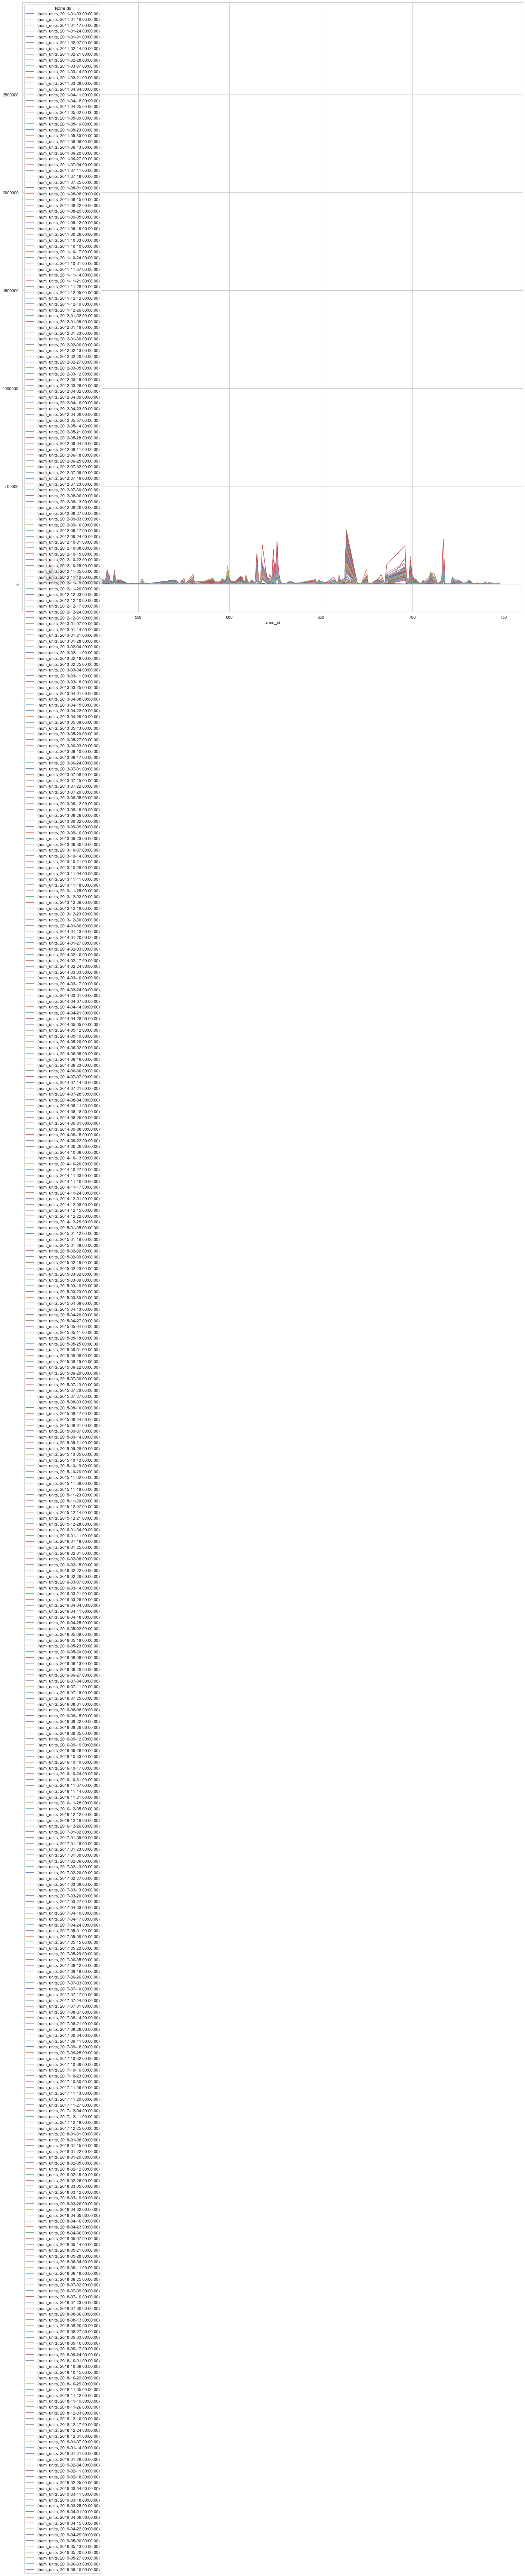

In [222]:
# Plotting the class_id vs num_units :
temp_df.plot(figsize = (24,30))

#### So the data has been arranged in terms of 441 time stamps for all the given 143 classes now.

### Hierarchial Agglomerative Clustering:  
Agglomerative clustering (also called (Hierarchical Agglomerative Clustering, or HAC)) is a “bottom up” type of hierarchical clustering. In agglomerative clustering, each data point is defined as a cluster. Pairs of clusters are merged as the algorithm moves up in the hierarchy.  
In agglomerative clustering, each document is treated as a single cluster at the beginning of the algorithm. After that, clusters can be combined through a variety of methods. They all involve calculating dissimilarities between objects; Exactly how that dissimilarity is calculated can vary. 

#### Linkage and Dendrograms  
The linkage function takes the distance information and groups pairs of objects into clusters based on their similarity. 
These newly formed clusters are next linked to each other to create bigger clusters. This process is iterated until all the  objects in the original data set are linked together in a hierarchical tree.  

In [223]:
#Standard Scaling since Clustering sre distance based alogrithm:
# Instantiate standard scalar :
std=StandardScaler()

temp_df_scaled=std.fit_transform(temp_df[["num_units"]]) 
temp_df_scaled = pd.DataFrame(temp_df_scaled)
temp_df_scaled.head()

0          1          2          3          4          5    \
0  11.916375  11.916375  11.916375  11.916375  11.916375  11.916375   
1  -0.083934  -0.083942  -0.083941  -0.083938  -0.083927  -0.083926   
2  -0.083934  -0.083942  -0.083941  -0.083938  -0.083927  -0.083926   
3  -0.083934  -0.083942  -0.083941  -0.083938  -0.083927  -0.083926   
4  -0.083934  -0.083942  -0.083941  -0.083938  -0.083927  -0.083926   

         6          7          8          9    ...       431       432  \
0  11.916375  11.916375  11.916375  11.916375  ... -0.379443 -0.332095   
1  -0.083928  -0.083926  -0.083928  -0.083928  ... -0.601208 -0.498313   
2  -0.083928  -0.083926  -0.083928  -0.083928  ...  0.226442  0.239009   
3  -0.083928  -0.083926  -0.083928  -0.083928  ... -0.066966  0.007450   
4  -0.083928  -0.083926  -0.083928  -0.083928  ... -0.553497 -0.455039   

        433       434       435       436       437       438       439  \
0 -0.335335 -0.295598 -0.030106 -0.275779 -0.333821 -0.383281 -0.363565   
1 -0.480968 -0.483523 -0.451092 -0.459504 -0.460496 -0.521357 -0.540736   
2  0.055431  0.061528 -0.059271 -0.156852 -0.174979 -0.176910 -0.128707   
3 -0.130311 -0.185301 -0.304712 -0.347210 -0.349502 -0.394335 -0.358525   
4 -0.428482 -0.440321 -0.416647 -0.433715 -0.435764 -0.486014 -0.496303   

        440  
0 -0.336522  
1 -0.533685  
2 -0.231188  
3 -0.420249  
4 -0.459412  

[5 rows x 441 columns]

We will use the metric "ward" here.
In this process makes a new cluster that minimizes variance, measured by an index called E (also called the sum of squares 
index).

In [225]:
# To do clustering of our data create the (Linkage):
mergings = linkage(temp_df_scaled.iloc[:, 0:441], 'ward')

In [226]:
# As the scipy linkage docs tell us, ward is one of the methods that can be used to calculate the distance between newly
# formed clusters. The keyword ‘ward’ causes linkage function to use the Ward variance minimization algorithm. 
# Other common linkage methods like single, complete, average, and different distance metrics such as euclidean, manhattan, 
# hamming, cosine are also available.

Now let’s have a look at what’s dendogram of this hierarchical clustering. Dendrograms are hierarchical plots of clusters where
the length of the bars represents the distance to the next cluster centre. 

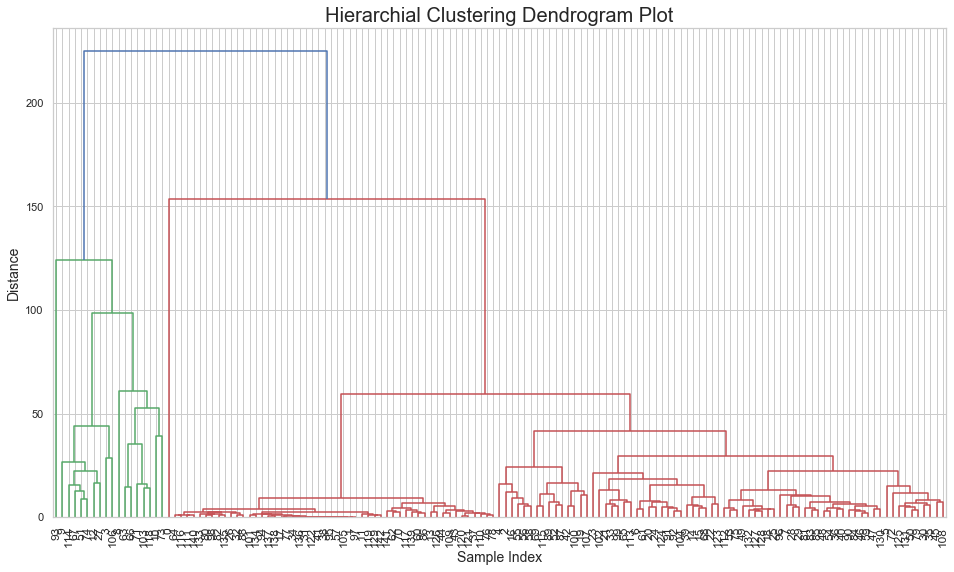

In [227]:
# Dendrogram Original using the normal linkage :
plt.figure(figsize=(16,9))
plt.title("Hierarchial Clustering Dendrogram Plot", size = 20)
plt.xlabel("Sample Index", size = 14)
plt.ylabel("Distance", size = 14)

dendrogram(
         mergings,
         leaf_rotation=90., # Rotates the X-axis label
         leaf_font_size=12. #
         )

plt.show()

On the x axis we see labels. If we don’t specify anything else they are the indices of your samples in X.  
On the y axis we see the distances (of the ward method in our case).  
Horizontal lines are cluster merges.  
Vertical lines tell that which clusters/labels were part of merge forming that new cluster.  
Heights of the horizontal lines tells about the distance that needed to be “bridged” to form the new cluster.   
Even with explanations, the previous dendogram is still not obvious. We can cut a little bit to be able to take a better look at the data.  

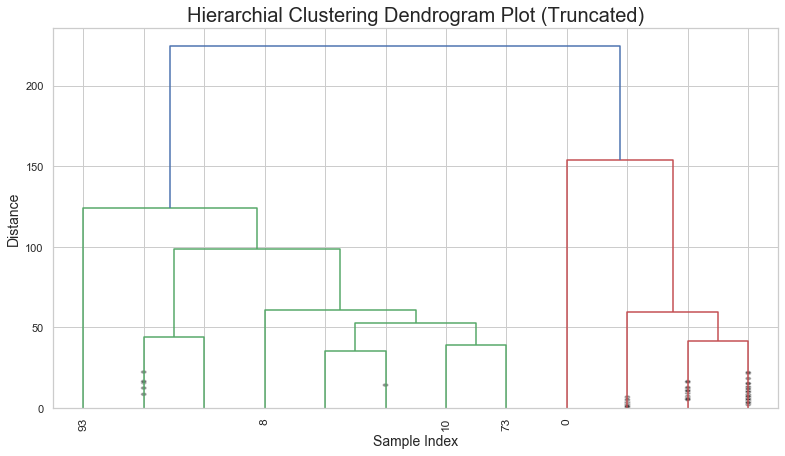

In [228]:
plt.figure(figsize=(13,7))

plt.title("Hierarchial Clustering Dendrogram Plot (Truncated)", size = 20)
plt.xlabel("Sample Index", size = 14)
plt.ylabel("Distance", size = 14)

dendrogram(
         mergings,
         truncate_mode = 'lastp',  # shows only last p merged clusters
         p=12,                     # p-value
         show_leaf_counts = False, # otherwise numbers in bracket are counts
         leaf_rotation=90.,
         leaf_font_size=12.,
         show_contracted= True     # to get distribution expression in truncated branches
         )

plt.show()

If we draw a horizontal line that passes through longest distance without a horizontal line, say at distance of 
101, we get 4 clusters.

In [229]:
# 4 clusters are visible clearly here :
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [230]:
# Creating a copy of the dataframe :
temp_df_hierarchial = temp_df.copy()

In [231]:
# assign cluster labels to the dataframe :
temp_df_hierarchial['cluster_labels'] = cluster_labels
temp_df_hierarchial.head(5)

num_units                                          \
ds       2011-01-03 00:00:00 2011-01-10 00:00:00 2011-01-17 00:00:00   
class_id                                                               
499                   156486             1138871             1078343   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                                                                      \
ds       2011-01-24 00:00:00 2011-01-31 00:00:00 2011-02-07 00:00:00   
class_id                                                               
499                  1083136              926547              998591   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                                                                      \
ds       2011-02-14 00:00:00 2011-02-21 00:00:00 2011-02-28 00:00:00   
class_id                                                               
499                  1305816             1510951             1283208   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                              ...                                          \
ds       2011-03-07 00:00:00  ... 2019-04-15 00:00:00 2019-04-22 00:00:00   
class_id                      ...                                           
499                  1598172  ...                2900                2636   
500                        0  ...                   0                   0   
501                        0  ...               12864                9709   
502                        0  ...                8824                6347   
503                        0  ...                 755                 950   

                                                                      \
ds       2019-04-29 00:00:00 2019-05-06 00:00:00 2019-05-13 00:00:00   
class_id                                                               
499                     3854                8372                3961   
500                        0                   0                   0   
501                    11178                7792                6525   
502                     6116                2911                2421   
503                      886                 685                 556   

                                                                      \
ds       2019-05-20 00:00:00 2019-05-27 00:00:00 2019-06-03 00:00:00   
class_id                                                               
499                     2981                2598                2847   
500                        0                   0                   0   
501                     6719                6481                6621   
502                     2612                2390                2928   
503                      582                 665                 714   

                             cluster_labels  
ds       2019-06-10 00:00:00                 
class_id                                     
499                      292              0  
500                        0              1  
501                      448              1  
502                      168              2  
503                      110              1  

[5 rows x 442 columns]

In [232]:
# Checking the cluster count:
temp_df_hierarchial['cluster_labels'].value_counts()

1    124
2     17
3      1
0      1
Name: cluster_labels, dtype: int64

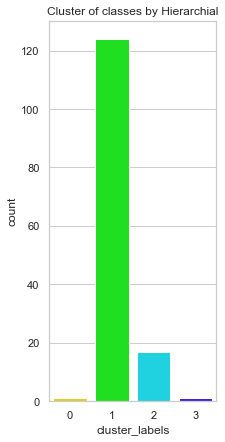

In [233]:
plt.figure(figsize=(3,7))
plt.title("Cluster of classes by Hierarchial")
sns.countplot(x="cluster_labels", data=temp_df_hierarchial, palette=("gist_rainbow"))

In [234]:
# So a new column is added which is assigned cluster_label for each of the classes.
# Here, 124 classes belongs to class 1 , 17 belong to class 2 , 1 belongs to cluster3 and 1 belongs to cluster 0.

In [235]:
# Agglomerative Clustering 

   
Let's try to createt the linkage differently and try to find the number of clsuters here:

In [236]:
# Call the AgglomerativeClustering to create linkage model :
clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(temp_df_scaled.iloc[:, 0:441])

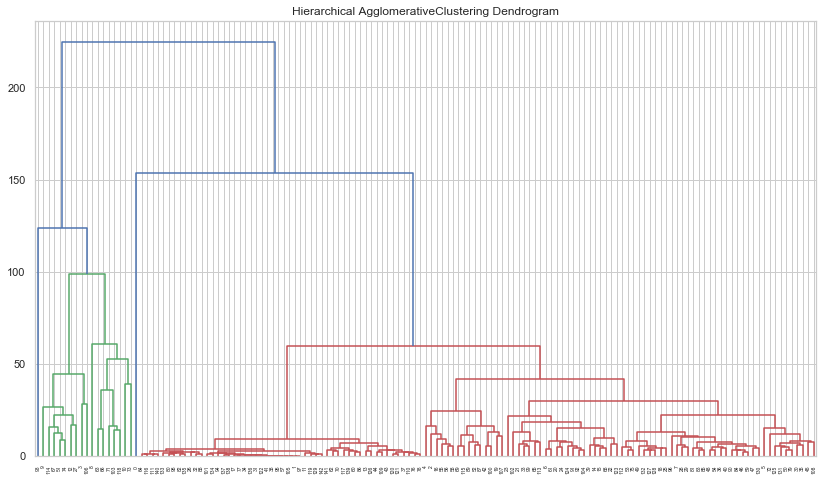

In [237]:
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

plt.figure(figsize = (14,8))
plt.title('Hierarchical AgglomerativeClustering Dendrogram')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf, p=5, color_threshold = 110)
plt.show()

In [238]:
# extract clusters from dendogram
clusters = fcluster(Z, 100, criterion='distance')
clusters

array([4, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

The result obtained fro the normal linkage process and AgglomerativeClustering yields same result here.   
**4 clusters are extracted from the Hierarchical Agglomerative Clustering method.**

In [239]:
# Creating a copy of the dataframe :
temp_df_agglomerative= temp_df.copy()

In [240]:
# create a lookup table for series in a given cluster:
temp_df_agglomerative["cluster"] = clusters
temp_df_agglomerative.head()

num_units                                          \
ds       2011-01-03 00:00:00 2011-01-10 00:00:00 2011-01-17 00:00:00   
class_id                                                               
499                   156486             1138871             1078343   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                                                                      \
ds       2011-01-24 00:00:00 2011-01-31 00:00:00 2011-02-07 00:00:00   
class_id                                                               
499                  1083136              926547              998591   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                                                                      \
ds       2011-02-14 00:00:00 2011-02-21 00:00:00 2011-02-28 00:00:00   
class_id                                                               
499                  1305816             1510951             1283208   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                              ...                                          \
ds       2011-03-07 00:00:00  ... 2019-04-15 00:00:00 2019-04-22 00:00:00   
class_id                      ...                                           
499                  1598172  ...                2900                2636   
500                        0  ...                   0                   0   
501                        0  ...               12864                9709   
502                        0  ...                8824                6347   
503                        0  ...                 755                 950   

                                                                      \
ds       2019-04-29 00:00:00 2019-05-06 00:00:00 2019-05-13 00:00:00   
class_id                                                               
499                     3854                8372                3961   
500                        0                   0                   0   
501                    11178                7792                6525   
502                     6116                2911                2421   
503                      886                 685                 556   

                                                                      \
ds       2019-05-20 00:00:00 2019-05-27 00:00:00 2019-06-03 00:00:00   
class_id                                                               
499                     2981                2598                2847   
500                        0                   0                   0   
501                     6719                6481                6621   
502                     2612                2390                2928   
503                      582                 665                 714   

                             cluster  
ds       2019-06-10 00:00:00          
class_id                              
499                      292       4  
500                        0       3  
501                      448       3  
502                      168       1  
503                      110       3  

[5 rows x 442 columns]

In [241]:
# Checking the cluster count:
temp_df_agglomerative['cluster'].value_counts()

3    124
1     17
4      1
2      1
Name: cluster, dtype: int64

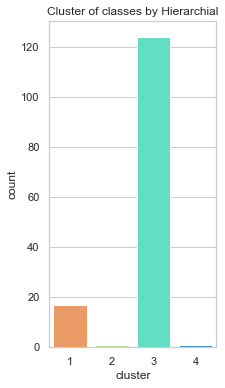

In [242]:
plt.figure(figsize=(3,6))
plt.title("Cluster of classes by Hierarchial")
sns.countplot(x="cluster", data=temp_df_agglomerative, palette=("rainbow_r"))

In [243]:
# The result matches with the plain hierarchial clustering and we have 124, 17, 1, 1 classes in these individual clusters.  
# So, we can take any of the dataframe temp_df_agglomerative or temp_df_hierarchial for predictions later.

**This Hierarchial clustering is able to identify 4 different cluster of classes , lets confirm if we get the same results from the K-means clustering as well.**

### K-means clustering:  
Unlike Hierarchial Clustering K-means is flat clustering method.   
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.    

**How the K-means algorithm works**
To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids
It halts creating and optimizing clusters when either:
The centroids have stabilized — there is no change in their values because the clustering has been successful.
The defined number of iterations has been achieved.


#### Finding Optimal number of clusters in K-means :

#### Elbow-curve/SSD:

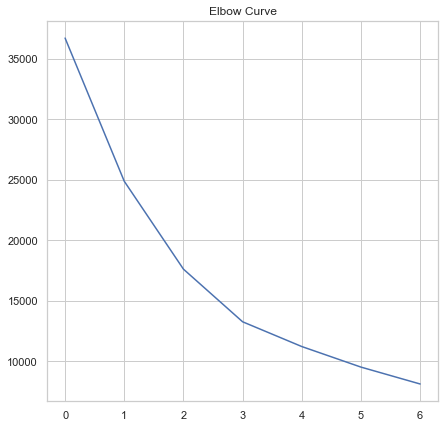

In [244]:
# Elbow-curve/SSD:
plt.figure(figsize=(7,7))
plt.title("Elbow Curve")
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(temp_df_scaled)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

#### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [245]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(temp_df_scaled)
    
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg = silhouette_score(temp_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.7438237864086708
For n_clusters=3, the silhouette score is 0.7544717074043633
For n_clusters=4, the silhouette score is 0.7479155788463651
For n_clusters=5, the silhouette score is 0.556628028671292
For n_clusters=6, the silhouette score is 0.3331314926072081
For n_clusters=7, the silhouette score is 0.3339241120877181
For n_clusters=8, the silhouette score is 0.3456077051975386


In [246]:
#Silhouette Analysis: 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(temp_df_scaled)
    sse_.append([k, silhouette_score(temp_df_scaled, kmeans.labels_)])


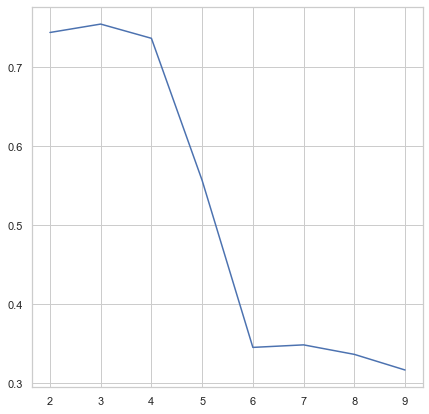

In [247]:
#plt.title("Silhouette Analysis Plot")
plt.figure(figsize=(7,7))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

**From Silhouette analysis and above plot we can see that the silhouette score is highest for the cluster =3 . This resonates
with the Elbow curve as well, so we will go ahead with 3 clusters**

In [248]:
# Final model with k=3:
kmeans = KMeans(n_clusters=3, max_iter=100)
kmeans.fit(temp_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [249]:
# Cluster labels generated by K-means:
kmeans.labels_

array([2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [250]:
# Creating a copy of the dataframe :
temp_df_kmeans = temp_df.copy()

In [251]:
# Assign the cluster labels to original dataframe: 
temp_df_kmeans['cluster_id'] = kmeans.labels_
temp_df_kmeans.head(5)

num_units                                          \
ds       2011-01-03 00:00:00 2011-01-10 00:00:00 2011-01-17 00:00:00   
class_id                                                               
499                   156486             1138871             1078343   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                                                                      \
ds       2011-01-24 00:00:00 2011-01-31 00:00:00 2011-02-07 00:00:00   
class_id                                                               
499                  1083136              926547              998591   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                                                                      \
ds       2011-02-14 00:00:00 2011-02-21 00:00:00 2011-02-28 00:00:00   
class_id                                                               
499                  1305816             1510951             1283208   
500                        0                   0                   0   
501                        0                   0                   0   
502                        0                   0                   0   
503                        0                   0                   0   

                              ...                                          \
ds       2011-03-07 00:00:00  ... 2019-04-15 00:00:00 2019-04-22 00:00:00   
class_id                      ...                                           
499                  1598172  ...                2900                2636   
500                        0  ...                   0                   0   
501                        0  ...               12864                9709   
502                        0  ...                8824                6347   
503                        0  ...                 755                 950   

                                                                      \
ds       2019-04-29 00:00:00 2019-05-06 00:00:00 2019-05-13 00:00:00   
class_id                                                               
499                     3854                8372                3961   
500                        0                   0                   0   
501                    11178                7792                6525   
502                     6116                2911                2421   
503                      886                 685                 556   

                                                                      \
ds       2019-05-20 00:00:00 2019-05-27 00:00:00 2019-06-03 00:00:00   
class_id                                                               
499                     2981                2598                2847   
500                        0                   0                   0   
501                     6719                6481                6621   
502                     2612                2390                2928   
503                      582                 665                 714   

                             cluster_id  
ds       2019-06-10 00:00:00             
class_id                                 
499                      292          2  
500                        0          0  
501                      448          0  
502                      168          0  
503                      110          0  

[5 rows x 442 columns]

In [252]:
# Checking the cluster count:
temp_df_kmeans['cluster_id'].value_counts()

0    130
1     12
2      1
Name: cluster_id, dtype: int64

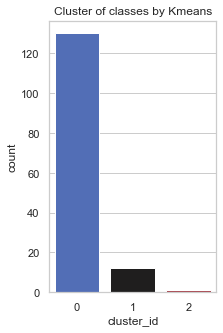

In [253]:
plt.figure(figsize=(3,5))

#plt.subplot(121)
plt.title("Cluster of classes by Kmeans")
sns.countplot(x="cluster_id", data=temp_df_kmeans, palette=("icefire"))
plt.show()

So, 130 classes belongs to cluster 1,12 to cluster 1 and only 1 class belongs to the cluster 2.
This result of (130,12,1) class grouping is little different from the result obtained from the hierarchial clustering which was (124,17,1, 1).  
**We had 4 clusters using the Hierarchical Agglomerative Clustering whereas K-Means has found only 3 different cluster of the 
classes. We will use the result from both and determine which one works better in TimeSeries prediction for our case.  
We will go ahead with the Hierarchical Agglomerative Clustering for our use case as its having more clusters and we assume that the more number of clusters will have more granularity of the classes.**  


In [254]:
# Let's now create the time series out of the clustered data :
def return_clustered_df(dataset,column,value):
    temp_df =  dataset[(dataset[column] ==value)]
    temp_df = temp_df.drop(column, 1)
    temp_df = temp_df.transpose()
    return temp_df

In [258]:
# Start with the Hierarchical Agglomerative Clustering:
agglomerative_ts_cluster1 = return_clustered_df(temp_df_agglomerative, 'cluster', 1)
agglomerative_ts_cluster2 = return_clustered_df(temp_df_agglomerative, 'cluster', 2)
agglomerative_ts_cluster3 = return_clustered_df(temp_df_agglomerative, 'cluster', 3)
agglomerative_ts_cluster4 = return_clustered_df(temp_df_agglomerative, 'cluster', 4)

agglomerative_ts_cluster3.head(2)

class_id                       500  501  503  504  505  506  510  519  520  \
          ds                                                                 
num_units 2011-01-03 00:00:00    0    0    0    0    0    0    0    0    0   
          2011-01-10 00:00:00    0    0    0    0    0    0    0    0    0   

class_id                       521  ...  733  735  736  737  738  739  740  \
          ds                        ...                                      
num_units 2011-01-03 00:00:00    0  ...    0    0    0    0    0    0    0   
          2011-01-10 00:00:00    0  ...    0    0    0    0    0    0    0   

class_id                       741  742  748  
          ds                                  
num_units 2011-01-03 00:00:00    0    0    0  
          2011-01-10 00:00:00    0    0    0  

[2 rows x 124 columns]

In [259]:
# Let's remove the multi-index from the dataframe : 
agglomerative_ts_cluster1.reset_index(inplace = True) 
agglomerative_ts_cluster1.set_index(['ds'], inplace = True) 
agglomerative_ts_cluster1.drop(['level_0'], axis = 1, inplace = True)

agglomerative_ts_cluster2.reset_index(inplace = True) 
agglomerative_ts_cluster2.set_index(['ds'], inplace = True) 
agglomerative_ts_cluster2.drop(['level_0'], axis = 1, inplace = True)

agglomerative_ts_cluster3.reset_index(inplace = True) 
agglomerative_ts_cluster3.set_index(['ds'], inplace = True) 
agglomerative_ts_cluster3.drop(['level_0'], axis = 1, inplace = True)

agglomerative_ts_cluster4.reset_index(inplace = True) 
agglomerative_ts_cluster4.set_index(['ds'], inplace = True) 
agglomerative_ts_cluster4.drop(['level_0'], axis = 1, inplace = True)

In [260]:
# Saving the classes of each cluster as list :
agglomerative_c1_classes = agglomerative_ts_cluster1.columns.tolist()
agglomerative_c2_classes = agglomerative_ts_cluster2.columns.tolist()
agglomerative_c3_classes = agglomerative_ts_cluster3.columns.tolist()
agglomerative_c4_classes = agglomerative_ts_cluster4.columns.tolist()

**Let's visualise the timeseries for each of the cluster in hierarchial clsutering :**

To get a feel for what this clustering method has actually produced, we can plot a sample of series from each cluster, and try and see what is in common between them.

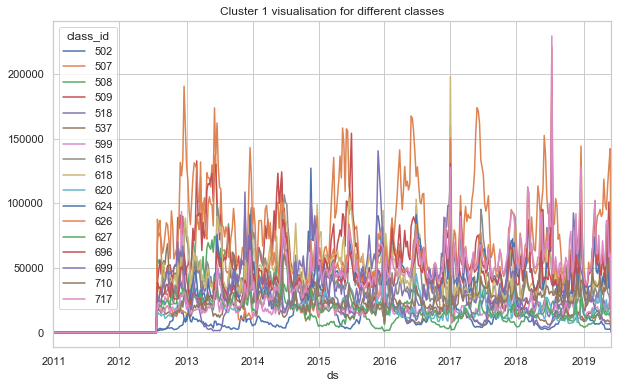

In [261]:
## Cluster 1 visualisation :
agglomerative_ts_cluster1.plot(y =agglomerative_c1_classes,kind = 'line', figsize=(10,6), 
                               title="Cluster 1 visualisation for different classes")


In [1155]:
# There are 17 classes in this cluster and its second highest cluster formed.
# These classses did not existed in the past before the mid of year 2012.

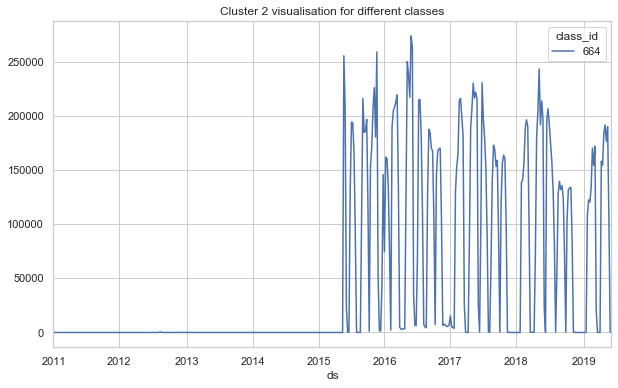

In [262]:
## Cluster 2 visualisation :
agglomerative_ts_cluster2.plot(y =agglomerative_c2_classes,kind = 'line', figsize=(10,6), 
                               title="Cluster 2 visualisation for different classes")


In [1157]:
# There is only 1 class which is 664 in this cluster.
# This class did not existed in the past before the mid of year 2015, relatively new class of products.

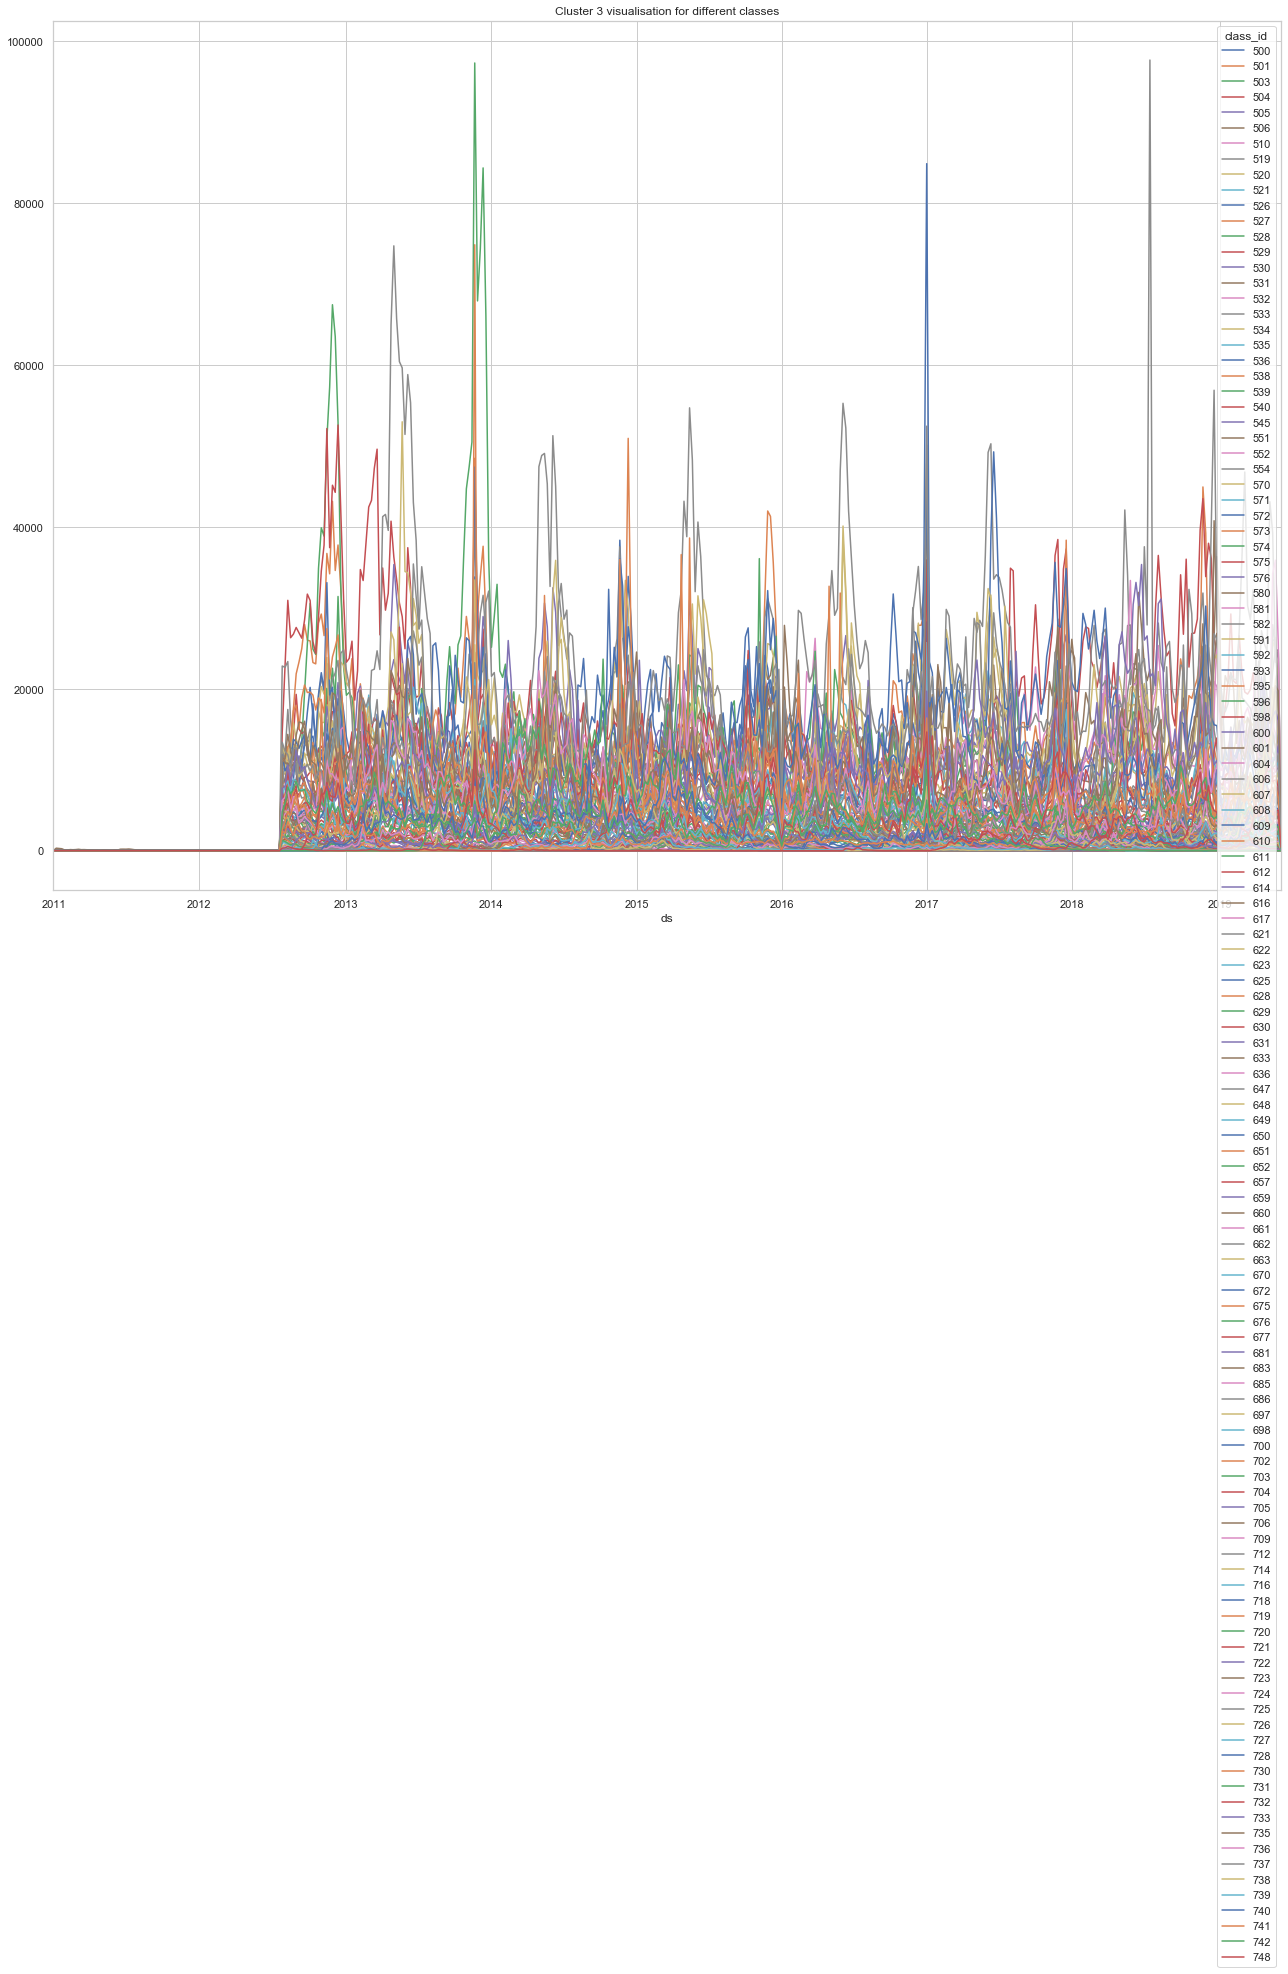

In [263]:
## Cluster 3 visualisation :
agglomerative_ts_cluster3.plot(y =agglomerative_c3_classes,kind = 'line', figsize=(22,16), 
                               title="Cluster 3 visualisation for different classes")


In [1159]:
# Most densed cluster having the highest number of product classes embedded.
# None of these products existed before the mid year 2012. 

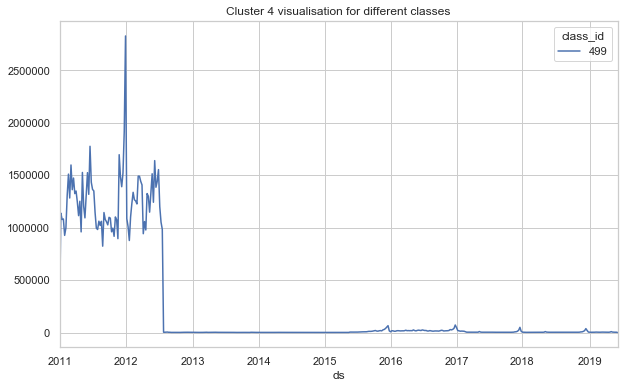

In [264]:
## Cluster 4 visualisation :
agglomerative_ts_cluster4.plot(y =agglomerative_c4_classes,kind = 'line', figsize=(10,6), 
                               title="Cluster 4 visualisation for different classes")


In [265]:
# Only 1 class in the fourth cluster which is 499 (imputed class by us for missing values), these seems to be the only product 
# class which existed before mid 2012.
# Also the units movements are strikingly high ranging between 1000000 to 3000000 units per week.
# The unit movement became flat after 2013. 

# This suggests that the unit movement was not recorded correctly before the year mid 2012 as there are high missing value which
# is being represented by class 499.

In [266]:
# Add new column in dataframe which will be the mean and sum of value for each time-stamp, this should represent the whole 
# cluster as such :

#agglomerative_ts_cluster1['mean'] = agglomerative_ts_cluster1.iloc[:,0:-1].mean(axis=1)
agglomerative_ts_cluster1['sum'] = agglomerative_ts_cluster1.iloc[:,0:-1].sum(axis=1)

#agglomerative_ts_cluster2['mean'] = agglomerative_ts_cluster2.iloc[:,:].mean(axis=1)
agglomerative_ts_cluster2['sum'] = agglomerative_ts_cluster2.iloc[:,:].sum(axis=1)

#agglomerative_ts_cluster3['mean'] = agglomerative_ts_cluster3.iloc[:,0:-1].mean(axis=1)
agglomerative_ts_cluster3['sum'] = agglomerative_ts_cluster3.iloc[:,0:-1].sum(axis=1)

# agglomerative_ts_cluster4['mean'] = agglomerative_ts_cluster4.iloc[:,:].mean(axis=1)
agglomerative_ts_cluster4['sum'] = agglomerative_ts_cluster4.iloc[:,:].sum(axis=1)

In [267]:
# Lets have the time series for each cluster as sum and means , converting series to dataframe:

agglomerative_ts_sum_c1 = agglomerative_ts_cluster1.iloc[:,-1]
agglomerative_ts_sum_c1 = pd.DataFrame(agglomerative_ts_sum_c1)

#agglomerative_ts_mean_c1 = agglomerative_ts_cluster1.iloc[:,-2]
#agglomerative_ts_mean_c1 = pd.DataFrame(agglomerative_ts_mean_c1)

agglomerative_ts_sum_c2 = agglomerative_ts_cluster2.iloc[:,-1]
agglomerative_ts_sum_c2 = pd.DataFrame(agglomerative_ts_sum_c2)

#agglomerative_ts_mean_c2 = agglomerative_ts_cluster2.iloc[:,-2]
#agglomerative_ts_mean_c2 = pd.DataFrame(agglomerative_ts_mean_c2)

agglomerative_ts_sum_c3 = agglomerative_ts_cluster3.iloc[:,-1]
agglomerative_ts_sum_c3 = pd.DataFrame(agglomerative_ts_sum_c3)

#agglomerative_ts_mean_c3 = agglomerative_ts_cluster3.iloc[:,-2]
#agglomerative_ts_mean_c3 = pd.DataFrame(agglomerative_ts_mean_c3)

agglomerative_ts_sum_c4 = agglomerative_ts_cluster4.iloc[:,-1]
agglomerative_ts_sum_c4 = pd.DataFrame(agglomerative_ts_sum_c4)

#agglomerative_ts_mean_c4 = agglomerative_ts_cluster4.iloc[:,-2]
#agglomerative_ts_mean_c4 = pd.DataFrame(agglomerative_ts_mean_c4)

In [268]:
def rename_columns(dataframe):
    dataframe.rename(columns={ dataframe.columns[0]: "y" }, inplace = True)
    return dataframe

In [269]:
agglomerative_ts_sum_c1 = rename_columns(agglomerative_ts_sum_c1)
#agglomerative_ts_mean_c1 = rename_columns(agglomerative_ts_mean_c1)
agglomerative_ts_sum_c2 = rename_columns(agglomerative_ts_sum_c2)
#agglomerative_ts_mean_c2 = rename_columns(agglomerative_ts_mean_c2)
agglomerative_ts_sum_c3 = rename_columns(agglomerative_ts_sum_c3)
#agglomerative_ts_mean_c3 = rename_columns(agglomerative_ts_mean_c3)
agglomerative_ts_sum_c4 = rename_columns(agglomerative_ts_sum_c4)
#agglomerative_ts_mean_c4 = rename_columns(agglomerative_ts_mean_c4)

In [270]:
# Train-test split :
# Using the split function created by us :

#train_ats_mean_c1,test_ats_mean_c1=split(agglomerative_ts_mean_c1)
#train_ats_mean_c2,test_ats_mean_c2=split(agglomerative_ts_mean_c2)
#train_ats_mean_c3,test_ats_mean_c3=split(agglomerative_ts_mean_c3)
#train_ats_mean_c4,test_ats_mean_c4=split(agglomerative_ts_mean_c4)

train_ats_sum_c1,test_ats_sum_c1=split(agglomerative_ts_sum_c1)
train_ats_sum_c2,test_ats_sum_c2=split(agglomerative_ts_sum_c2)
train_ats_sum_c3,test_ats_sum_c3=split(agglomerative_ts_sum_c3)
train_ats_sum_c4,test_ats_sum_c4=split(agglomerative_ts_sum_c4)

In [271]:
#train_ats_mean_c1.reset_index(inplace=True)
#test_ats_mean_c1.reset_index(inplace=True)
#train_ats_mean_c2.reset_index(inplace=True)
#test_ats_mean_c2.reset_index(inplace=True)
#train_ats_mean_c3.reset_index(inplace=True)
#test_ats_mean_c3.reset_index(inplace=True)
#train_ats_mean_c4.reset_index(inplace=True)
#test_ats_mean_c4.reset_index(inplace=True)

#agglomerative_ts_mean_c1.reset_index(inplace=True)
#agglomerative_ts_mean_c2.reset_index(inplace=True)
#agglomerative_ts_mean_c3.reset_index(inplace=True)
#agglomerative_ts_mean_c4.reset_index(inplace=True)

train_ats_sum_c1.reset_index(inplace=True)
test_ats_sum_c1.reset_index(inplace=True)
train_ats_sum_c2.reset_index(inplace=True)
test_ats_sum_c2.reset_index(inplace=True)
train_ats_sum_c3.reset_index(inplace=True)
test_ats_sum_c3.reset_index(inplace=True)
train_ats_sum_c4.reset_index(inplace=True)
test_ats_sum_c4.reset_index(inplace=True)

agglomerative_ts_sum_c1.reset_index(inplace=True)
agglomerative_ts_sum_c2.reset_index(inplace=True)
agglomerative_ts_sum_c3.reset_index(inplace=True)
agglomerative_ts_sum_c4.reset_index(inplace=True)

### Fbprophet for the prediction :

In [272]:
# Let's create a function to be used for each channel to apply prophet :
def apply_prophet_clustering(dataframe):
    #growth='logistic', changepoint_prior_scale=16.99
    pro_channel_full= Prophet(interval_width=0.90, n_changepoints=20, yearly_seasonality=True,
                              changepoint_prior_scale=0.05)
    # Using the built in prophet US holiday list :
    pro_channel_full.add_country_holidays(country_name='US')
    pro_channel_full.fit(dataframe)

    #  We've instantiated the model, now we need to build some future dates to forecast into.
    # Predicting for next 22 weeks 
    future_data_full = pro_channel_full.make_future_dataframe(periods=20, freq = 'w')
 
    # forecast the data for future data, To forecast this future data, we need to run it through Prophet's model:
    forecast_data_full = pro_channel_full.predict(future_data_full)
    pro_channel_full.plot(forecast_data_full)
    
    # Using the cross_validation() of fbprophet :
    cv_results = cross_validation(pro_channel_full, initial = pd.to_timedelta(410,unit="w"),period=pd.to_timedelta(53,unit="w"),
                             horizon = pd.to_timedelta(17,unit="w"))

    print("\nBelow is the cross validation result for this model : \n")
    print(cv_results.tail())
    
    # Check the trends and seasonality components:
    fig1 = pro_channel_full.plot_components(forecast_data_full)
    
    # performance_metrics:
    performance_metrics_results = performance_metrics(cv_results)
    print("\nBelow is the performance metric for this model: \n")
    print(performance_metrics_results)
    
    # Let's check the average MAPE found using the fbprophet evaluation metrics :
    mape_result = performance_metrics_results.iloc[0:12,4]
    MAPE = mape_result.mean()
    print("\nMAPE for next 91 days is :",MAPE )
    
    # Let's visualise the MAPE of the model over the horizon/future dates :
    fig2 = plot_cross_validation_metric(cv_results, metric='mape')
    
    return cv_results

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-11 00:00:00 and 2019-02-11 00:00:00



Below is the cross validation result for this model : 

           ds           yhat     yhat_lower     yhat_upper       y     cutoff
12 2019-05-13  487042.513292  297152.608859  675525.918839  591084 2019-02-11
13 2019-05-20  477750.035020  285951.637242  669413.201477  639594 2019-02-11
14 2019-05-27  508330.865035  301665.467683  716052.449387  598243 2019-02-11
15 2019-06-03  478561.692369  280139.939465  676290.869028  555055 2019-02-11
16 2019-06-10  521837.597590  327618.545916  709233.914958   51344 2019-02-11

Below is the performance metric for this model: 

    horizon           mse           rmse            mae      mape     mdape  \
0    7 days  1.803296e+10  134286.856577  134286.856577  0.336232  0.336232   
1   14 days  1.125919e+08   10610.934669   10610.934669  0.020693  0.020693   
2   21 days  1.189600e+08   10906.879215   10906.879215  0.021171  0.021171   
3   28 days  6.427181e+09   80169.702076   80169.702076  0.134205  0.134205   
4   35 days  2.578203e+08   1

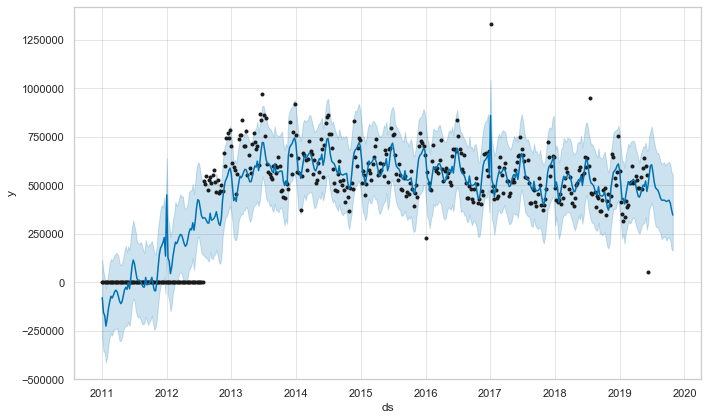

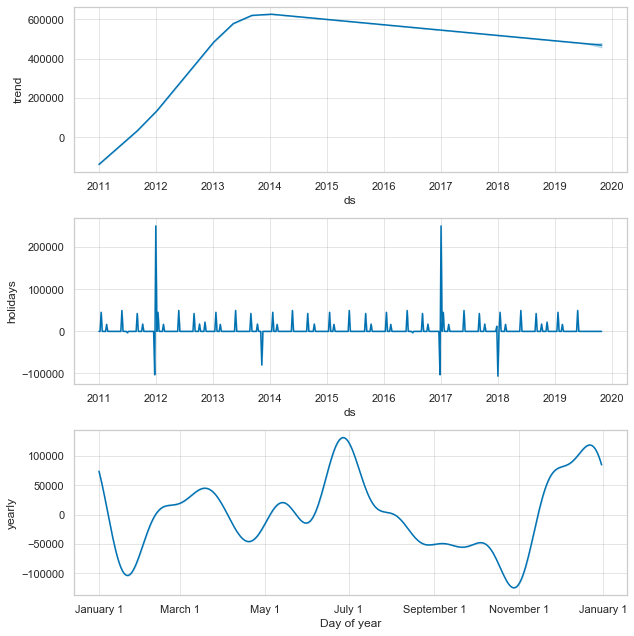

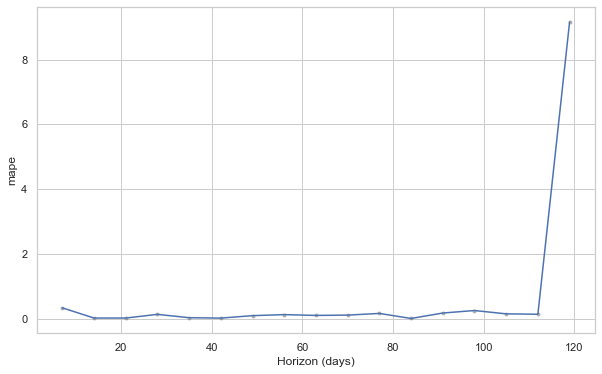

In [273]:
# Let's forecast for the cluster1 first :
cv_results_cluster1 = apply_prophet_clustering(agglomerative_ts_sum_c1)

In [1284]:
print(agglomerative_c1_classes)

[502, 507, 508, 509, 518, 537, 599, 615, 618, 620, 624, 626, 627, 696, 699, 710, 717]


#### Understanding the Cluster1 prediction results :  
The black dots are actual data points, dark blue plot is the prediction curve and the light blue hue plot is the range of prediction with 90 % cconfidence interval.  
The classes belonging to this cluster are : 502,
 507,
 508,
 509,
 518,
 537,
 599,
 615,
 618,
 620,
 624,
 626,
 627,
 696,
 699,
 710,
 717
    
The trend is very clear that the units movement data was missing before the year 2013 for these classes and its having slight
downward trend over the consecutive years from 2013 onwards.   
The effect of holidays is more or less same across the years denoted by spikes except for 2 years 2012 and 2017 where it shooted for the holidays. 2014 and 2018 years saw neagtive effect of holiday in the unit movement i.e. the unit movements dropped instead of the increase in holiday season.     
June to August months every year has highest peak of the unit movements of the products belonging to this class , followed by similar peak from Mid Novemeber to mid January.   
The MAPE for prediction duration is 0.09 or 9.74% which is quite good and through this model we can predict with similar accuray for the next 110 days time period.

In [274]:
# Joining the test and predicted data on the timestamp ds 
joined_df_c1 = make_comparison_dataframe(test_ats_sum_c1,cv_results_cluster1)

# Forcing panda to use the non-scientific notation :
joined_df_c1['yhat'] = joined_df_c1['yhat'].astype('int64')  

# Renaming :
joined_df_c1.rename(columns={'yhat':'Predicted_Total_Units_Cluster1', 'y':'Actual_Total_Units_Cluster1'},inplace=True)

# Drop columns not needed :
joined_df_c1 = joined_df_c1.drop(joined_df_c1.columns[[1, 2]], axis=1) 

# Also, we want to save result between week number 2019-03-11 and 2019-06-03 only :
joined_df_c1 = joined_df_c1.iloc[2:16,:]
joined_df_c1.dropna(inplace=True)

joined_df_c1 = joined_df_c1.astype({'Actual_Total_Units_Cluster1': int})
joined_df_c1

Predicted_Total_Units_Cluster1  Actual_Total_Units_Cluster1
ds                                                                     
2019-03-18                          529310                       513254
2019-03-25                          523960                       514106
2019-04-01                          496607                       548645
2019-04-08                          459756                       526572
2019-04-15                          433811                       483156
2019-04-22                          432452                       486657
2019-04-29                          452870                       541394
2019-05-06                          477439                       481120
2019-05-13                          487042                       591084
2019-05-20                          477750                       639594
2019-05-27                          508330                       598243
2019-06-03                          478561                       555055

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-11 00:00:00 and 2019-02-11 00:00:00



Below is the cross validation result for this model : 

           ds           yhat     yhat_lower     yhat_upper       y     cutoff
12 2019-05-13  167647.161246   66770.329898  262745.094763  176880 2019-02-11
13 2019-05-20  171482.924500   79984.327086  266250.895646  190265 2019-02-11
14 2019-05-27  205641.984995  109545.778750  293073.417959  104419 2019-02-11
15 2019-06-03  132060.161008   35124.092185  223778.084336     353 2019-02-11
16 2019-06-10  108558.920635    8548.559349  200886.218919      36 2019-02-11

Below is the performance metric for this model: 

    horizon           mse           rmse            mae          mape  \
0    7 days  3.707098e+08   19253.825748   19253.825748      0.143821   
1   14 days  2.909646e+08   17057.685258   17057.685258      0.100026   
2   21 days  3.589917e+06    1894.707576    1894.707576      0.012252   
3   28 days  7.697569e+08   27744.493800   27744.493800      0.161020   
4   35 days  9.562312e+09   97787.072301   97787.072301    

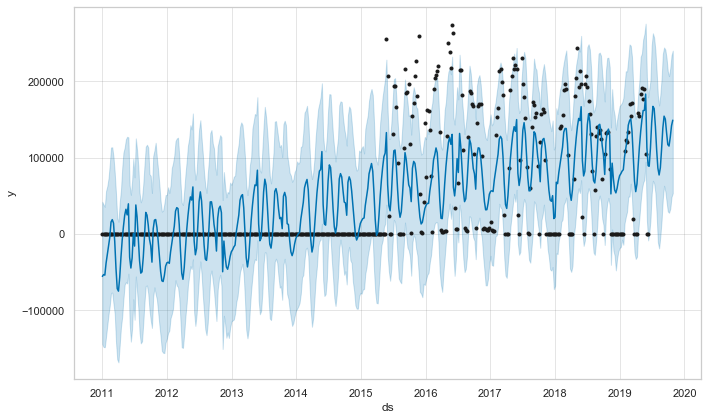

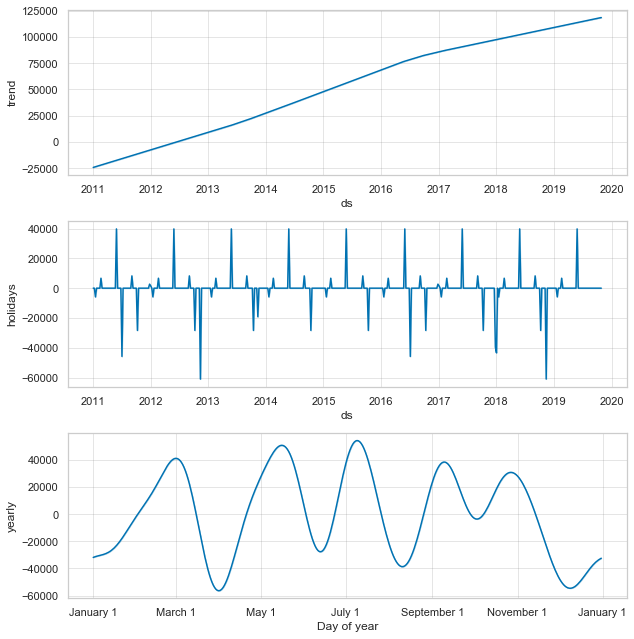

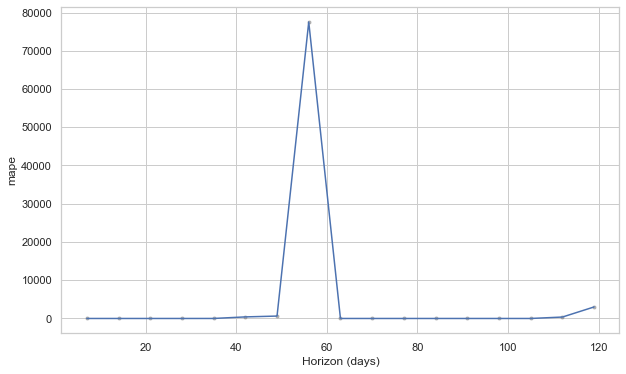

In [275]:
# Let's forecast for the cluster2 :
cv_results_cluster2 = apply_prophet_clustering(agglomerative_ts_sum_c2)

In [276]:
print(agglomerative_c2_classes)

[664]


#### Understanding the Cluster2 prediction results :  
The black dots are actual data points, dark blue plot is the prediction curve and the light blue hue plot is the range of prediction with 90 % cconfidence interval.  
The only class belonging to this cluster is 664 class.  
    
The trend is very clear that the units movement data was missing before the mid year 2015 for this class, so relatively its a new class of products. Itss having slight upward trend over the consecutive years from 2016 onwards.   
The effect of holidays is very similar for all the years , this suggests that the products sold in this class are popular among the consumers during the holiday seasons.   
There are 4 peaks every year for this class and these are Mid Feb to Mid April, May to June, Mid July to August, September to November.
The MAPE for prediction duration is high which and from MAPE plot we can predict only for 45 days with good accuracy for this cluster. Also, please note that this cluster has only 1 class out of total 143 classes, so the reduced accuracy for this one class should not matter much. We can always revisit the accuracy for this class 664 later.

In [277]:
# Joining the test and predicted data on the timestamp ds 
joined_df_c2 = make_comparison_dataframe(test_ats_sum_c2,cv_results_cluster2)

# Forcing panda to use the non-scientific notation :
joined_df_c2['yhat'] = joined_df_c2['yhat'].astype('int64')  

# Renaming :
joined_df_c2.rename(columns={'yhat':'Predicted_Total_Units_Cluster2', 'y':'Actual_Total_Units_Cluster2'},inplace=True)

# Drop columns not needed :
joined_df_c2 = joined_df_c2.drop(joined_df_c2.columns[[1, 2]], axis=1) 

# Also, we want to save result between week number 2019-03-11 and 2019-06-03 only :
joined_df_c2 = joined_df_c2.iloc[2:16,:]
joined_df_c2.dropna(inplace=True)

joined_df_c2 = joined_df_c2.astype({'Actual_Total_Units_Cluster2': int})
joined_df_c2

Predicted_Total_Units_Cluster2  Actual_Total_Units_Cluster2
ds                                                                     
2019-03-18                          118011                        20224
2019-03-25                           88941                          216
2019-04-01                           73098                          116
2019-04-08                           77526                            1
2019-04-15                           96291                       158356
2019-04-22                          118241                       154753
2019-04-29                          137342                       184116
2019-05-06                          154023                       192067
2019-05-13                          167647                       176880
2019-05-20                          171482                       190265
2019-05-27                          205641                       104419
2019-06-03                          132060                          353

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-11 00:00:00 and 2019-02-11 00:00:00



Below is the cross validation result for this model : 

           ds           yhat     yhat_lower     yhat_upper       y     cutoff
12 2019-05-13  543610.286831  383142.814893  712507.580866  554994 2019-02-11
13 2019-05-20  523749.437997  357945.026764  687139.450265  626730 2019-02-11
14 2019-05-27  567693.052642  387723.626239  728590.211475  634178 2019-02-11
15 2019-06-03  538826.199250  361691.471403  697966.757559  617881 2019-02-11
16 2019-06-10  571237.436605  400211.395402  743159.605157   54552 2019-02-11

Below is the performance metric for this model: 

    horizon           mse           rmse            mae      mape     mdape  \
0    7 days  8.748847e+09   93535.272912   93535.272912  0.223644  0.223644   
1   14 days  8.911355e+07    9439.997469    9439.997469  0.019121  0.019121   
2   21 days  2.139272e+07    4625.226038    4625.226038  0.009424  0.009424   
3   28 days  1.137411e+08   10664.946285   10664.946285  0.020404  0.020404   
4   35 days  1.134012e+08   1

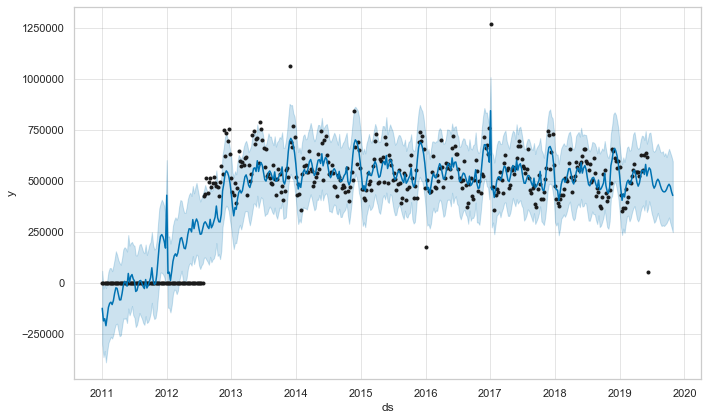

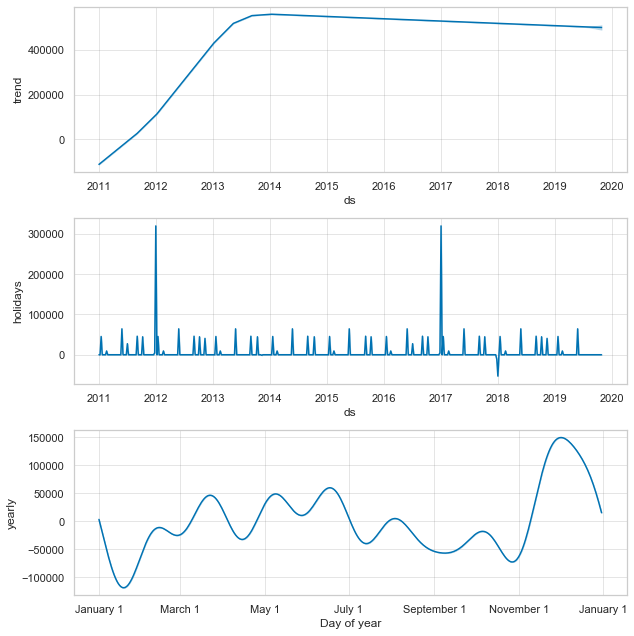

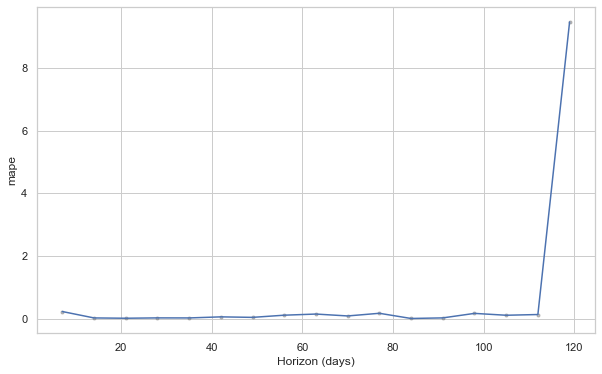

In [278]:
# Let's forecast for the cluster3 :
cv_results_cluster3 = apply_prophet_clustering(agglomerative_ts_sum_c3)

In [1290]:
print(agglomerative_c3_classes)

[500, 501, 503, 504, 505, 506, 510, 519, 520, 521, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 538, 539, 540, 545, 551, 552, 554, 570, 571, 572, 573, 574, 575, 576, 580, 581, 582, 591, 592, 593, 595, 596, 598, 600, 601, 604, 606, 607, 608, 609, 610, 611, 612, 614, 616, 617, 621, 622, 623, 625, 628, 629, 630, 631, 633, 636, 647, 648, 649, 650, 651, 652, 657, 659, 660, 661, 662, 663, 670, 672, 675, 676, 677, 681, 683, 685, 686, 697, 698, 700, 702, 703, 704, 705, 706, 709, 712, 714, 716, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 730, 731, 732, 733, 735, 736, 737, 738, 739, 740, 741, 742, 748]


#### Understanding the Cluster3 prediction results :  
The black dots are actual data points, dark blue plot is the prediction curve and the light blue hue plot is the range of prediction with 90 % cconfidence interval.    
This is the biggest cluster of the classes and it has below classes :  
500, 501, 503, 504, 505, 506, 510, 519, 520, 521, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 538, 539, 540, 545, 551, 552, 554, 570, 571, 572, 573, 574, 575, 576, 580, 581, 582, 591, 592, 593, 595, 596, 598, 600, 601, 604, 606, 607, 608, 609, 610, 611, 612, 614, 616, 617, 621, 622, 623, 625, 628, 629, 630, 631, 633, 636, 647, 648, 649, 650, 651, 652, 657, 659, 660, 661, 662, 663, 670, 672, 675, 676, 677, 681, 683, 685, 686, 697, 698, 700, 702, 703, 704, 705, 706, 709, 712, 714, 716, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 730, 731, 732, 733, 735, 736, 737, 738, 739, 740, 741, 742, 748
      
The trend is very clear that the units movement data was missing before the mid year 2012 for this class, so relatively its a new class of products. Its having slight downward trend over the consecutive years from 2013 onwards.   
The effect of holidays is very high for the years 2012 and 2017, on the otherhand for rest of the years there are small identical spikes for each year.

The biggest peaks for the product movement for this class is between Mid November to Mid January, this suggests that the products belonging to these classes are mainly sold during the main holiday season for US and these products might not be the regular daily-wear apparels.  
The MAPE for prediction duration is 0.073 or 7.3 % which is quite good and through this model we can predict with good accuray for the next 110 days time period for highest number of classes.

In [279]:
# Joining the test and predicted data on the timestamp ds 
joined_df_c3 = make_comparison_dataframe(test_ats_sum_c3,cv_results_cluster3)

# Forcing panda to use the non-scientific notation :
joined_df_c3['yhat'] = joined_df_c3['yhat'].astype('int64')  

# Renaming :
joined_df_c3.rename(columns={'yhat':'Predicted_Total_Units_Cluster3', 'y':'Actual_Total_Units_Cluster3'},inplace=True)

# Drop columns not needed :
joined_df_c3 = joined_df_c3.drop(joined_df_c3.columns[[1, 2]], axis=1) 

# Also, we want to save result between week number 2019-03-11 and 2019-06-03 only :
joined_df_c3 = joined_df_c3.iloc[2:16,:]
joined_df_c3.dropna(inplace=True)

joined_df_c3 = joined_df_c3.astype({'Actual_Total_Units_Cluster3': int})
joined_df_c3

Predicted_Total_Units_Cluster3  Actual_Total_Units_Cluster3
ds                                                                     
2019-03-18                          543361                       554010
2019-03-25                          550802                       581830
2019-04-01                          523793                       544077
2019-04-08                          483292                       541063
2019-04-15                          463890                       541297
2019-04-22                          481987                       525387
2019-04-29                          520848                       625653
2019-05-06                          547267                       546226
2019-05-13                          543610                       554994
2019-05-20                          523749                       626730
2019-05-27                          567693                       634178
2019-06-03                          538826                       617881

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-11 00:00:00 and 2019-02-11 00:00:00



Below is the cross validation result for this model : 

           ds           yhat     yhat_lower     yhat_upper     y     cutoff
12 2019-05-13   66563.514170 -247148.399511  405948.612128  3961 2019-02-11
13 2019-05-20   54537.246276 -278289.336270  358536.121228  2981 2019-02-11
14 2019-05-27  105876.227272 -219480.537401  424592.852376  2598 2019-02-11
15 2019-06-03   87654.919577 -224108.954506  415600.404066  2847 2019-02-11
16 2019-06-10  127112.756636 -196749.347812  448190.079495   292 2019-02-11

Below is the performance metric for this model: 

    horizon           mse           rmse            mae        mape  \
0    7 days  2.167763e+09   46559.243695   46559.243695   16.027278   
1   14 days  1.264375e+09   35558.047769   35558.047769   11.743081   
2   21 days  2.464293e+09   49641.649686   49641.649686   17.875999   
3   28 days  3.966957e+09   62983.782083   62983.782083   16.706573   
4   35 days  6.324959e+09   79529.608453   79529.608453   21.224875   
5   42 day

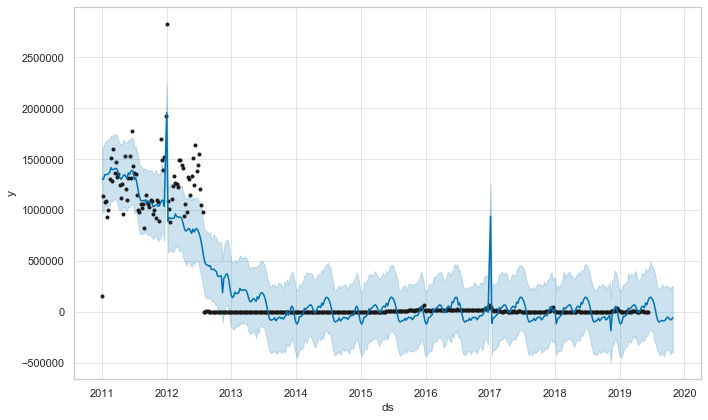

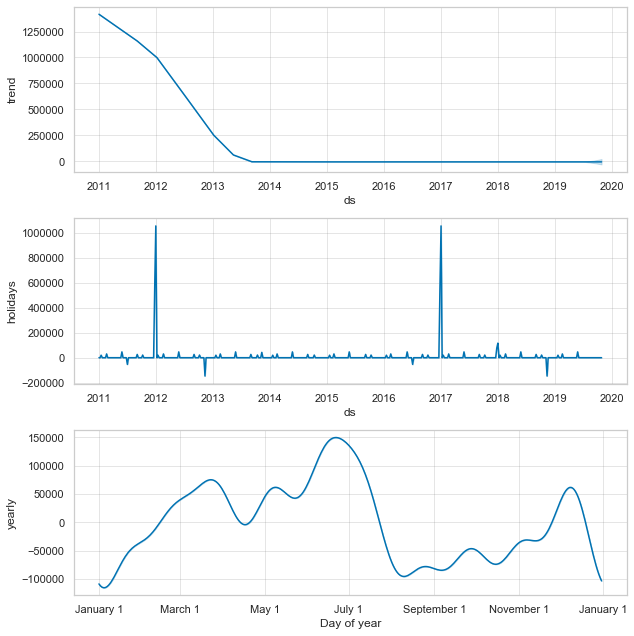

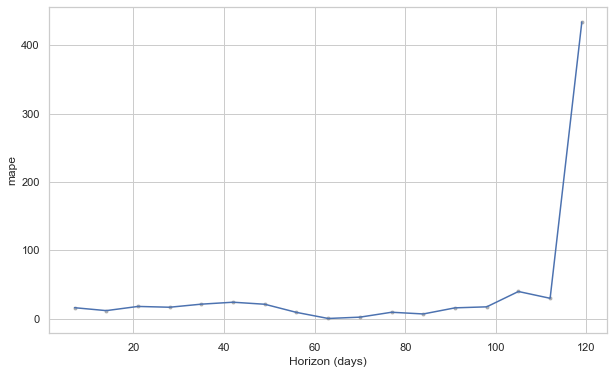

In [280]:
# Let's forecast for the cluster4 :
cv_results_cluster4 = apply_prophet_clustering(agglomerative_ts_sum_c4)

In [1291]:
print(agglomerative_c4_classes)

[499]


#### Understanding the Cluster4 prediction results :  
The black dots are actual data points, dark blue plot is the prediction curve and the light blue hue plot is the range of prediction with 90 % cconfidence interval.  
The only class belonging to this cluster is 499 class, which is dummy class that we have created for the missing values of class in the dataset, 
    
The trend is very clear that the units movement data was missing after the year 2014 for this class, so we can conclude that the missing classese are not there in the dataset in recent years. Its having steep downward trend from the year 2014 and it has fell flat completely in last 5 years. We can infer that data quality is good from 2014 as we dont have any missing classes 
in the dataset provided.  
The effect of holidays is very similar for all the years except spike in 2012 and 2017, this suggests that the products sold in this class may be from the many classes for which the data is missing.   
The biggest peak observed seasonally for all eligible years is between month of May to Mid August followed by smaller peaks in April and December.   
The MAPE for prediction duration is 13.04 which is not great but again please remember that this cluster represents only 1 class 499 and this class is the dummy class that we have created for the missing data of class in the dataset. We can revisit on this if needed in future.

In [281]:
# Joining the test and predicted data on the timestamp ds 
joined_df_c4 = make_comparison_dataframe(test_ats_sum_c4,cv_results_cluster4)

# Forcing panda to use the non-scientific notation :
joined_df_c4['yhat'] = joined_df_c4['yhat'].astype('int64')  

# Renaming :
joined_df_c4.rename(columns={'yhat':'Predicted_Total_Units_Cluster4', 'y':'Actual_Total_Units_Cluster4'},inplace=True)

# Drop columns not needed :
joined_df_c4 = joined_df_c4.drop(joined_df_c4.columns[[1, 2]], axis=1) 

# Also, we want to save result between week number 2019-03-11 and 2019-06-03 only :
joined_df_c4 = joined_df_c4.iloc[2:16,:]
joined_df_c4.dropna(inplace=True)

joined_df_c4 = joined_df_c4.astype({'Actual_Total_Units_Cluster4': int})
joined_df_c4

Predicted_Total_Units_Cluster4  Actual_Total_Units_Cluster4
ds                                                                     
2019-03-18                           83276                         3747
2019-03-25                           88499                         3532
2019-04-01                           68132                         3086
2019-04-08                           29651                         2919
2019-04-15                            2157                         2900
2019-04-22                            8417                         2636
2019-04-29                           39965                         3854
2019-05-06                           65838                         8372
2019-05-13                           66563                         3961
2019-05-20                           54537                         2981
2019-05-27                          105876                         2598
2019-06-03                           87654                         2847

In [282]:
# Let's join all the channels outlet together to form single dataframe :

# List of the individual dataframes:
data_frames = [joined_df_c1, joined_df_c2, joined_df_c3,joined_df_c4]

df_merged_clusters = reduce(lambda  left,right: pd.merge(left,right,on=['ds'],
                                            how='outer'), data_frames).fillna('void')

df_merged_clusters.head()

Predicted_Total_Units_Cluster1  Actual_Total_Units_Cluster1  \
ds                                                                        
2019-03-18                          529310                       513254   
2019-03-25                          523960                       514106   
2019-04-01                          496607                       548645   
2019-04-08                          459756                       526572   
2019-04-15                          433811                       483156   

            Predicted_Total_Units_Cluster2  Actual_Total_Units_Cluster2  \
ds                                                                        
2019-03-18                          118011                        20224   
2019-03-25                           88941                          216   
2019-04-01                           73098                          116   
2019-04-08                           77526                            1   
2019-04-15                           96291                       158356   

            Predicted_Total_Units_Cluster3  Actual_Total_Units_Cluster3  \
ds                                                                        
2019-03-18                          543361                       554010   
2019-03-25                          550802                       581830   
2019-04-01                          523793                       544077   
2019-04-08                          483292                       541063   
2019-04-15                          463890                       541297   

            Predicted_Total_Units_Cluster4  Actual_Total_Units_Cluster4  
ds                                                                       
2019-03-18                           83276                         3747  
2019-03-25                           88499                         3532  
2019-04-01                           68132                         3086  
2019-04-08                           29651                         2919  
2019-04-15                            2157                         2900

**_Submission of results from model:_**

In [283]:
# Saving the prediction data to the csv file : 
df_merged_clusters.to_csv("weekly_forecast_class_clusters.csv", encoding='utf-8', index=True, index_label='DateTime')

# Step 3 : Recommendations from the case study:
  

### 3.1 Week level summary and recommendations:    

1. The higher value of number of units movements is considerably higher at week =>50 i.e towards the end of the year. This suggests that the November, December is important period for the retailer and inventory should be arranged accordingly for all the channels. For an instance the spike towards the end of year suggests important dates like Halloween, Black Friday, Cyber Monday, Christmas Day, Boxing Day etc. in last 3 quarter of the every year.    
2. The highest bin or bracket of inventory movement is for the size between 1000 and 10000 units, so accordingly the logistics and space planning should be done inorder to ensure we dont underutilise or overutilise the existing resources/infrastructures.  3. The time-series has seasonality pattern, such as total unit movements per week always shoot up during the end of current and start of new year. Also, apart from this, here always 2-3 spikes can be observed within any single year with a couple of low months in between these spikes. We can plan to utilise this data to increase the sales/demand in the period where its going flat every year. On the other hand, higher unit movement months are important for multi-channel retailers for their inventory planning, logistics arrangement, promotion setup and marketting to get the best out of these important dates.       
4. If we see overall trend this is non-linear trend of unit movement. The units movement increase from 2011 and reached its peak in the year 2016-17 and there is a downward trend in the same from post this till the year 2019. This was confirmed by the changepoint plot as well.  So, we should work towards improving our business in terms of sales to stop this overall trend to continue.   
  

### 3.2 Channel level summary and recommendations:  
  
1. There are three channels through which products are sold which are Ecommerce, Outlet and Retail channel . Retail stores has maximum no of the units movement across the time and its more than twice the unit movement of the ecommerce and outlet channel combined. This suggests that the muti-channel retailer has been predominently setup and recognised by customers as Brick and Mortar retailer So, we should focus on increasing the unit movement for ecommerce, outlets further and continue with the Retail stores performance.    
2. If we talk about the overall trend, there has been a downward trend in the units movement for the stores belonging to the retail and outlet channels. On the other hand good news is there is a upward trend in the same for the ecommerce channel across the multiple years. This means that ecommerce is potentially the channel to which we should shift our focus to immediately for the future.  
3. The seasonality observed for the ecommerce channel is Mid November to December has highest unit movement every year followed by peak in July month every year. March to September months has highest unit movement every year followed by peak in November-December every year for outlet stores. Likewise for retail stores May to Mid August months has highest unit movement every year followed by peak in November-December every year.
4. The effect of holidays is more or less same across the years denoted by spikes except for 2 years 2012 and 2017 for all 3 channels. 
5. From the yearly seasonality and effect of holidays that we have seen, the unit movement more or less resonates the US public holidays and ecommerce events as below and these dates/months is crucial for the business:  
Valentine's Day – February  
St. Patrick's Day - March  
Easter - April  
Mother's Day - May  
Memorial Day - May  
Father's Day - June  
Back to school (August 1 through Labour Day)  
Halloween - October  
Veteran's Day - Novemeber  
Thanksgiving Day - Novemeber  
Black Friday - November  
Cyber Monday - November  
Christmas- December  
Boxing Day - December  


### 3.3 Class level summary and recommendations:  

1. There are 143 distinct product classes are available for this brand , class 499 represents the dummy class created for missing value of class in the dataset. Class 499 (imputed by us for missing values) has highest no of unit movements which is more than the combined sum of unit movements of remaining classes.     
2. From Pareto chart, we can conclude that out of the 143 classes, the products/SKU's belonging to just below 20 classes contributes to the 65 % of the total unit movements :     
**499 626 664 507 509 618 717 696 624 615 699 518 710 508 537 620 599 627 502 712** 
This is an important information for the business, so that business can focus more on the branding, procurring , selling and ofcourse inventory management of the products belonging to these 20 classes.  
3. 4 clusters are formed for these 143 classes in our case study. The most densed cluster is having 124 classes. The second most densed cluster is having 17 classes.None of the products existed before the mid year 2012 for the classes belonging to these two clusters.
4. Only 1 class in the fourth cluster which is 499 (imputed class by us for missing values), these seems to be the only product class which existed before mid 2012. Also the units movements are strikingly high ranging between 1000000 to 3000000 units per week. The unit movement became flat after 2013. This suggests that the unit movement was not recorded correctly before the year mid 2012 as there are high missing value which is being represented by class 499.  
5. The classes belonging to the cluster having 17 classes are :     
**502, 507, 508, 509, 518, 537, 599, 615, 618, 620, 624, 626, 627, 696, 699, 710, 717.**                                        The trend is very clear that the units movement data was missing before the year 2013 for these classes and its having slight downward trend over the consecutive years from 2013 onwards. The effect of holidays is more or less same across the years denoted by spikes except for 2 years 2012 and 2017 where it shooted for the holidays. 
June to August months every year has highest peak of the unit movements of the products belonging to this class , followed by similar peak from Mid Novemeber to mid January.  
6. The only class belonging to 2nd cluster is 664 class. The trend is very clear that the units movement data was missing before the mid year 2015 for this class, so relatively its a new class of products. Its having slight upward trend over the consecutive years from 2016 onwards. The effect of holidays is very similar for all the years , this suggests that the products sold in this class are popular among the consumers during the holiday seasons. There are 4 peaks every year for this class and these are Mid Feb to Mid April, May to June, Mid July to August, September to November. The product seems to be in demand for this class.  
7. Third cluster is the biggest cluster of the classes and it has below classes :  
**500, 501, 503, 504, 505, 506, 510, 519, 520, 521, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 538, 539, 540, 545, 551, 552, 554, 570, 571, 572, 573, 574, 575, 576, 580, 581, 582, 591, 592, 593, 595, 596, 598, 600, 601, 604, 606, 607, 608, 609, 610, 611, 612, 614, 616, 617, 621, 622, 623, 625, 628, 629, 630, 631, 633, 636, 647, 648, 649, 650, 651, 652, 657, 659, 660, 661, 662, 663, 670, 672, 675, 676, 677, 681, 683, 685, 686, 697, 698, 700, 702, 703, 704, 705, 706, 709, 712, 714, 716, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 730, 731, 732, 733, 735, 736, 737, 738, 739, 740, 741, 742, 748.**           The trend is very clear that the units movement data was missing before the mid year 2012 for this class, so relatively its a new class of products. Its having slight downward trend over the consecutive years from 2013 onwards. The effect of holidays is very high for the years 2012 and 2017, on the otherhand for rest of the years there are small identical spikes for each year. The biggest peaks for the product movement for this class is between Mid November to Mid January, this suggests that the products belonging to these classes are mainly sold during the main holiday season for US and these products might not be the regular daily-wear apparels. 
8. The only class belonging to the fourth cluster is 499 class, which is dummy class that we have created for the missing values of class in the dataset. The trend is very clear that the units movement data was missing after the year 2014 for this class, so we can conclude that the missing classese are not there in the dataset in recent years. Its having steep downward trend from the year 2014 and it has fell flat completely in last 5 years. We can infer that data quality is good from the year 2014 onwards as we dont have any missing classes in the dataset provided.  

I hope the analysis was useful, thanks !


################################################## End of Case Study #######################################################